
<div dir=ltr align=center>

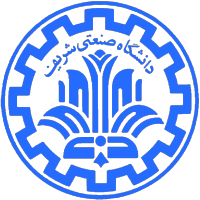

<font color=0F5298 size=7>
Final Project <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
Fall 2025 <br>
<font color=3C99D size=5>
    Machine Learning  <br>
<font color=696880 size=4>
Prepared by Group 47 (Armin Zeinalzadeh, Pouria Hosseini, Matin Mir)

____

# **PHASE 1**

#### **1.0. Imports**

In [ ]:
import pandas as pd
import numpy as np
import math
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import joblib
from sklearn.model_selection import train_test_split

#### **1.1. Loading Data**

In [3]:
df_sales_raw = pd.read_csv("./train.csv", low_memory=False)
df_store_raw = pd.read_csv("./store.csv", low_memory=False)

In [4]:
# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store")
df_raw.sample()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
424628    599          1  2014-06-16  11794        955     1      1   

       StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
424628            0              0         d          c                580.0   

        CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
424628                       11.0                    2014.0       0   

        Promo2SinceWeek  Promo2SinceYear PromoInterval  
424628              NaN              NaN           NaN

In [5]:
df1 = df_raw.copy()

In [6]:
#rename columns
cols_old = df1.columns.tolist()
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [7]:
df1.head()

store  day_of_week        date  sales  customers  open  promo  \
0      1            5  2015-07-31   5263        555     1      1   
1      2            5  2015-07-31   6064        625     1      1   
2      3            5  2015-07-31   8314        821     1      1   
3      4            5  2015-07-31  13995       1498     1      1   
4      5            5  2015-07-31   4822        559     1      1   

  state_holiday  school_holiday store_type assortment  competition_distance  \
0             0               1          c          a                1270.0   
1             0               1          a          a                 570.0   
2             0               1          a          a               14130.0   
3             0               1          c          c                 620.0   
4             0               1          a          a               29910.0   

   competition_open_since_month  competition_open_since_year  promo2  \
0                           9.0                       2008.0       0   
1                          11.0                       2007.0       1   
2                          12.0                       2006.0       1   
3                           9.0                       2009.0       0   
4                           4.0                       2015.0       0   

   promo2_since_week  promo2_since_year   promo_interval  
0                NaN                NaN              NaN  
1               13.0             2010.0  Jan,Apr,Jul,Oct  
2               14.0             2011.0  Jan,Apr,Jul,Oct  
3                NaN                NaN              NaN  
4                NaN                NaN              NaN

In [8]:
print("Number of Rows: {}".format(df1.shape[0]))
print("NUmber of Cols: {}".format(df1.shape[1]))

Number of Rows: 1017209
NUmber of Cols: 18


##### **1.1.1. data types**

In [9]:
df1['date'] = pd.to_datetime(df1["date"])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

##### **1.1.2. Handling Missing Values** 

In [10]:
df1.isna().mean()

store                           0.000000
day_of_week                     0.000000
date                            0.000000
sales                           0.000000
customers                       0.000000
open                            0.000000
promo                           0.000000
state_holiday                   0.000000
school_holiday                  0.000000
store_type                      0.000000
assortment                      0.000000
competition_distance            0.002597
competition_open_since_month    0.317878
competition_open_since_year     0.317878
promo2                          0.000000
promo2_since_week               0.499436
promo2_since_year               0.499436
promo_interval                  0.499436
dtype: float64

General Logic:
For columns containing date components (month, year, day, etc.), missing values are filled using the corresponding information from the main date column.

Approach:

If a date component column has NaN → Extract and fill with the relevant part from the date column

If value exists → Keep the original value

In [11]:
# competition_distance
df1["competition_distance"] = df1["competition_distance"].fillna(200000.0)

In [12]:
# competition_open_since_month
df1.competition_open_since_month = df1.apply(lambda x: x["date"].month if math.isnan(x["competition_open_since_month"]) else x["competition_open_since_month"], axis=1)

In [13]:
# competition_open_since_year
df1.competition_open_since_year = df1.apply(lambda x: x["date"].year if math.isnan(x["competition_open_since_year"]) else x["competition_open_since_year"], axis=1)

In [14]:
# promo2_since_week
df1["promo2_since_week"] = df1.apply(lambda x: x["date"].week if math.isnan(x["promo2_since_week"]) else x["promo2_since_week"], axis=1) 

In [15]:
# promo2_since_year
df1["promo2_since_year"] = df1.apply(lambda x: x["date"].year if math.isnan(x["promo2_since_year"]) else x["promo2_since_year"], axis=1)

In [16]:
# promo_interval
month_map = {1: "Jan", 2: "Fev", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

df1["promo_interval"].fillna(0, inplace=True)
df1["month_map"] = df1["date"].dt.month.map(month_map)

df1["is_promo"] = df1[["promo_interval", "month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(",") else 0, axis=1)

C:\Users\mobile-erfan\AppData\Local\Temp\ipykernel_6800\770179852.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1["promo_interval"].fillna(0, inplace=True)


##### **1.1.3. Change Data Types**

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [18]:
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)

df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

### **1.2. Descriptive Statistical**

In [19]:
num_attributes = df1.select_dtypes(include=["int64", "float64"])
cat_attributes = df1.select_dtypes(exclude=["int64", "float64", "datetime64[ns]"])

##### **1.2.1 Numerical Attributes**

In [20]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

## Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T

d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
stats = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
stats.columns = ["attributes", "min", "max", "range", "mean", "median", "std", "skew", "kurtosis"]

In [21]:
stats

attributes   min       max     range         mean  median  \
0                 store   1.0    1115.0    1114.0   558.429727   558.0   
1           day_of_week   1.0       7.0       6.0     3.998341     4.0   
2                 sales   0.0   41551.0   41551.0  5773.818972  5744.0   
3             customers   0.0    7388.0    7388.0   633.145946   609.0   
4                  open   0.0       1.0       1.0     0.830107     1.0   
5                 promo   0.0       1.0       1.0     0.381515     0.0   
6        school_holiday   0.0       1.0       1.0     0.178647     0.0   
7  competition_distance  20.0  200000.0  199980.0  5935.442677  2330.0   
8                promo2   0.0       1.0       1.0     0.500564     1.0   
9              is_promo   0.0       1.0       1.0     0.155231     0.0   

            std       skew    kurtosis  
0    321.908493  -0.000955   -1.200524  
1      1.997390   0.001593   -1.246873  
2   3849.924283   0.641460    1.778375  
3    464.411506   1.598650    7.091773  
4      0.375539  -1.758045    1.090723  
5      0.485758   0.487838   -1.762018  
6      0.383056   1.677842    0.815154  
7  12547.646829  10.242344  147.789712  
8      0.500000  -0.002255   -1.999999  
9      0.362124   1.904152    1.625796

##### **1.2.2 Categorical Attributes**

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

Sales analysis

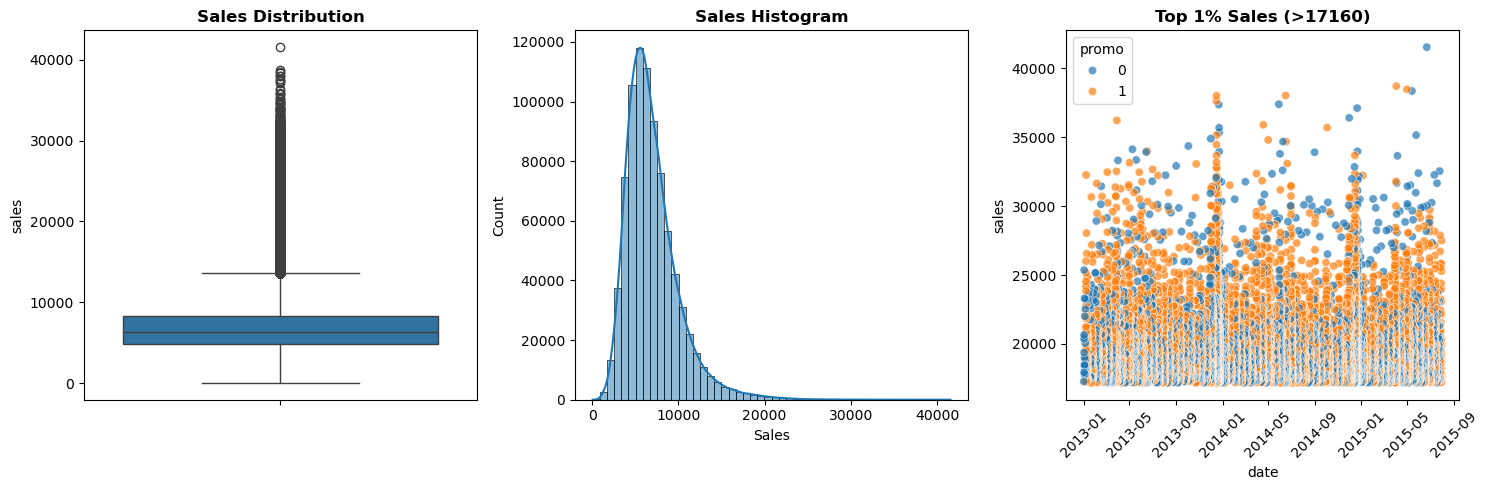

In [23]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y='sales', data=df1[df1['sales'] > 0])
plt.title('Sales Distribution', fontweight='bold')

plt.subplot(1, 3, 2)
sns.histplot(df1[df1['sales'] > 0]['sales'], bins=50, kde=True)
plt.title('Sales Histogram', fontweight='bold')
plt.xlabel('Sales')

plt.subplot(1, 3, 3)
p99 = df1['sales'].quantile(0.99)
outliers = df1[df1['sales'] > p99]
sns.scatterplot(x='date', y='sales', data=outliers, hue='promo', alpha=0.7)
plt.title(f'Top 1% Sales (>{p99:.0f})', fontweight='bold')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('./pictures/sales_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

##### **1.2.3. Plotting Sales Trend** 

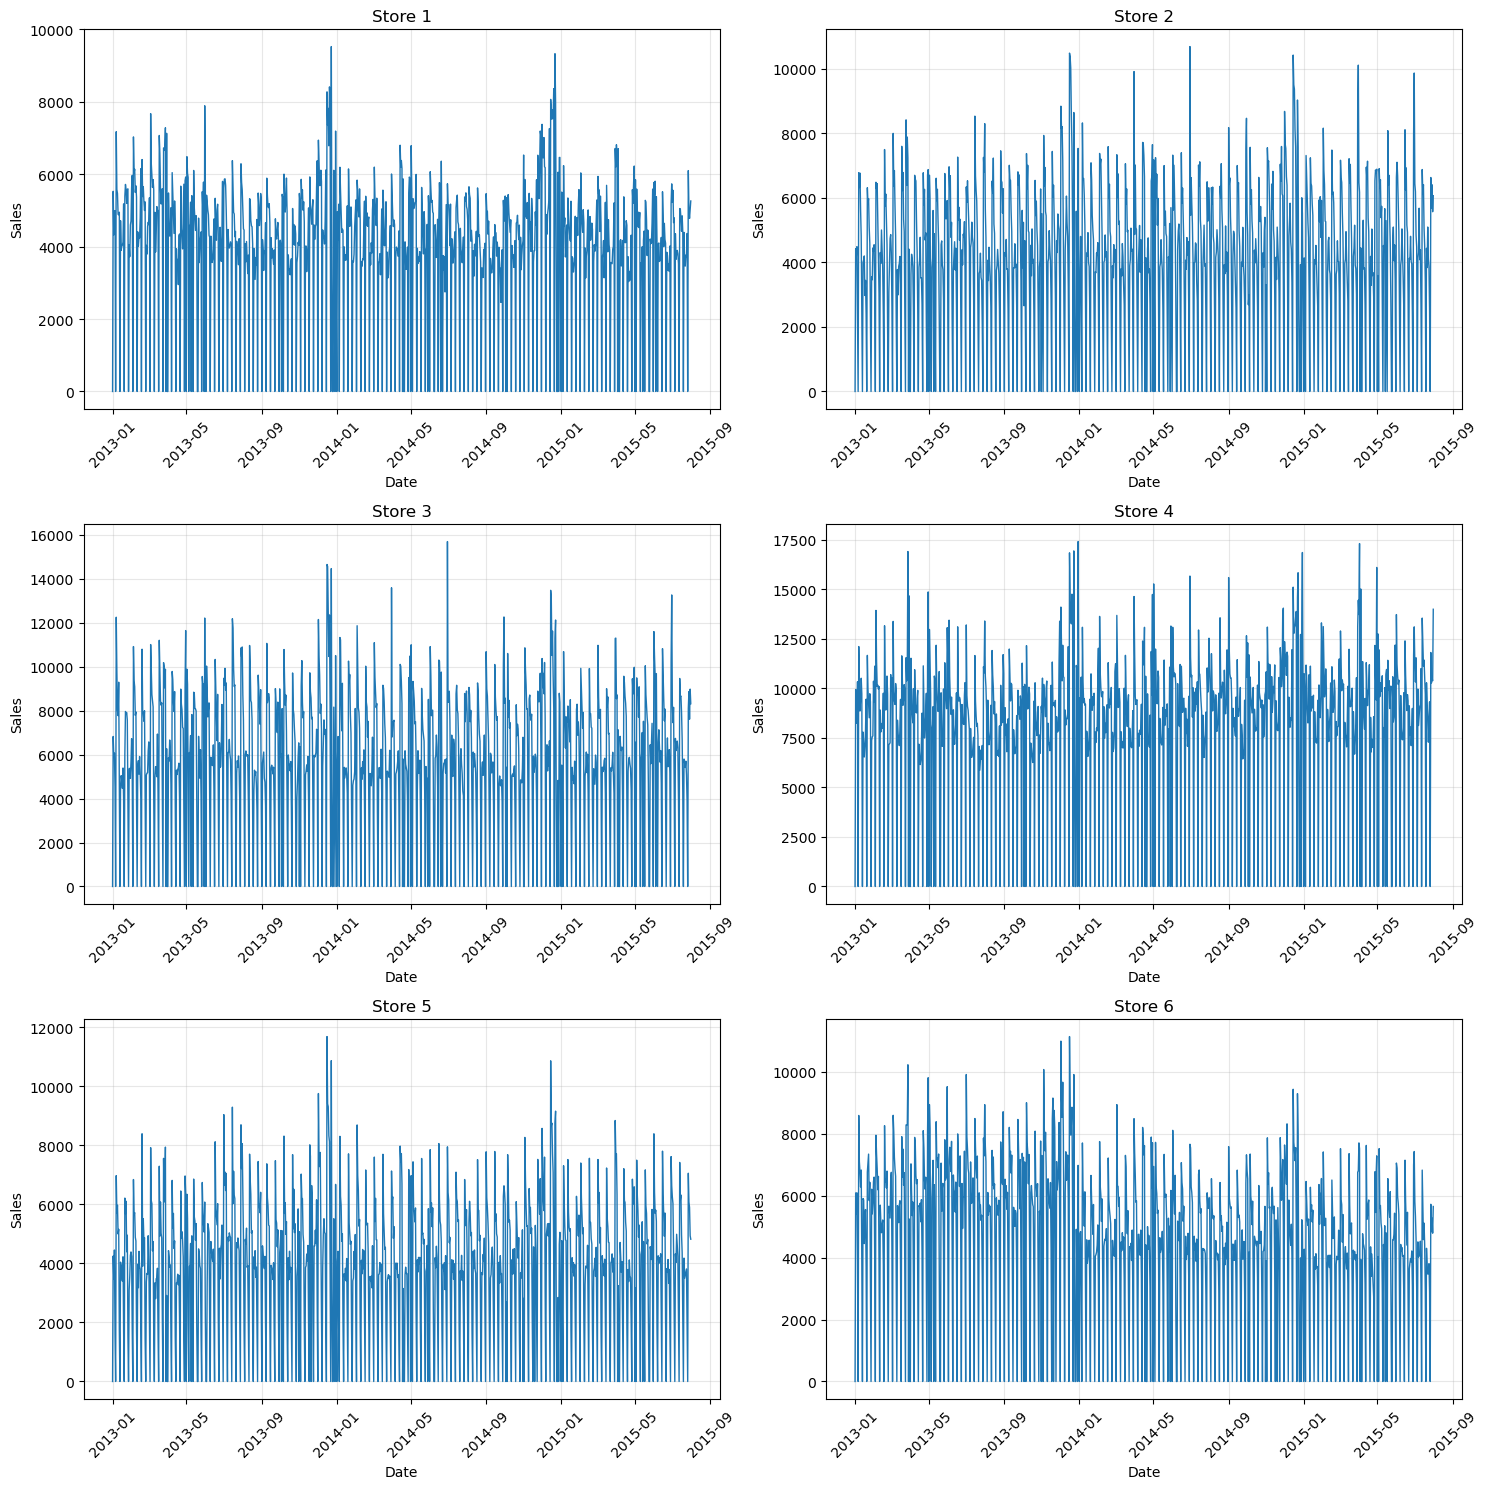

In [24]:
selected_stores = [1, 2, 3, 4, 5, 6]
df_selected = df1[df1['store'].isin(selected_stores)]

n_stores = len(selected_stores)
n_cols = 2
n_rows = (n_stores + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

for i, store_id in enumerate(selected_stores):
    store_data = df_selected[df_selected['store'] == store_id]
    axes[i].plot(store_data['date'], store_data['sales'], linewidth=1)
    axes[i].set_title(f'Store {store_id}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Sales')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./pictures/sale_trends.png', dpi=300, bbox_inches='tight')
plt.show()

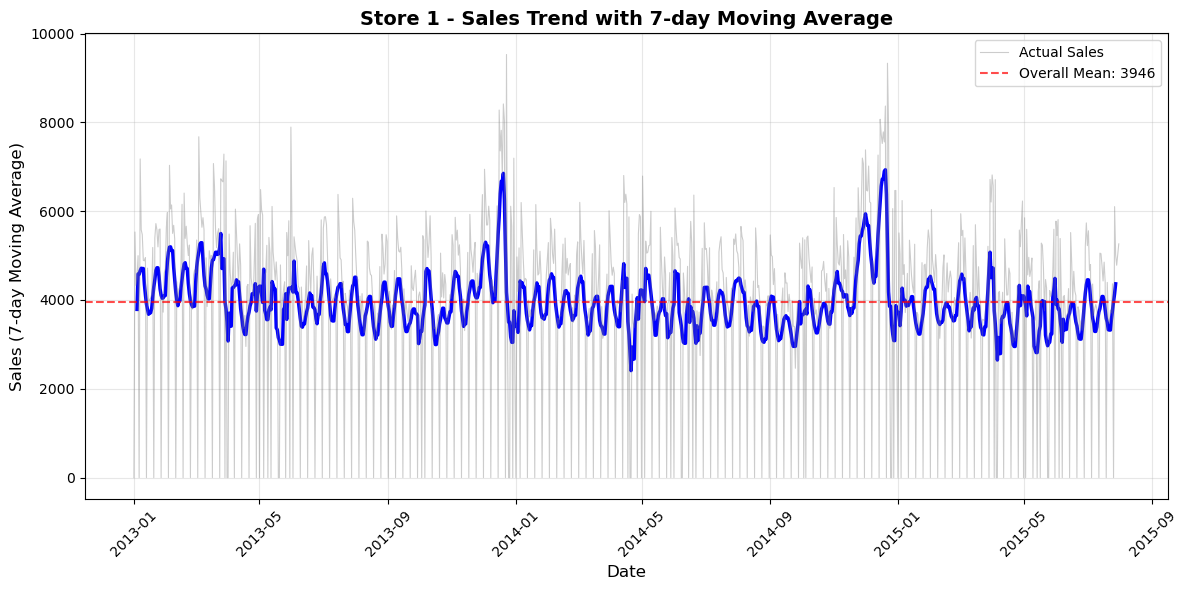

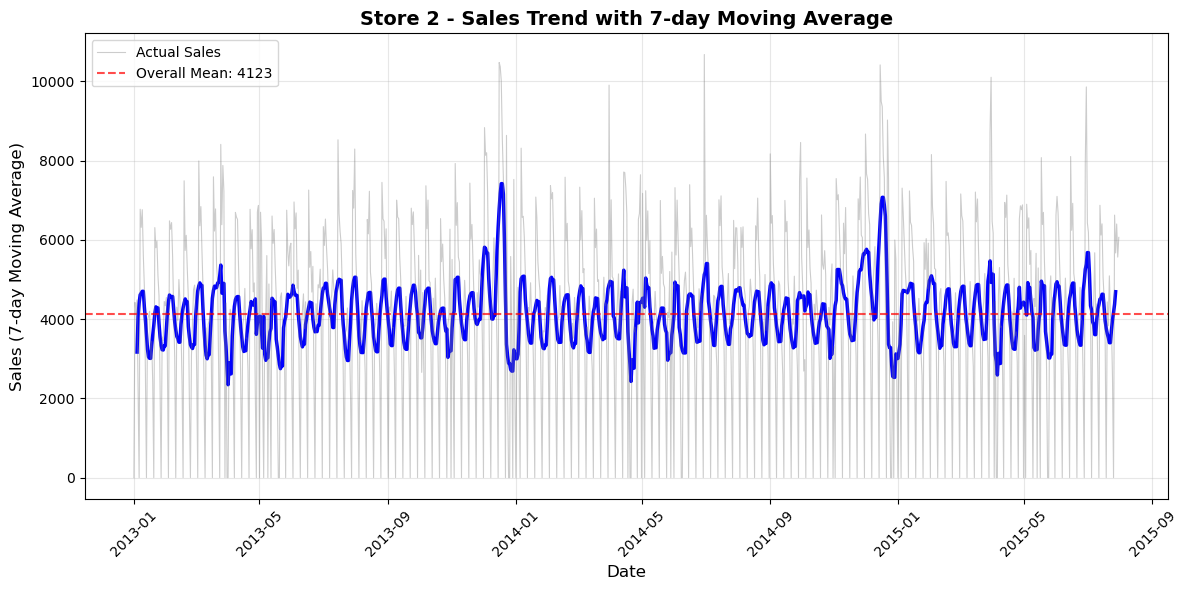

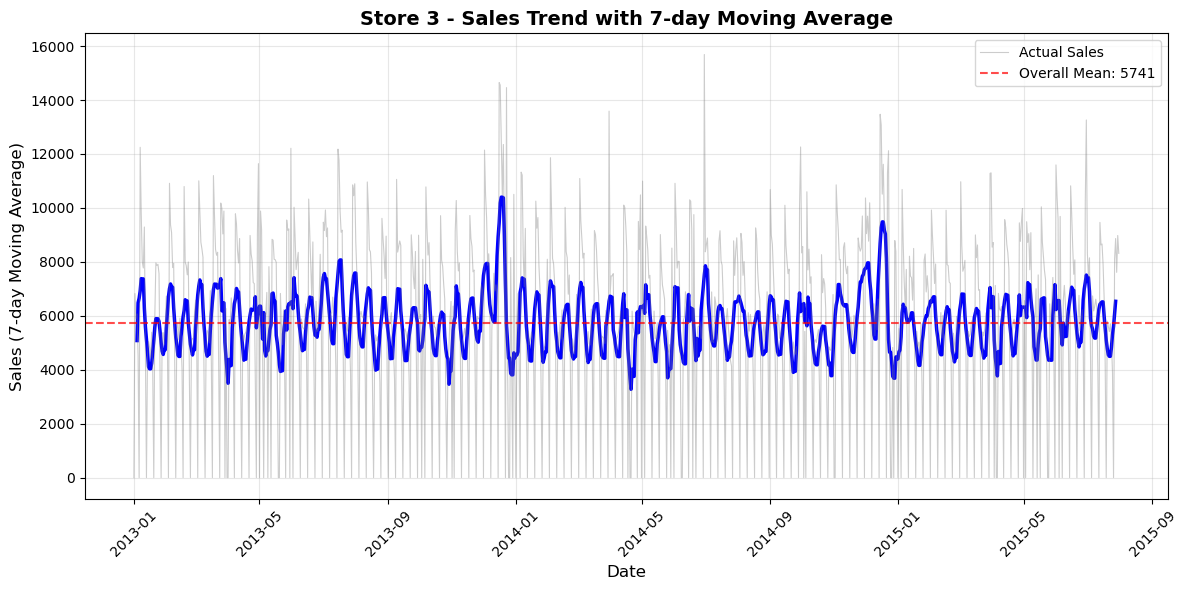

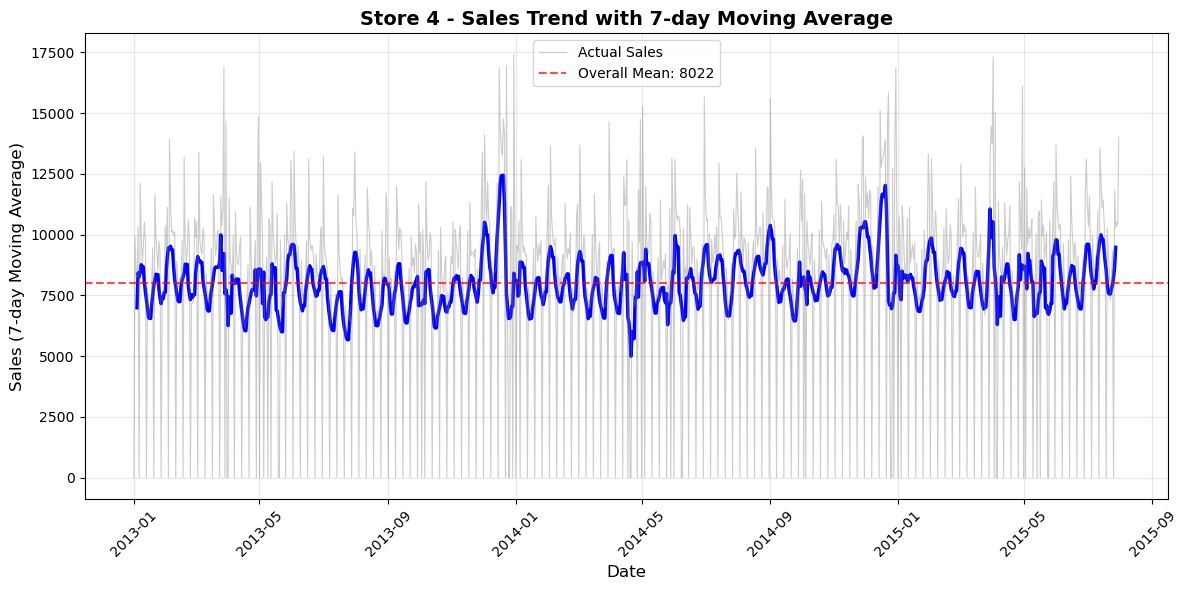

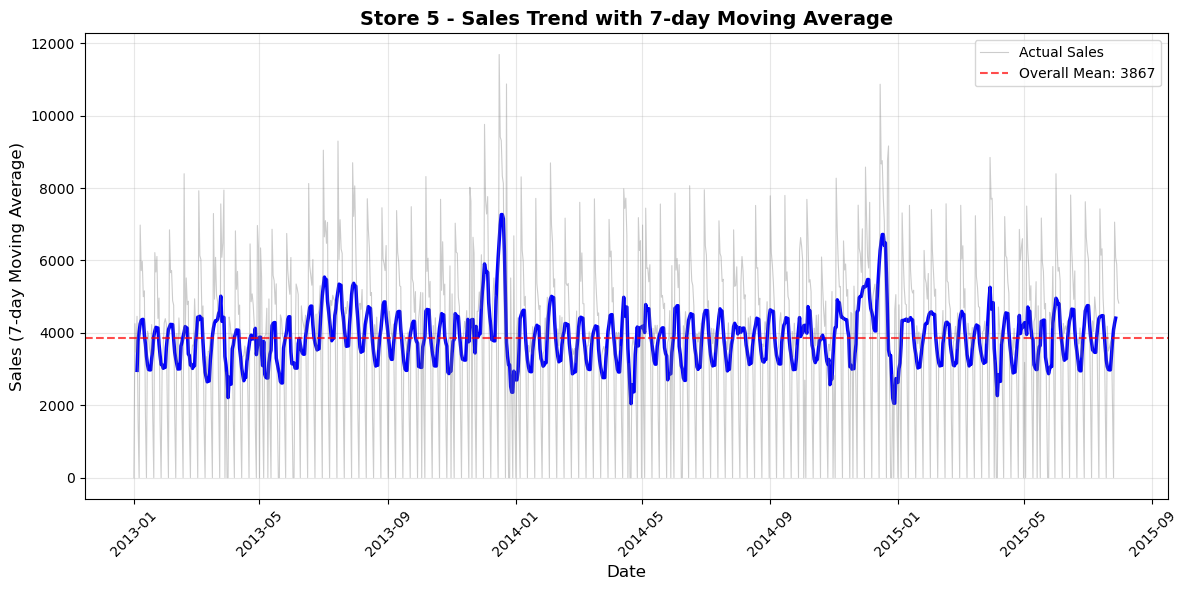

In [25]:
selected_stores = [1, 2, 3, 4, 5]
df_selected = df1[df1['store'].isin(selected_stores)]

for store_id in selected_stores:
    store_data = df_selected[df_selected['store'] == store_id].sort_values('date').copy()
    
    if len(store_data) > 0:
        store_data['sales_ma7'] = store_data['sales'].rolling(window=7, center=True).mean()
        
        plt.figure(figsize=(12, 6))
        plt.plot(store_data['date'], store_data['sales_ma7'], 
                linewidth=2.5, color='blue')
        
        plt.plot(store_data['date'], store_data['sales'], 
                linewidth=0.8, color='gray', alpha=0.4, label='Actual Sales')
        
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Sales (7-day Moving Average)', fontsize=12)
        plt.title(f'Store {store_id} - Sales Trend with 7-day Moving Average', 
                 fontsize=14, fontweight='bold')
        plt.legend(['7-day MA', 'Actual Sales'])
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        
        mean_sales = store_data['sales'].mean()
        plt.axhline(y=mean_sales, color='red', linestyle='--', 
                   alpha=0.7, label=f'Overall Mean: {mean_sales:.0f}')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(f'./pictures/sales_trend_store{store_id}.png', dpi=300, bbox_inches='tight')
        plt.show()

##### **1.2.4. Feature Importnace Analysis**

###### **1.2.4.1 Categorical Feature's**

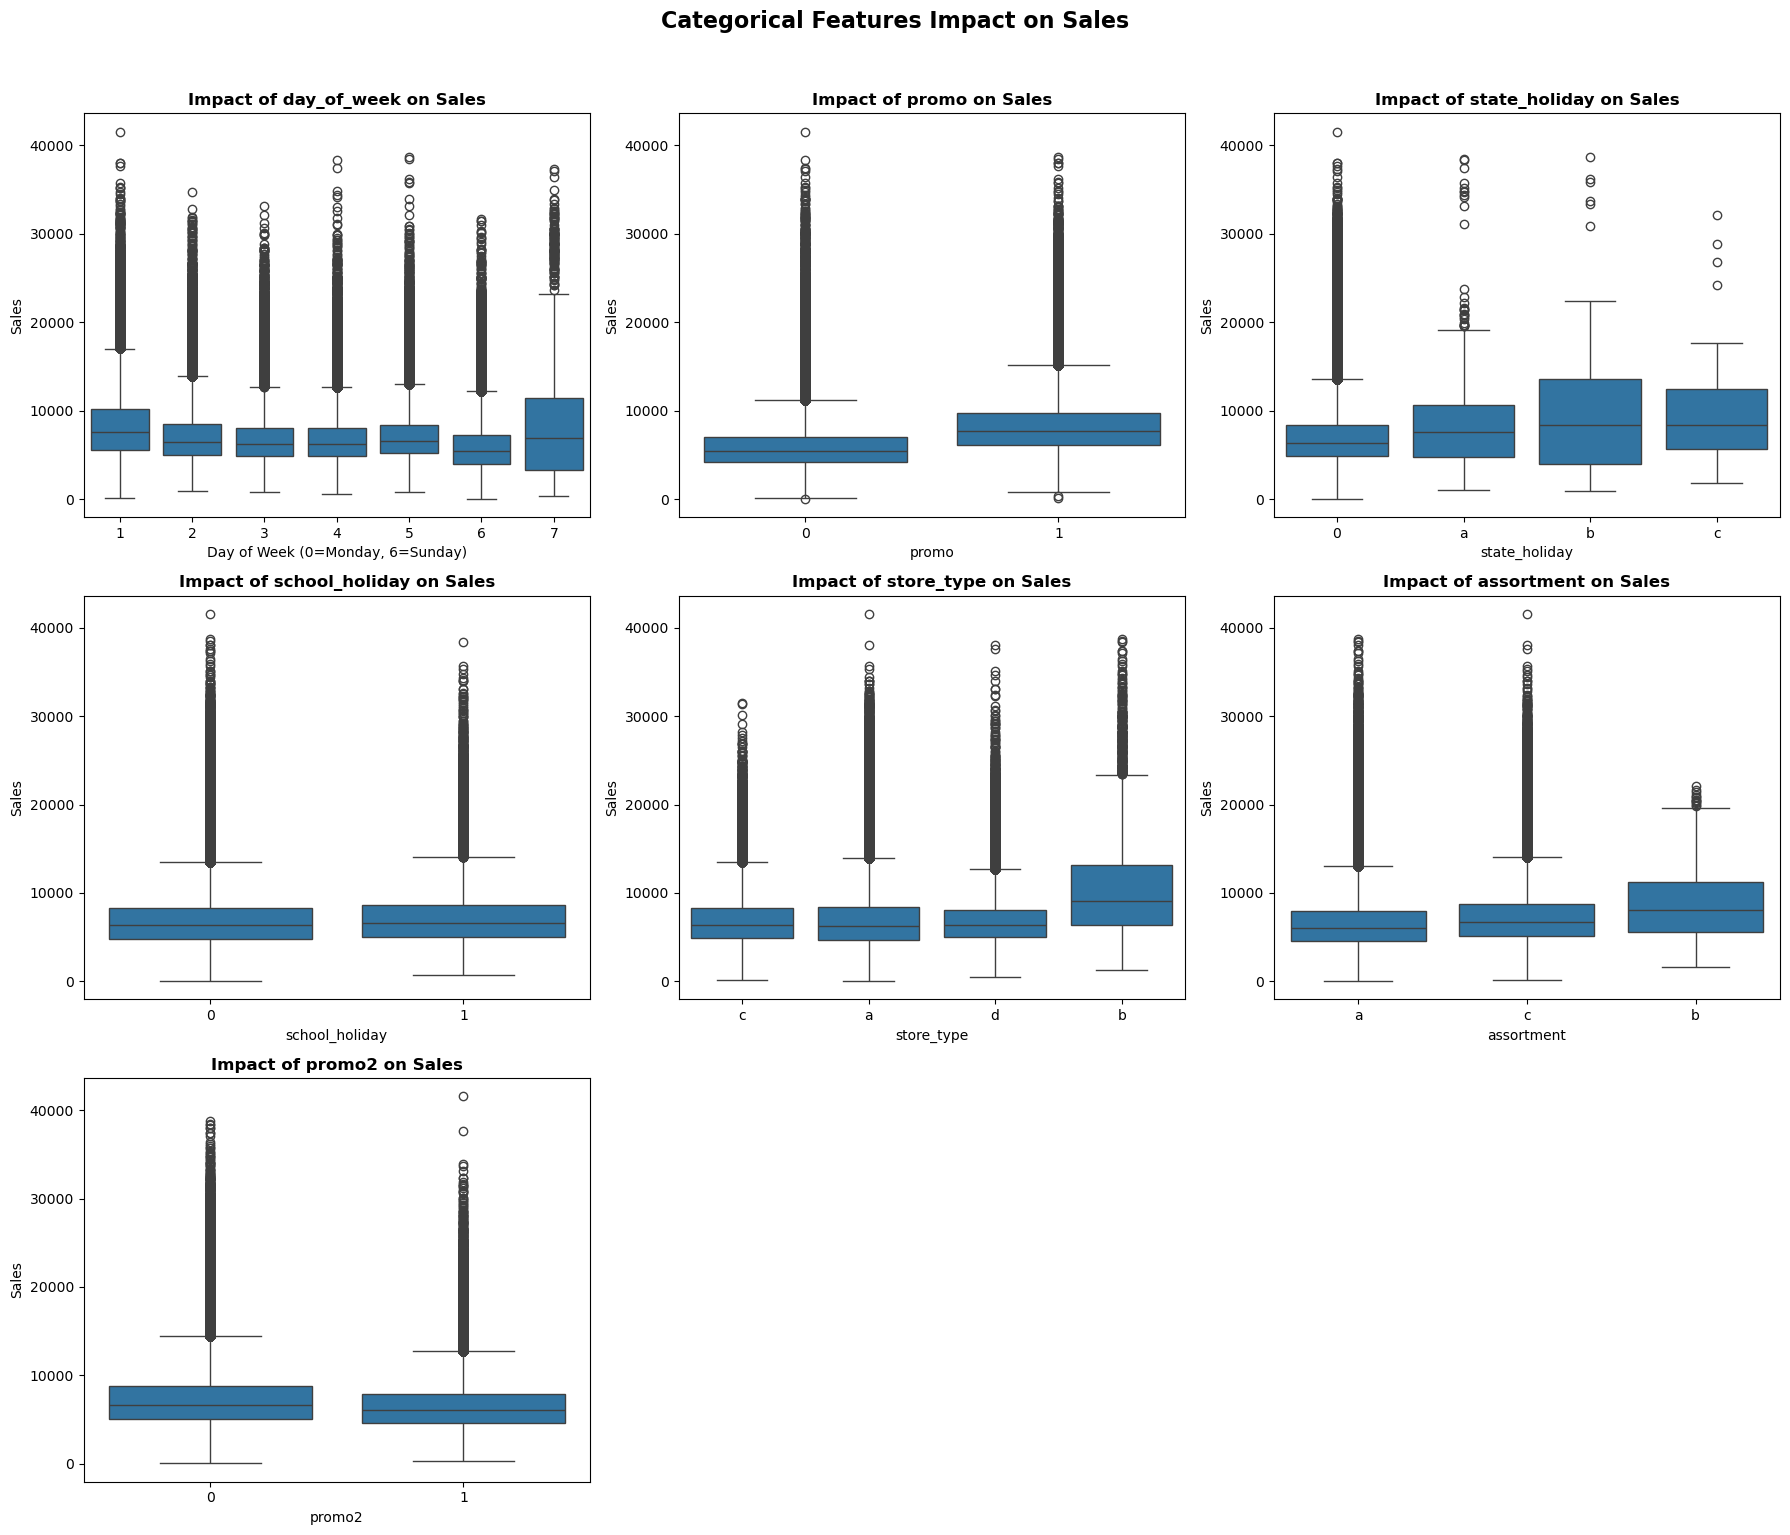

In [26]:
categorical_features = ['day_of_week', 'promo', 'state_holiday', 'school_holiday', 
                        'store_type', 'assortment', 'promo2']

n_features = len(categorical_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    if feature == 'day_of_week':

        df1['day_name'] = df1['date'].dt.day_name()
        sns.boxplot(x=feature, y='sales', data=df1[df1['sales'] > 0], ax=axes[idx])
        axes[idx].set_title(f'Impact of {feature} on Sales', fontweight='bold')
        axes[idx].set_xlabel('Day of Week (0=Monday, 6=Sunday)')
    else:
        sns.boxplot(x=feature, y='sales', data=df1[df1['sales'] > 0], ax=axes[idx])
        axes[idx].set_title(f'Impact of {feature} on Sales', fontweight='bold')
        axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Sales')

for j in range(idx+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Categorical Features Impact on Sales', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('./pictures/categorical_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

State holiday values: ['0' 'a' 'b' 'c']


C:\Users\mobile-erfan\AppData\Local\Temp\ipykernel_6800\314215144.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=holiday_data, x="state_holiday", palette="viridis")


Store type values: ['c' 'a' 'd' 'b']


C:\Users\mobile-erfan\AppData\Local\Temp\ipykernel_6800\314215144.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df1, x="store_type", palette="magma")


Assortment values: ['a' 'c' 'b']


C:\Users\mobile-erfan\AppData\Local\Temp\ipykernel_6800\314215144.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df1, x="assortment", palette="plasma")


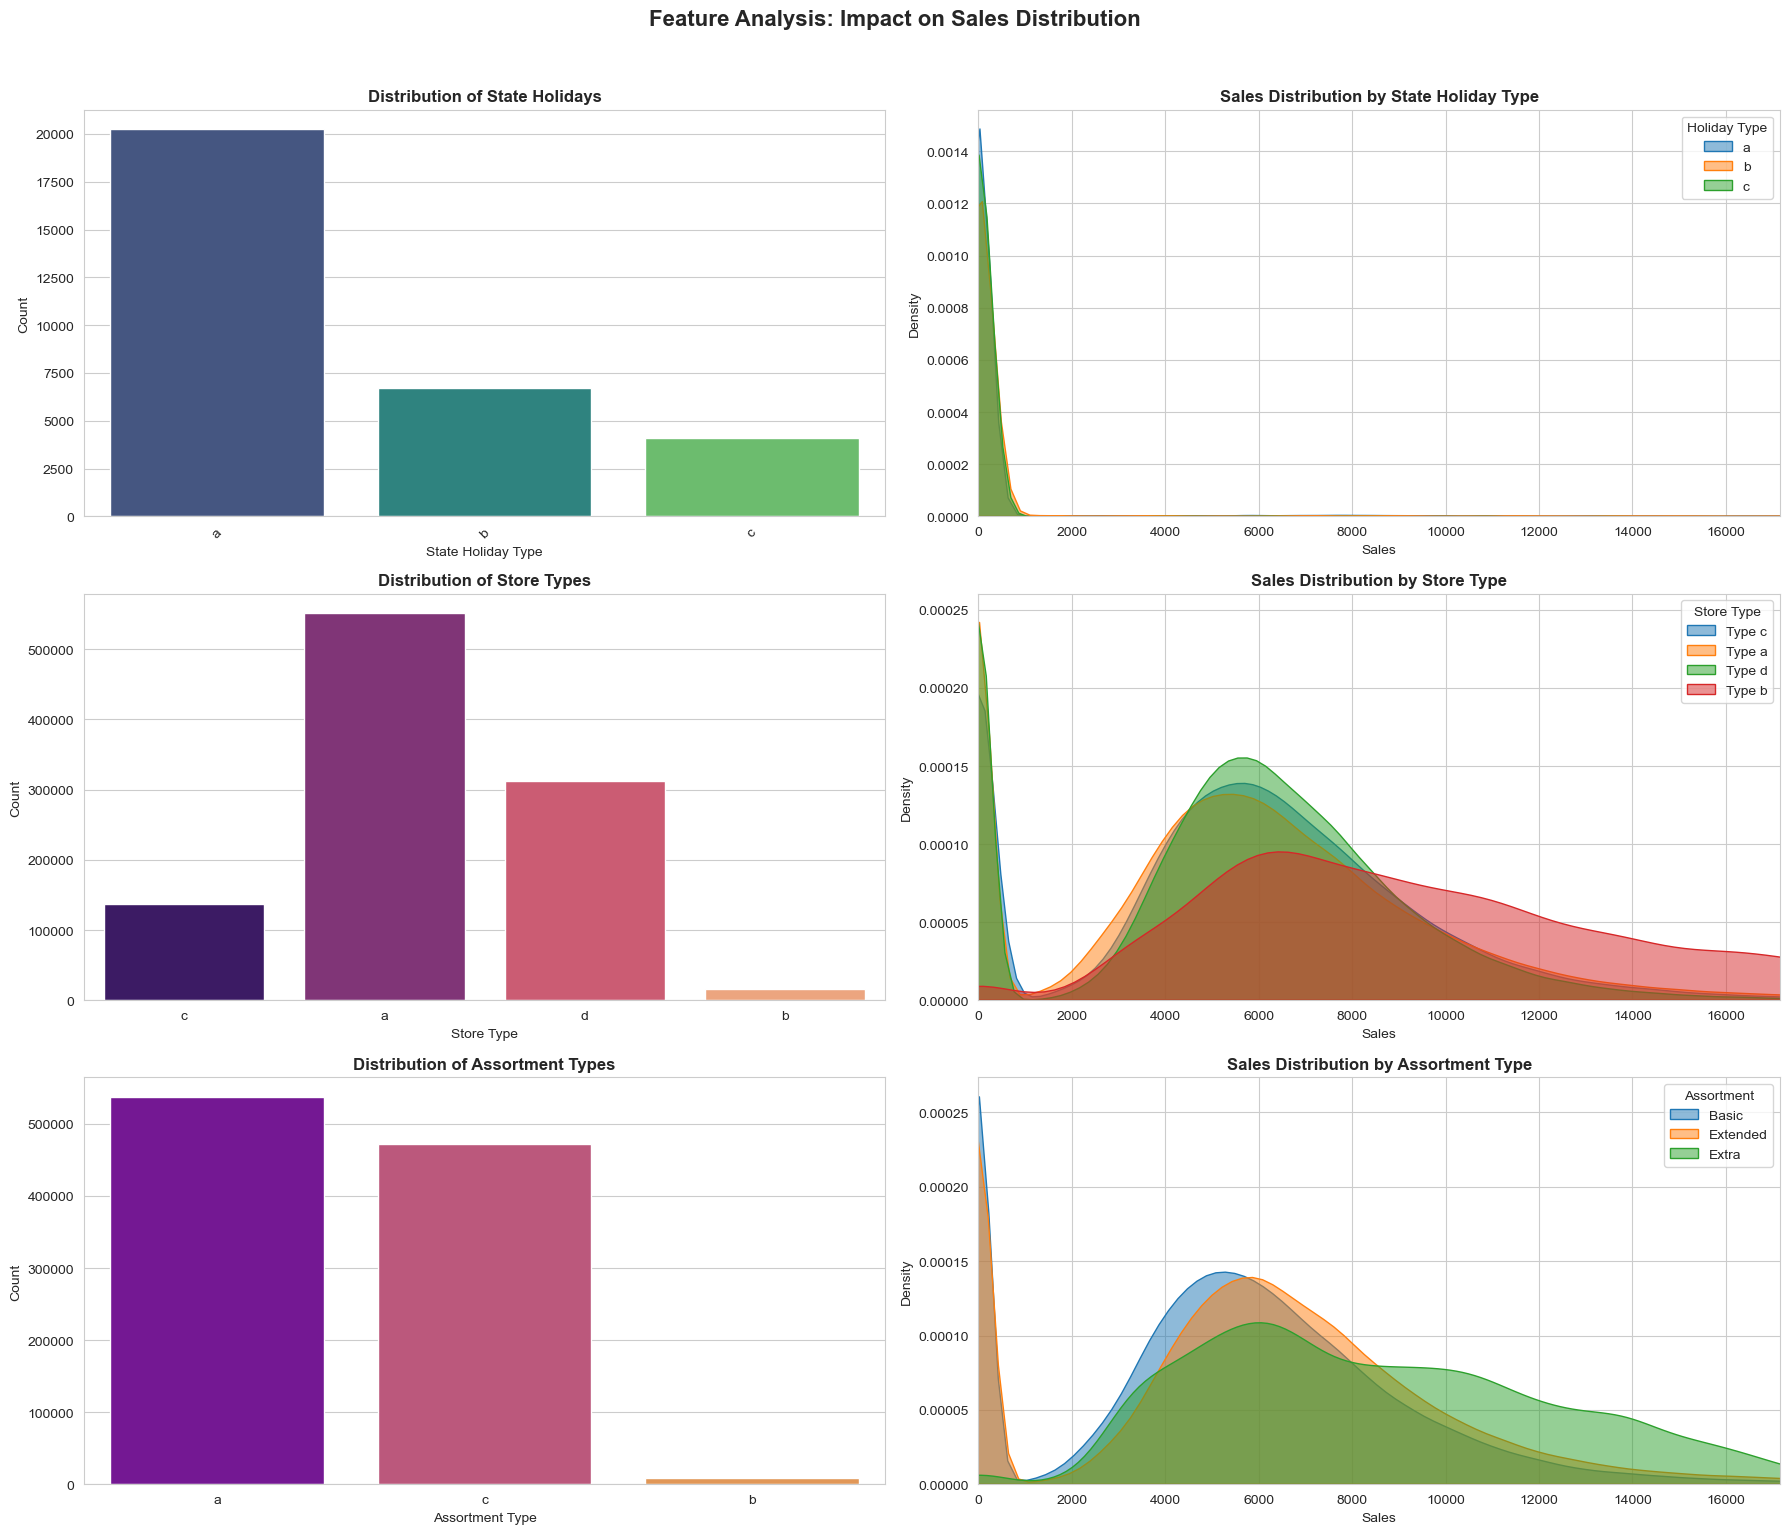

In [27]:
plt.figure(figsize=(18, 15))
sns.set_style("whitegrid")

plt.subplot(3, 2, 1)
holiday_data = df1[df1["state_holiday"] != "0"] 

print("State holiday values:", df1["state_holiday"].unique())

sns.countplot(data=holiday_data, x="state_holiday", palette="viridis")
plt.title('Distribution of State Holidays', fontsize=12, fontweight='bold')
plt.xlabel('State Holiday Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(3, 2, 2)
holiday_types = holiday_data["state_holiday"].unique()

for holiday in holiday_types:
    subset = holiday_data[holiday_data["state_holiday"] == holiday]
    if len(subset) > 10: 
        sns.kdeplot(data=subset, x="sales", label=holiday, fill=True, alpha=0.5)

plt.title('Sales Distribution by State Holiday Type', fontsize=12, fontweight='bold')
plt.xlabel('Sales')
plt.ylabel('Density')
plt.legend(title='Holiday Type')
plt.xlim(0, df1["sales"].quantile(0.99))  

plt.subplot(3, 2, 3)
print("Store type values:", df1["store_type"].unique())

sns.countplot(data=df1, x="store_type", palette="magma")
plt.title('Distribution of Store Types', fontsize=12, fontweight='bold')
plt.xlabel('Store Type')
plt.ylabel('Count')

plt.subplot(3, 2, 4)
store_types = df1["store_type"].unique()

for store_type in store_types:
    if pd.notna(store_type):
        subset = df1[df1["store_type"] == store_type]
        if len(subset) > 10:
            sns.kdeplot(data=subset, x="sales", label=f'Type {store_type}', 
                       fill=True, alpha=0.5)

plt.title('Sales Distribution by Store Type', fontsize=12, fontweight='bold')
plt.xlabel('Sales')
plt.ylabel('Density')
plt.legend(title='Store Type')
plt.xlim(0, df1["sales"].quantile(0.99))

plt.subplot(3, 2, 5)
print("Assortment values:", df1["assortment"].unique())

sns.countplot(data=df1, x="assortment", palette="plasma")
plt.title('Distribution of Assortment Types', fontsize=12, fontweight='bold')
plt.xlabel('Assortment Type')
plt.ylabel('Count')

plt.subplot(3, 2, 6)
assortment_types = df1["assortment"].unique()

assortment_names = {
    'a': 'Basic',
    'b': 'Extra',
    'c': 'Extended'
}

for ass_type in assortment_types:
    if pd.notna(ass_type):
        subset = df1[df1["assortment"] == ass_type]
        if len(subset) > 10:
            label_name = assortment_names.get(ass_type, f'Type {ass_type}')
            sns.kdeplot(data=subset, x="sales", label=label_name, 
                       fill=True, alpha=0.5)

plt.title('Sales Distribution by Assortment Type', fontsize=12, fontweight='bold')
plt.xlabel('Sales')
plt.ylabel('Density')
plt.legend(title='Assortment')
plt.xlim(0, df1["sales"].quantile(0.99))

plt.suptitle('Feature Analysis: Impact on Sales Distribution', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('./pictures/categorical.png', dpi=300, bbox_inches='tight')
plt.show()

###### **1.2.4.2 Numerical Feature's**

In [28]:
num_attributes.columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'school_holiday', 'competition_distance', 'promo2', 'is_promo'],
      dtype='object')

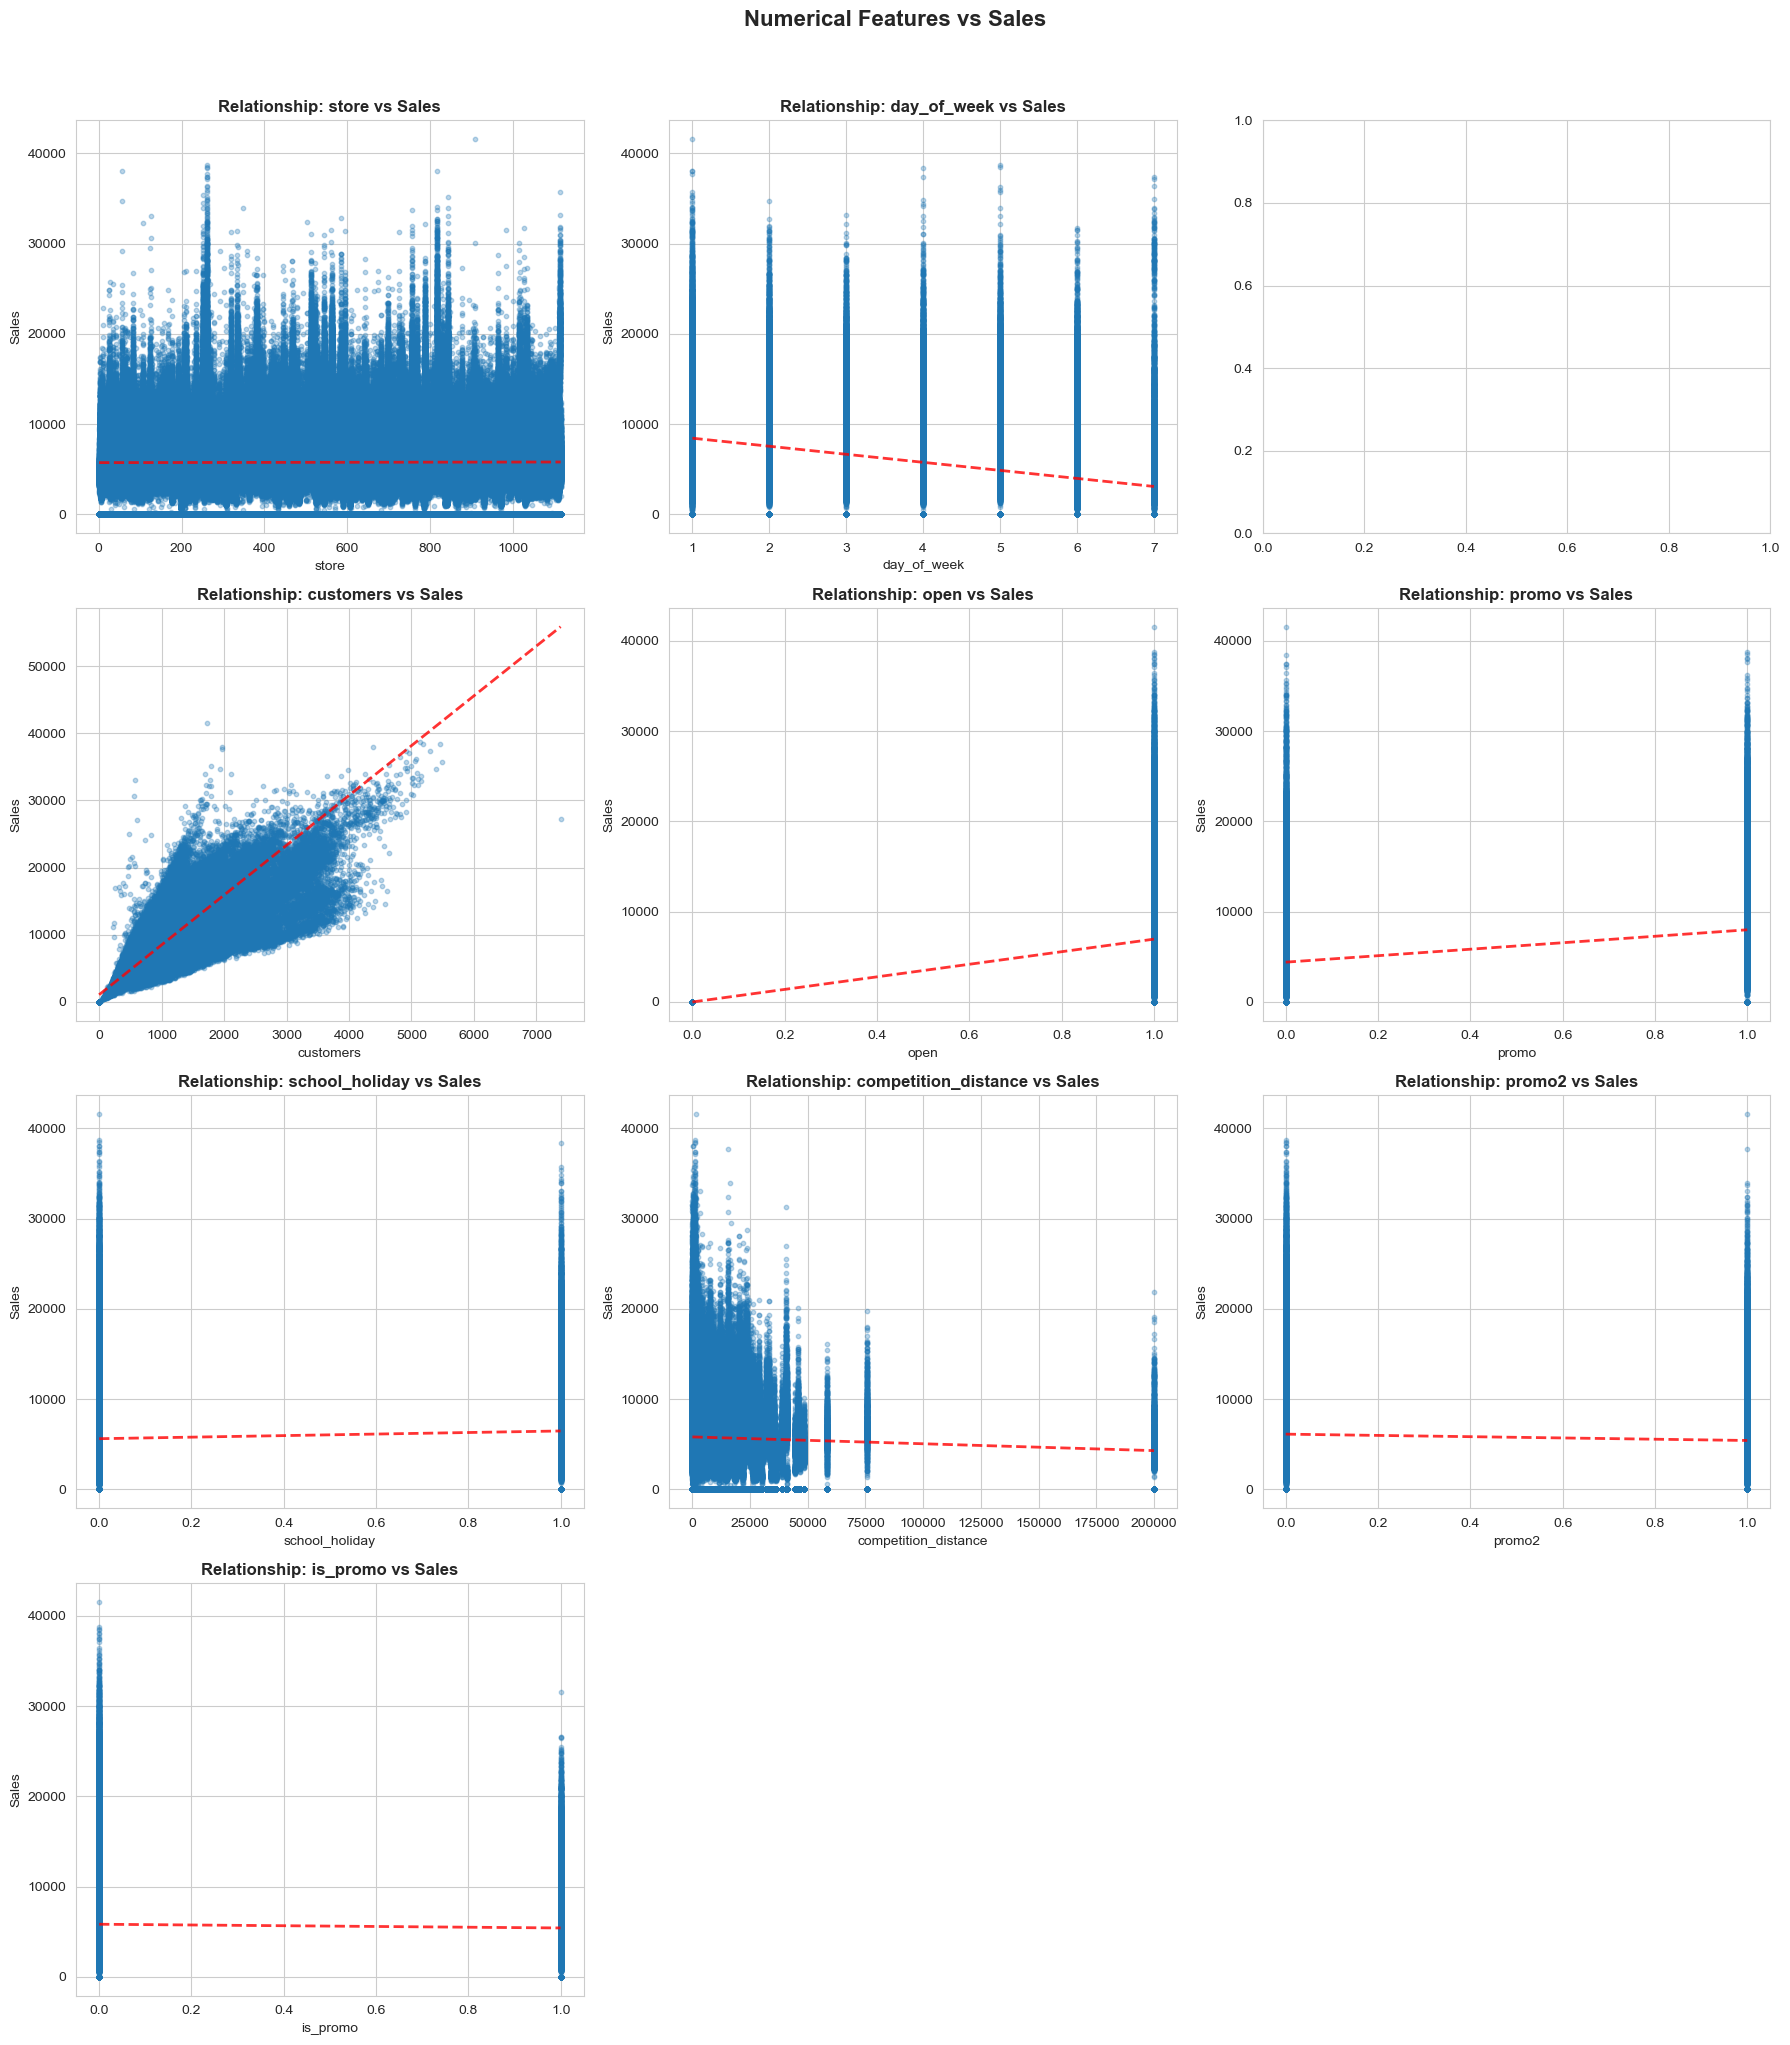

In [29]:
numerical_features = ['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
                      'school_holiday', 'competition_distance', 'promo2', 'is_promo']

n_features = len(numerical_features)
n_cols = 3 
n_rows = (n_features + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten() 

for idx, feature in enumerate(numerical_features):
    if feature != 'sales':  
        clean_data = df1[[feature, 'sales']].dropna()
        
        axes[idx].scatter(clean_data[feature], clean_data['sales'], alpha=0.3, s=10)
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Sales')
        axes[idx].set_title(f'Relationship: {feature} vs Sales', fontweight='bold')
        
        if clean_data[feature].dtype in ['int64', 'float64']:
            try:
                z = np.polyfit(clean_data[feature], clean_data['sales'], 1)
                p = np.poly1d(z)
                x_sorted = np.sort(clean_data[feature])
                axes[idx].plot(x_sorted, p(x_sorted), "r--", alpha=0.8, linewidth=2)
            except:
                pass

for j in range(idx+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Numerical Features vs Sales', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('./pictures/numerical_features.png', dpi=300, bbox_inches='tight')
plt.show()

###### **1.2.4.3 Time Feature's**

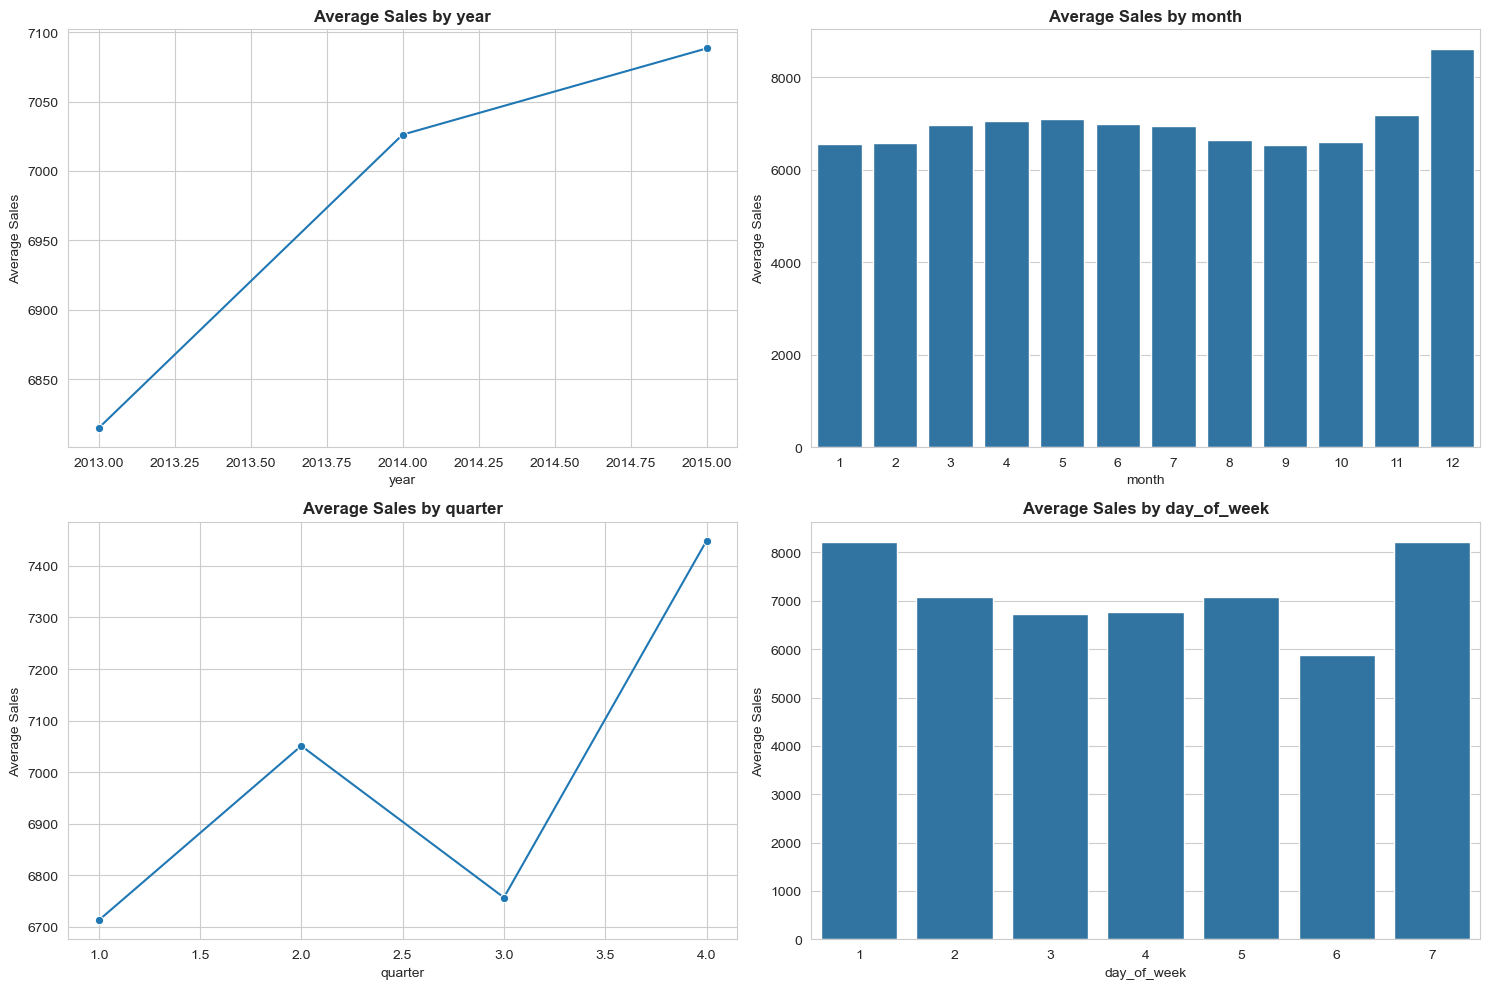

In [30]:
df1['year'] = df1['date'].dt.year
df1['month'] = df1['date'].dt.month
df1['quarter'] = df1['date'].dt.quarter

time_features = ['year', 'month', 'quarter', 'day_of_week']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(time_features):
    time_avg = df1[df1['sales'] > 0].groupby(feature)['sales'].mean().reset_index()
    
    if feature in ['month', 'day_of_week']:
        sns.barplot(x=feature, y='sales', data=time_avg, ax=axes[idx])
    else:
        sns.lineplot(x=feature, y='sales', data=time_avg, marker='o', ax=axes[idx])
    
    axes[idx].set_title(f'Average Sales by {feature}', fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Average Sales')

plt.tight_layout()
plt.savefig('./pictures/time_features.png', dpi=300, bbox_inches='tight')
plt.show()

###### **1.2.4.4. competition features**

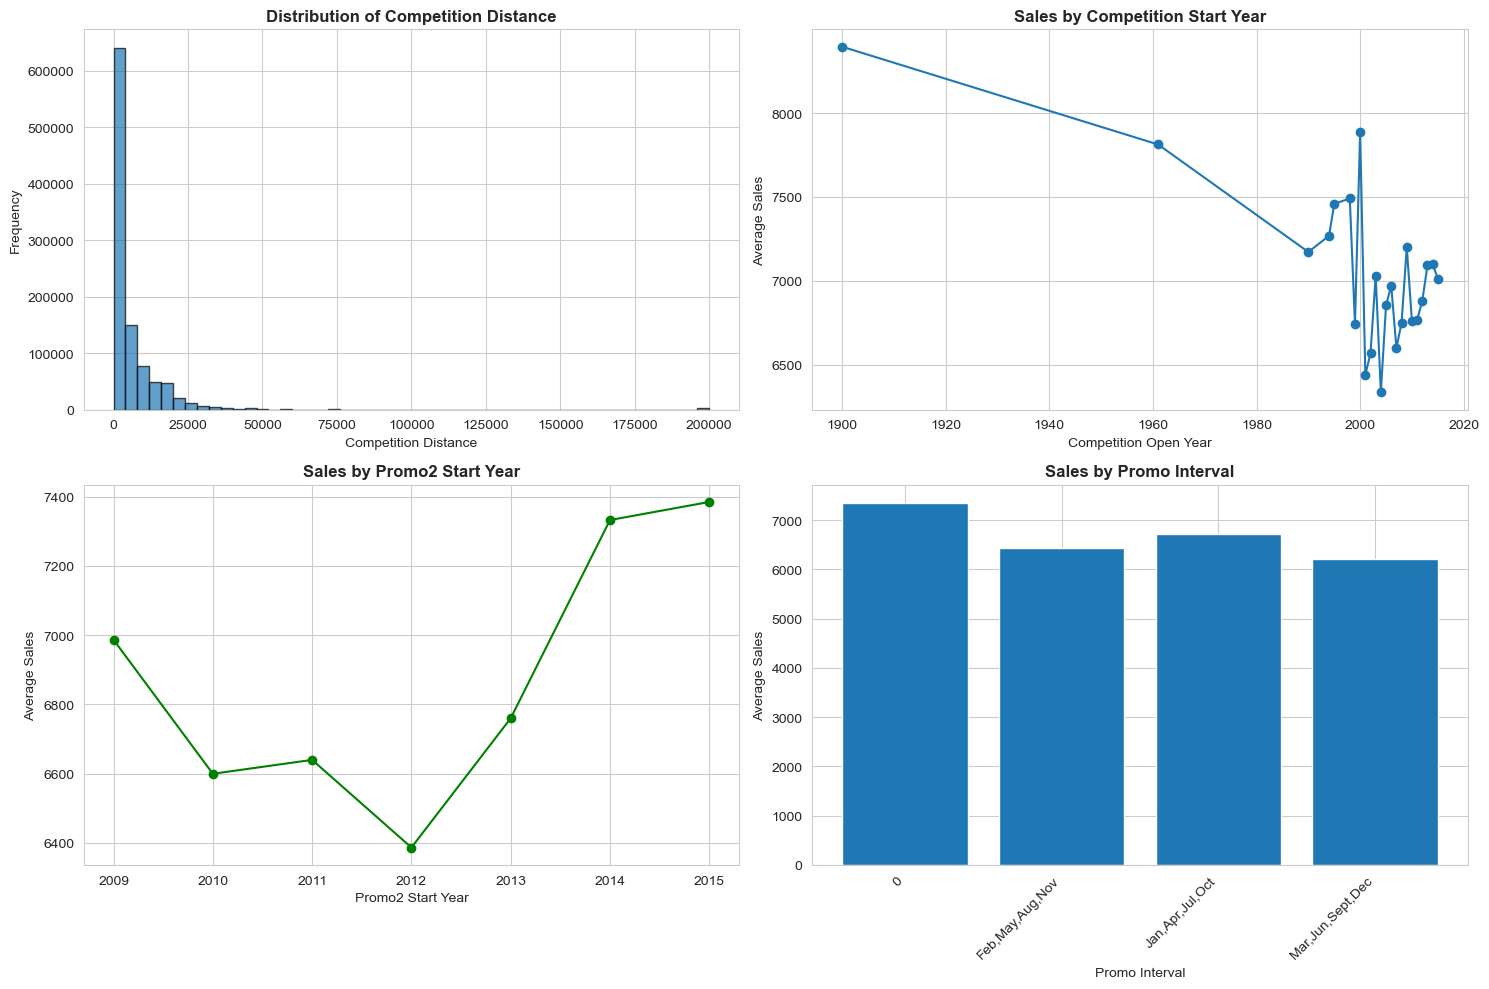

In [ ]:
competition_features = ['competition_distance', 'competition_open_since_year', 
                        'promo2_since_year', 'promo_interval']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()


axes[0].hist(df1['competition_distance'].dropna(), bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Competition Distance')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Competition Distance', fontweight='bold')


comp_year_sales = df1[df1['sales'] > 0].groupby('competition_open_since_year')['sales'].mean().reset_index()
axes[1].plot(comp_year_sales['competition_open_since_year'], comp_year_sales['sales'], marker='o')
axes[1].set_xlabel('Competition Open Year')
axes[1].set_ylabel('Average Sales')
axes[1].set_title('Sales by Competition Start Year', fontweight='bold')


promo2_year_sales = df1[df1['sales'] > 0].groupby('promo2_since_year')['sales'].mean().reset_index()
axes[2].plot(promo2_year_sales['promo2_since_year'], promo2_year_sales['sales'], marker='o', color='green')
axes[2].set_xlabel('Promo2 Start Year')
axes[2].set_ylabel('Average Sales')
axes[2].set_title('Sales by Promo2 Start Year', fontweight='bold')

if df1['promo_interval'].notna().any():
    promo_int_sales = df1[df1['sales'] > 0].groupby('promo_interval')['sales'].mean().reset_index()
    

    axes[3].bar(range(len(promo_int_sales)), promo_int_sales['sales'])
    axes[3].set_xticks(range(len(promo_int_sales)))
    axes[3].set_xticklabels(promo_int_sales['promo_interval'], rotation=45, ha='right')
    axes[3].set_xlabel('Promo Interval')
    axes[3].set_ylabel('Average Sales')
    axes[3].set_title('Sales by Promo Interval', fontweight='bold')
else:
    axes[3].text(0.5, 0.5, 'No Promo Interval Data', ha='center', va='center', transform=axes[3].transAxes)
    axes[3].set_title('Promo Interval (No Data)', fontweight='bold')

plt.tight_layout()
plt.savefig('./pictures/competition_features.png', dpi=300, bbox_inches='tight')
plt.show()

###### **1.2.4.5. interactions of features**

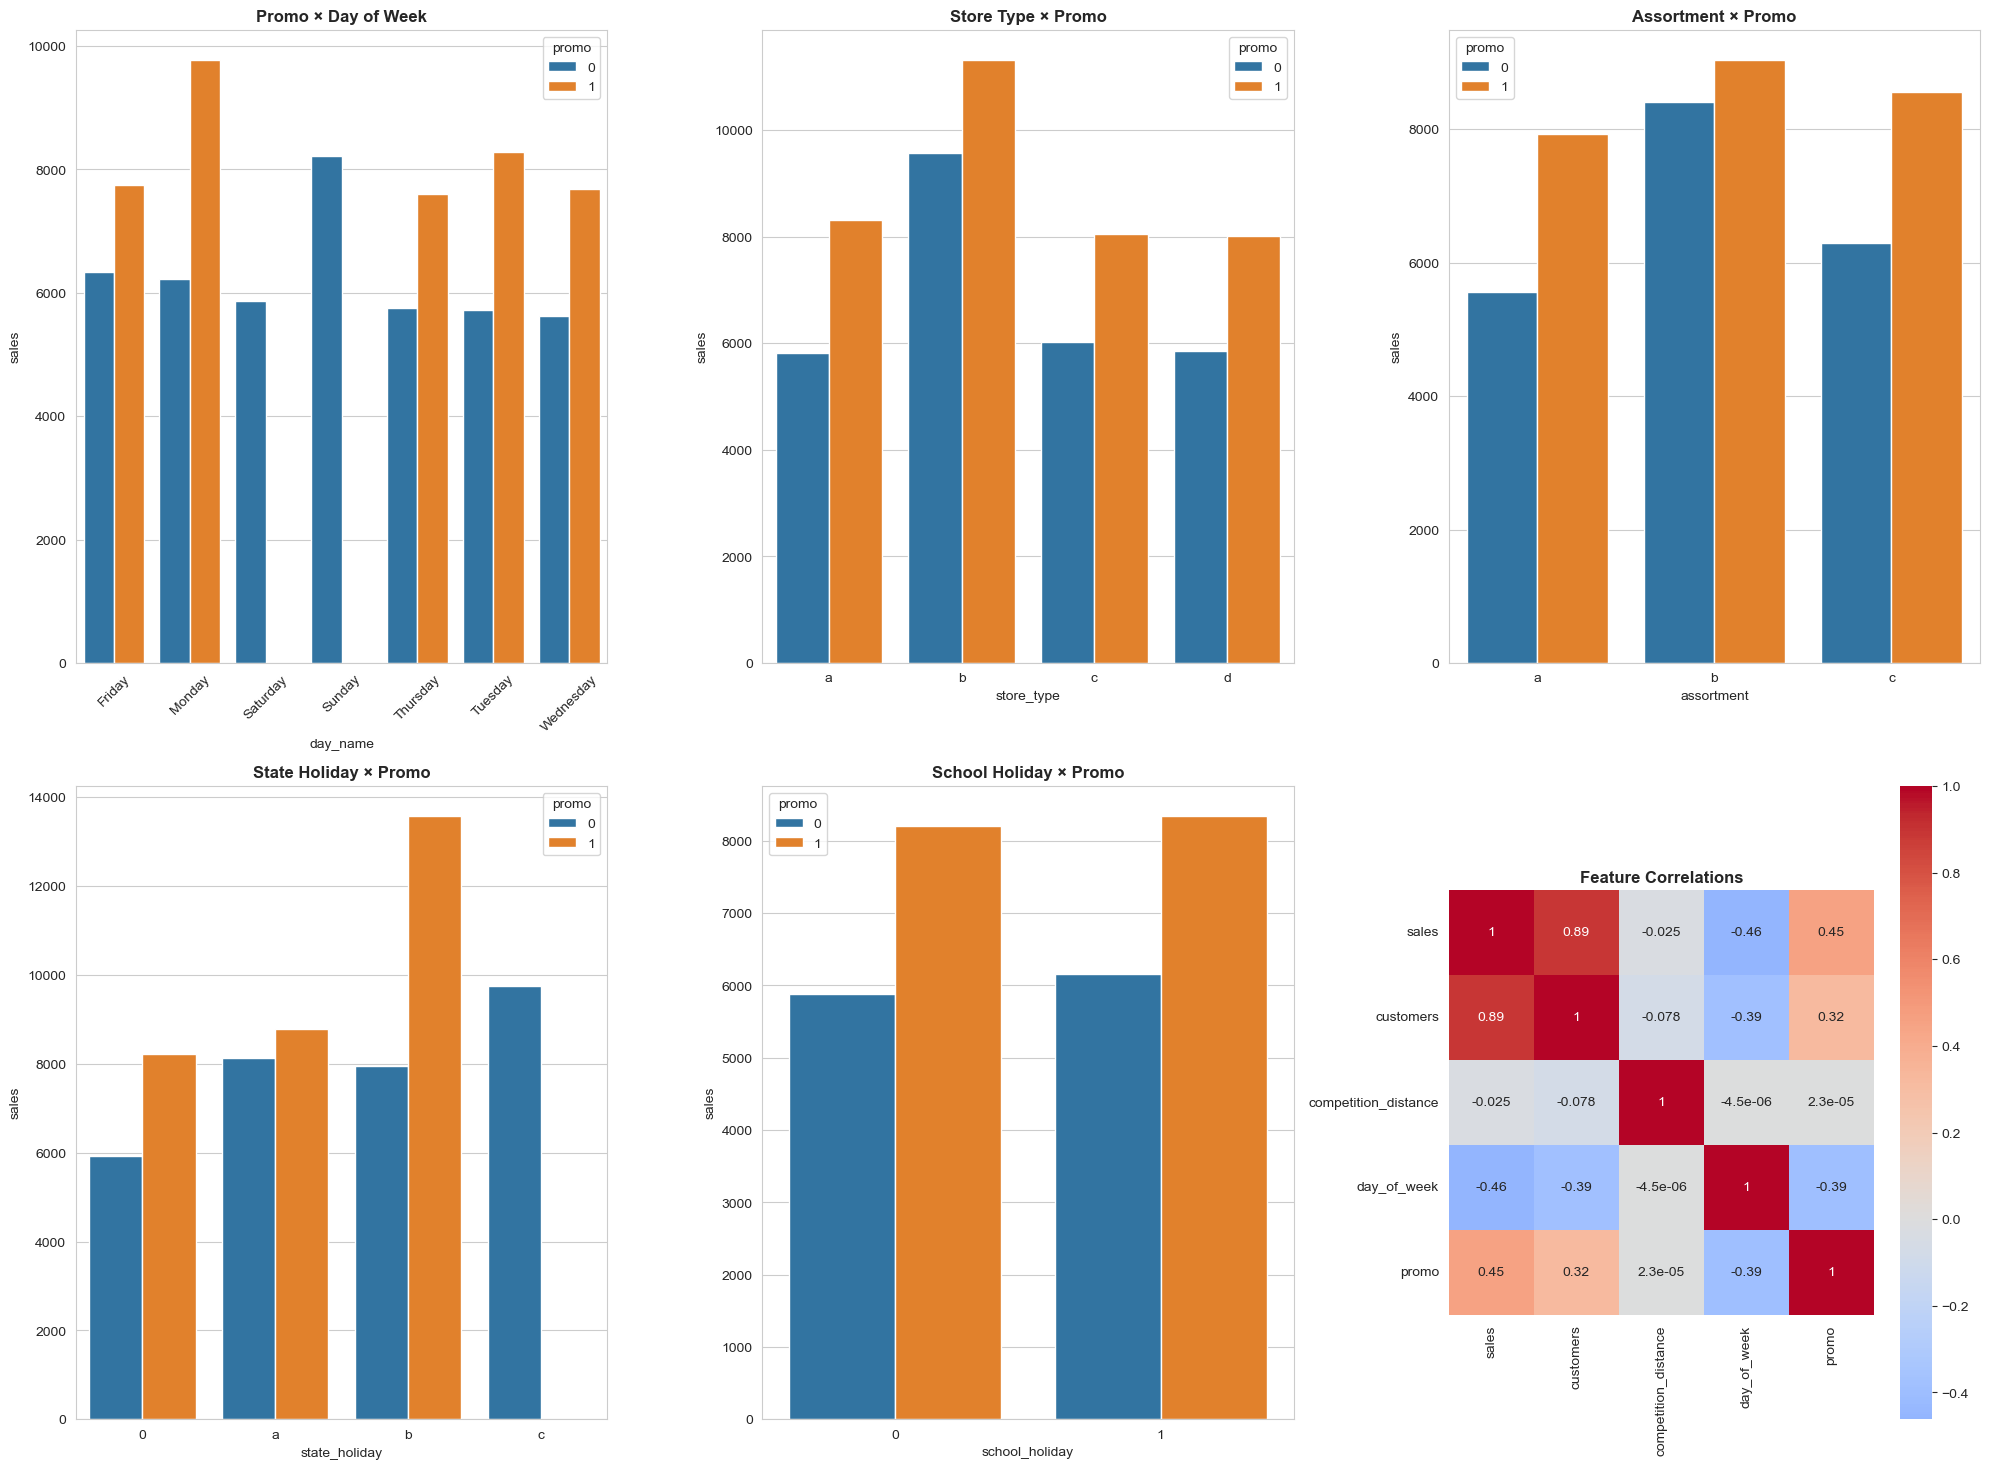

In [32]:
plt.figure(figsize=(20, 15))

# 1. Promo × Day of Week
plt.subplot(2, 3, 1)
df1['day_name'] = df1['date'].dt.day_name()
day_promo = df1[df1['sales'] > 0].groupby(['day_name', 'promo'])['sales'].mean().reset_index()
sns.barplot(x='day_name', y='sales', hue='promo', data=day_promo)
plt.title('Promo × Day of Week', fontweight='bold')
plt.xticks(rotation=45)

# 2. Store Type × Promo
plt.subplot(2, 3, 2)
store_promo = df1[df1['sales'] > 0].groupby(['store_type', 'promo'])['sales'].mean().reset_index()
sns.barplot(x='store_type', y='sales', hue='promo', data=store_promo)
plt.title('Store Type × Promo', fontweight='bold')

# 3. Assortment × Promo
plt.subplot(2, 3, 3)
assort_promo = df1[df1['sales'] > 0].groupby(['assortment', 'promo'])['sales'].mean().reset_index()
sns.barplot(x='assortment', y='sales', hue='promo', data=assort_promo)
plt.title('Assortment × Promo', fontweight='bold')

# 4. State Holiday × Promo
plt.subplot(2, 3, 4)
holiday_promo = df1[df1['sales'] > 0].groupby(['state_holiday', 'promo'])['sales'].mean().reset_index()
sns.barplot(x='state_holiday', y='sales', hue='promo', data=holiday_promo)
plt.title('State Holiday × Promo', fontweight='bold')

# 5. School Holiday × Promo
plt.subplot(2, 3, 5)
school_promo = df1[df1['sales'] > 0].groupby(['school_holiday', 'promo'])['sales'].mean().reset_index()
sns.barplot(x='school_holiday', y='sales', hue='promo', data=school_promo)
plt.title('School Holiday × Promo', fontweight='bold')

# 6. Correlation Heatmap
plt.subplot(2, 3, 6)
numeric_cols = ['sales', 'customers', 'competition_distance', 'day_of_week', 'promo']
corr_matrix = df1[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlations', fontweight='bold')

plt.tight_layout()
plt.savefig('./pictures/interactions_barcharts.png', dpi=300, bbox_inches='tight')
plt.show()

##### **1.2.4.6. Heatmap**

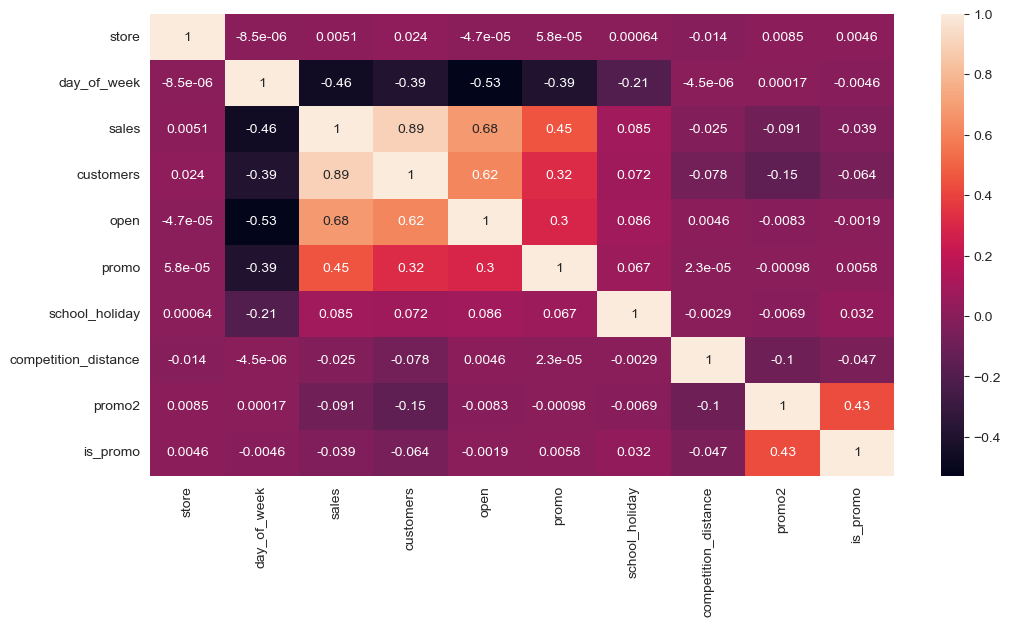

In [33]:
plt.figure(figsize=(12, 6))

correlation = num_attributes.corr()
sns.heatmap(correlation, annot=True)
plt.savefig('./pictures/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# **PHASE 2**

### **2.1 adding new features**

#### **2.1.1. Time Features**

In [34]:
df1['date'] = pd.to_datetime(df1['date'])
df1["day"] = df1['date'].dt.day
df1['month'] = df1['date'].dt.month
df1['day_of_week'] = df1['date'].dt.dayofweek  # 0=Monday, 6=Sunday
df1['quarter'] = df1['date'].dt.quarter
df1['week_of_year'] = df1['date'].dt.isocalendar().week
df1['day_of_year'] = df1['date'].dt.dayofyear

df1['is_weekend'] = (df1['day_of_week'] >= 5).astype(int)

df1['season'] = df1['month'].map({
    1: 'Winter', 2: 'Winter', 3: 'Spring',
    4: 'Spring', 5: 'Spring', 6: 'Summer',
    7: 'Summer', 8: 'Summer', 9: 'Fall',
    10: 'Fall', 11: 'Fall', 12: 'Winter'
})

df1['near_christmas'] = ((df1['month'] == 12) & (df1['day'] >= 20)).astype(int)
df1['near_new_year'] = (((df1['month'] == 12) & (df1['day'] >= 25)) | 
                         ((df1['month'] == 1) & (df1['day'] <= 7))).astype(int)

high_sales_months = [11, 12, 7, 8]  
df1['is_high_sales_month'] = df1['month'].isin(high_sales_months).astype(int)

df1['month_abbr'] = df1['date'].dt.month_name().str[:3]

def is_in_promo_interval(row):
    if pd.notna(row['promo_interval']):
        promo_months = str(row['promo_interval']).split(',')
        return 1 if row['month_abbr'] in promo_months else 0
    return 0

df1['is_promo_month'] = df1.apply(is_in_promo_interval, axis=1)


df1['competition_since'] = pd.to_datetime(
    df1['competition_open_since_year'].astype(str) + '-' + 
    df1['competition_open_since_month'].astype(str) + '-01', 
    errors='coerce'
)
df1['days_since_competition'] = (df1['date'] - df1['competition_since']).dt.days

def create_promo2_date(row):
    if pd.notna(row['promo2_since_year']) and pd.notna(row['promo2_since_week']):
        try:
            date_str = f"{int(row['promo2_since_year'])}-W{int(row['promo2_since_week'])}-1"
            return pd.to_datetime(date_str, format='%Y-W%W-%w', errors='coerce')
        except:
            return pd.NaT
    return pd.NaT

df1['promo2_start'] = df1.apply(create_promo2_date, axis=1)
df1['days_since_promo2'] = (df1['date'] - df1['promo2_start']).dt.days

first_date = df1['date'].min()
df1['days_from_start'] = (df1['date'] - first_date).dt.days

time_features = [
    'month',
    'day_of_week', 
    'quarter',
    'week_of_year',
    'day_of_year',
    'is_weekend',
    'season',
    'near_christmas',
    'near_new_year',
    'is_high_sales_month',
    'is_promo_month',
    'days_since_competition',
    'days_since_promo2',
    'days_from_start'
]

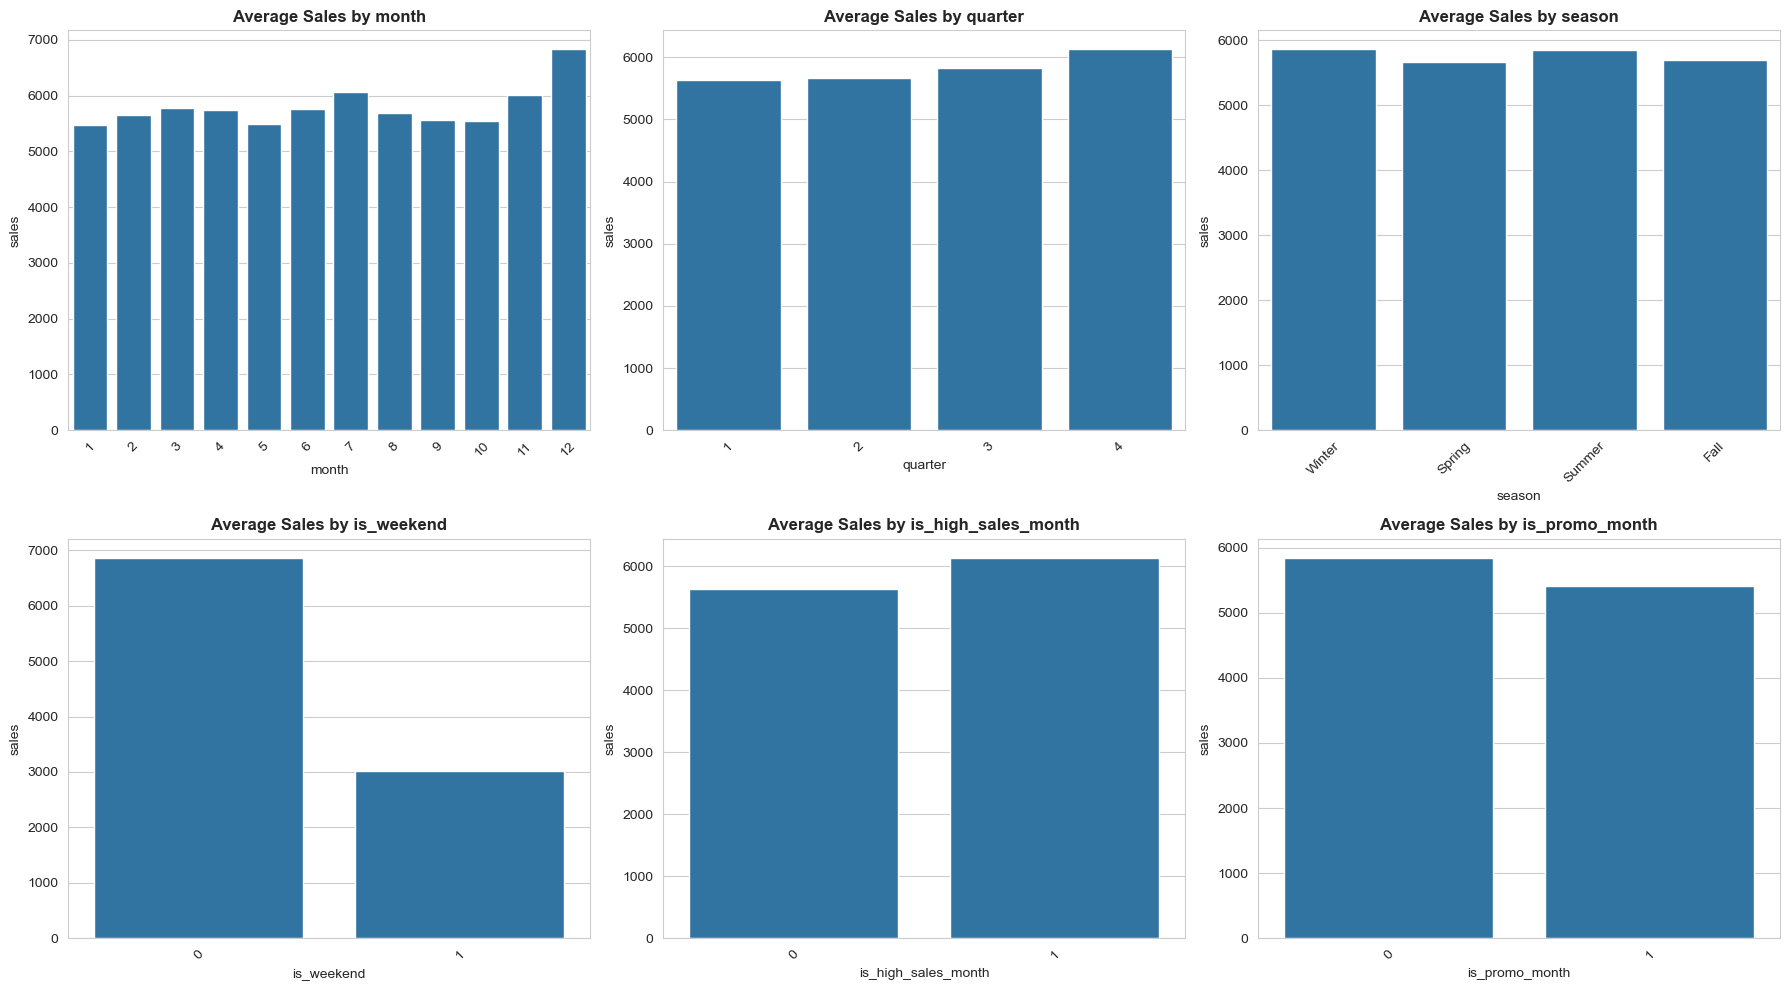

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

plot_features = ['month', 'quarter', 'season', 'is_weekend', 'is_high_sales_month', 'is_promo_month']

for idx, feature in enumerate(plot_features):
    if feature in df1.columns:
        avg_sales = df1.groupby(feature)['sales'].mean().reset_index()
        
        if feature == 'season':
            sns.barplot(x=feature, y='sales', data=avg_sales, ax=axes[idx], 
                       order=['Winter', 'Spring', 'Summer', 'Fall'])
        else:
            sns.barplot(x=feature, y='sales', data=avg_sales, ax=axes[idx])
        
        axes[idx].set_title(f'Average Sales by {feature}', fontweight='bold')
        axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('./pictures/phase2_Added_time_features.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo',
       'day_name', 'year', 'month', 'quarter', 'day', 'week_of_year',
       'day_of_year', 'is_weekend', 'season', 'near_christmas',
       'near_new_year', 'is_high_sales_month', 'month_abbr', 'is_promo_month',
       'competition_since', 'days_since_competition', 'promo2_start',
       'days_since_promo2', 'days_from_start'],
      dtype='object')

#### **2.1.2. Lag Features**

In [37]:
df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.sort_values(['store', 'date']).reset_index(drop=True)

df1['day'] = df1['date'].dt.day
df1['month'] = df1['date'].dt.month
df1['day_of_week'] = df1['date'].dt.dayofweek

# 1. Moving average 7
df1['sales_ma7'] = df1.groupby('store')['sales'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

# 2. Moving average 30
df1['sales_ma30'] = df1.groupby('store')['sales'].transform(
    lambda x: x.rolling(window=30, min_periods=1).mean()
)
df1 = df1.sort_values(['store', 'date'])
# 3. previous day sale
df1['sales_lag1'] = df1.groupby('store')['sales'].shift(1)

# 4. previous week sale
df1['sales_lag7'] = df1.groupby('store')['sales'].shift(7)

# 5. Sd 7
df1['sales_std7'] = df1.groupby('store')['sales'].transform(
    lambda x: x.rolling(window=7, min_periods=1).std().fillna(0)
)

# 6. sales to ma7 ratio
df1['sales_to_ma7_ratio'] = df1['sales'] / df1['sales_ma7'].replace(0, np.nan)
df1['sales_to_ma7_ratio'] = df1['sales_to_ma7_ratio'].fillna(1).replace([np.inf, -np.inf], 1)

# 7. sales per customer
if 'customers' in df1.columns:
    df1['sales_per_customer'] = df1['sales'] / df1['customers'].replace(0, np.nan)
    df1['sales_per_customer'] = df1['sales_per_customer'].fillna(df1['sales_per_customer'].median())

In [38]:
important_features = ['sales_ma7', 'sales_ma30', 'sales_lag1', 'sales_lag7', 'sales_std7', 'sales_to_ma7_ratio']
if 'sales_per_customer' in df1.columns:
    important_features.append('sales_per_customer')

display_cols = ['store', 'date', 'sales'] + important_features
print(df1[display_cols].head(10).to_string())

   store       date  sales    sales_ma7   sales_ma30  sales_lag1  sales_lag7   sales_std7  sales_to_ma7_ratio  sales_per_customer
0      1 2013-01-01      0     0.000000     0.000000         NaN         NaN     0.000000            1.000000            9.250000
1      1 2013-01-02   5530  2765.000000  2765.000000         0.0         NaN  3910.300500            2.000000            8.278443
2      1 2013-01-03   4327  3285.666667  3285.666667      5530.0         NaN  2908.351137            1.316932            7.486159
3      1 2013-01-04   4486  3585.750000  3585.750000      4327.0         NaN  2449.327306            1.251063            7.247173
4      1 2013-01-05   4997  3868.000000  3868.000000      4486.0         NaN  2213.081223            1.291882            7.869291
5      1 2013-01-06      0  3223.333333  3223.333333      4997.0         NaN  2532.144045            0.000000            9.250000
6      1 2013-01-07   7176  3788.000000  3788.000000         0.0         NaN  2752.283961 

In [39]:
# correlation of lag features and sales
for feature in important_features:
    if feature in df1.columns and feature != 'sales':
        corr = df1[feature].corr(df1['sales'])
        if pd.notna(corr):
            print(f"  {feature}: {corr:.3f}")

  sales_ma7: 0.576
  sales_ma30: 0.576
  sales_lag1: 0.278
  sales_lag7: 0.675
  sales_std7: 0.460
  sales_to_ma7_ratio: 0.745
  sales_per_customer: 0.168


### **2.2. Time-Based train, val, test Split**

In [40]:
df1 = df1.sort_values('date')

# Calculate split indices
train_size = int(0.7 * len(df1))
val_size = int(0.2 * len(df1))

train = df1.iloc[:train_size]
val = df1.iloc[train_size:train_size + val_size]
test = df1.iloc[train_size + val_size:]

print(f"Train: {train.shape} ({train['date'].min()} to {train['date'].max()})")
print(f"Val: {val.shape} ({val['date'].min()} to {val['date'].max()})")
print(f"Test: {test.shape} ({test['date'].min()} to {test['date'].max()})")

Train: (712046, 46) (2013-01-01 00:00:00 to 2014-10-19 00:00:00)
Val: (203441, 46) (2014-10-19 00:00:00 to 2015-05-01 00:00:00)
Test: (101722, 46) (2015-05-01 00:00:00 to 2015-07-31 00:00:00)


### **2.3. Standardization**

In [42]:
numerical_cols = [
    'sales', 'customers', 'competition_distance', 
    'days_since_competition', 'days_since_promo2', 'days_from_start',
    'sales_ma7', 'sales_ma30', 'sales_lag1', 'sales_lag7', 
    'sales_std7', 'sales_to_ma7_ratio', 'sales_per_customer'
]
numerical_cols = [col for col in numerical_cols if col in train.columns]


# Fit scaler ONLY on training data
scaler = StandardScaler()
scaler.fit(train[numerical_cols])

# Transform train, val, test
train_scaled = train.copy()
val_scaled = val.copy()
test_scaled = test.copy()

train_scaled[numerical_cols] = scaler.transform(train[numerical_cols])
val_scaled[numerical_cols] = scaler.transform(val[numerical_cols])
test_scaled[numerical_cols] = scaler.transform(test[numerical_cols])

print(f"Train mean (first col): {train_scaled[numerical_cols[0]].mean():.4f}")
print(f"Val mean (first col)  : {val_scaled[numerical_cols[0]].mean():.4f}")
print(f"Test mean (first col) : {test_scaled[numerical_cols[0]].mean():.4f}")

Train mean (first col): 0.0000
Val mean (first col)  : 0.0897
Test mean (first col) : 0.0814


In [ ]:
# df1.to_csv('./Datasets/df1.csv', index=False)
# train_scaled.to_csv('./Datasets/train_scaled.csv', index=False)
# val_scaled.to_csv('./Datasets/val_scaled.csv', index=False)
# test_scaled.to_csv('./Datasets/test_scaled.csv', index=False)

# **PHASE 3**

In [51]:
df1 = pd.read_csv('./Datasets/df1.csv', low_memory=False)
train_scaled = pd.read_csv('./Datasets/train_scaled.csv', low_memory=False)
val_scaled = pd.read_csv('./Datasets/val_scaled.csv', low_memory=False)
test_scaled = pd.read_csv('./Datasets/test_scaled.csv', low_memory=False)

### **3.1 BaseLine - Moving Average**

In [43]:
def moving_average_baseline(train, val, test, window=7):

    history = pd.concat([train, val]).sort_values('date')
    test = test.sort_values('date')
    non_zero_history = history[history['sales'] > 0]['sales'].tolist()

    predictions = []
    actuals = []

    for i in range(len(test)):

        if len(non_zero_history) >= window:
            pred = np.mean(non_zero_history[-window:])
        elif len(non_zero_history) > 0:
            pred = np.mean(non_zero_history)
        else:
            pred = 0 

        predictions.append(pred)

        actual = test.iloc[i]['sales']
        actuals.append(actual)

        if actual > 0:
            non_zero_history.append(actual)

    return np.array(predictions), np.array(actuals)


In [44]:
def calculate_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)

    # Avoid division by zero
    non_zero = y_true != 0
    if np.any(non_zero):
        mape = np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100
    else:
        mape = np.nan

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }


In [45]:
for window in [7, 14, 30]:
    pred, actual = moving_average_baseline(train_scaled, val_scaled, test_scaled, window)
    metrics = calculate_metrics(actual, pred)
    
    print(f"\nWindow = {window} days:")
    print(f"  MAE : {metrics['MAE']:.2f}")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")


Window = 7 days:
  MAE : 1.08
  RMSE: 1.51
  MAPE: 1212.80%

Window = 14 days:
  MAE : 1.03
  RMSE: 1.42
  MAPE: 1201.92%

Window = 30 days:
  MAE : 0.97
  RMSE: 1.29
  MAPE: 1213.90%


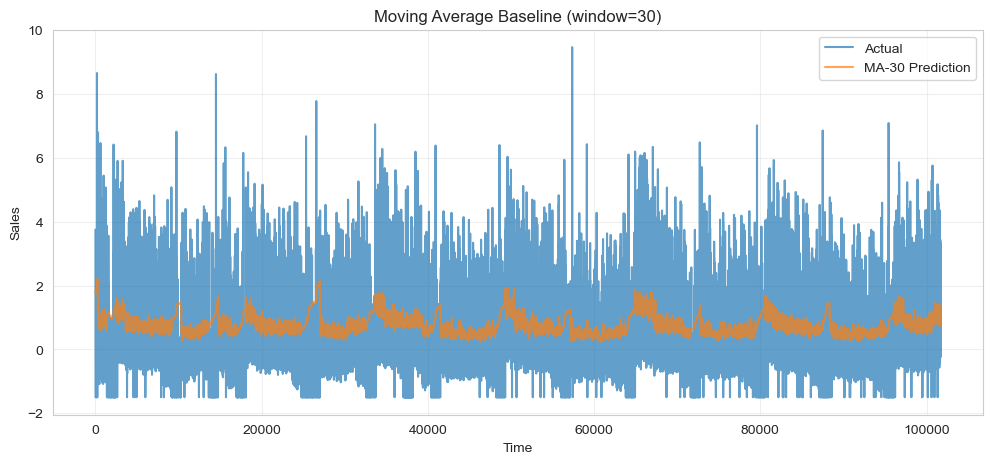

In [46]:
best_window = 30
pred, actual = moving_average_baseline(train_scaled, val_scaled, test_scaled, best_window)

plt.figure(figsize=(12, 5))
plt.plot(actual, label='Actual', alpha=0.7)
plt.plot(pred, label=f'MA-{best_window} Prediction', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title(f'Moving Average Baseline (window={best_window})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('./pictures/phase3_Moving_Average_Baseline.png', dpi=300, bbox_inches='tight')
plt.show()

### **3.2. XGBoost Regressor**

### **3.2.1. Encoding Data**

In [53]:
categorical_cols = ['store_type', 'assortment', 'state_holiday', 'season', 'day_of_week', 'month_map', 'month_abbr']
categorical_cols = [col for col in categorical_cols if col in df1.columns]

df_xgb_train = train_scaled.copy()
df_xgb_val = val_scaled.copy()
df_xgb_test = test_scaled.copy()

# Fit encoders ONLY on training data
label_encoders = {}

for col in categorical_cols:
    # Fit on training data only
    le = LabelEncoder()
    le.fit(train_scaled[col].astype(str))
    
    # Transform train, val, test
    df_xgb_train[col] = le.transform(train_scaled[col].astype(str))
    df_xgb_val[col] = le.transform(val_scaled[col].astype(str))
    df_xgb_test[col] = le.transform(test_scaled[col].astype(str))
    
    label_encoders[col] = le
    
    # Show mapping
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"\n  {col}:")
    for original, encoded in list(mapping.items())[:5]:  # Show first 5
        print(f"    {original} → {encoded}")

joblib.dump(label_encoders, 'label_encoders.pkl')


  store_type:
    a → 0
    b → 1
    c → 2
    d → 3

  assortment:
    a → 0
    b → 1
    c → 2

  state_holiday:
    0 → 0
    a → 1
    b → 2
    c → 3

  season:
    Fall → 0
    Spring → 1
    Summer → 2
    Winter → 3

  day_of_week:
    0 → 0
    1 → 1
    2 → 2
    3 → 3
    4 → 4

  month_map:
    Apr → 0
    Aug → 1
    Dec → 2
    Fev → 3
    Jan → 4

  month_abbr:
    Apr → 0
    Aug → 1
    Dec → 2
    Feb → 3
    Jan → 4


['label_encoders.pkl']

In [54]:
exclude = ['sales', 'date', 'store', 'promo_interval', 'month_abbr', 'competition_since', "promo2_start"]
feature_cols = [c for c in df_xgb_train.columns if c not in exclude]

X_train, y_train = df_xgb_train[feature_cols].values, df_xgb_train['sales'].values
X_val, y_val = df_xgb_val[feature_cols].values, df_xgb_val['sales'].values
X_test, y_test = df_xgb_test[feature_cols].values, df_xgb_test['sales'].values

### **3.2.2 Class XGboost**

In [ ]:
class Node:
    
    '''
    A node object that is recursivly called within itslef to construct a regression tree. Based on Tianqi Chen's XGBoost 
    the internal gain used to find the optimal split value uses both the gradient and hessian. Also a weighted quantlie sketch 
    and optimal leaf values all follow Chen's description in "XGBoost: A Scalable Tree Boosting System" the only thing not 
    implemented in this version is sparsity aware fitting or the ability to handle NA values with a default direction.

    Inputs
    ------------------------------------------------------------------------------------------------------------------
    x: pandas datframe of the training data
    gradient: negative gradient of the loss function
    hessian: second order derivative of the loss function
    idxs: used to keep track of samples within the tree structure
    subsample_cols: is an implementation of layerwise column subsample randomizing the structure of the trees
    (complexity parameter)
    min_leaf: minimum number of samples for a node to be considered a node (complexity parameter)
    min_child_weight: sum of the heassian inside a node is a meaure of purity (complexity parameter)
    depth: limits the number of layers in the tree
    lambda: L2 regularization term on weights. Increasing this value will make model more conservative.
    gamma: This parameter also prevents over fitting and is present in the the calculation of the gain (structure score). 
    As this is subtracted from the gain it essentially sets a minimum gain amount to make a split in a node.
    eps: This parameter is used in the quantile weighted skecth or 'approx' tree method roughly translates to 
    (1 / sketch_eps) number of bins

    Outputs
    --------------------------------------------------------------------------------------------------------------------
    A single tree object that will be used for gradient boosintg.
    '''

    def __init__(self, x, gradient, hessian, idxs, subsample_cols = 0.8 , min_leaf = 5, min_child_weight = 1 ,depth = 10, lambda_ = 1, gamma = 1, eps = 0.1):
      
        self.x, self.gradient, self.hessian = x, gradient, hessian
        self.idxs = idxs 
        self.depth = depth
        self.min_leaf = min_leaf
        self.lambda_ = lambda_
        self.gamma  = gamma
        self.min_child_weight = min_child_weight
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.subsample_cols = subsample_cols
        self.eps = eps
        self.column_subsample = np.random.permutation(self.col_count)[:round(self.subsample_cols*self.col_count)]
        
        self.val = self.compute_gamma(self.gradient[self.idxs], self.hessian[self.idxs])
          
        self.score = float('-inf')
        self.find_varsplit()
        
        
    def compute_gamma(self, gradient, hessian):
        '''
        Calculates the optimal leaf value equation (5) in "XGBoost: A Scalable Tree Boosting System"
        '''
        return(-np.sum(gradient)/(np.sum(hessian) + self.lambda_))
        
    def find_varsplit(self):
        '''
        Scans through every column and calcuates the best split point.
        The node is then split at this point and two new nodes are created.
        Depth is only parameter to change as we have added a new layer to tre structure.
        If no split is better than the score initalised at the begining then no splits further splits are made
        '''
        for c in self.column_subsample: self.find_greedy_split(c)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = Node(x = self.x, gradient = self.gradient, hessian = self.hessian, idxs = self.idxs[lhs], min_leaf = self.min_leaf, depth = self.depth-1, lambda_ = self.lambda_ , gamma = self.gamma, min_child_weight = self.min_child_weight, eps = self.eps, subsample_cols = self.subsample_cols)
        self.rhs = Node(x = self.x, gradient = self.gradient, hessian = self.hessian, idxs = self.idxs[rhs], min_leaf = self.min_leaf, depth = self.depth-1, lambda_ = self.lambda_ , gamma = self.gamma, min_child_weight = self.min_child_weight, eps = self.eps, subsample_cols = self.subsample_cols)
        
    def find_greedy_split(self, var_idx):
        '''
         For a given feature greedily calculates the gain at each split.
         Globally updates the best score and split point if a better split point is found
        '''
        x = self.x[self.idxs, var_idx]
        
        for r in range(self.row_count):
            lhs = x <= x[r]
            rhs = x > x[r]
            
            lhs_indices = np.nonzero(x <= x[r])[0]
            rhs_indices = np.nonzero(x > x[r])[0]
            if(rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf 
               or self.hessian[lhs_indices].sum() < self.min_child_weight
               or self.hessian[rhs_indices].sum() < self.min_child_weight): continue

            curr_score = self.gain(lhs, rhs)
            if curr_score > self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = x[r]
                
    def weighted_qauntile_sketch(self, var_idx):
        '''
        XGBOOST Mini-Version
        Yiyang "Joe" Zeng
        Is an approximation to the eact greedy approach faster for bigger datasets wher it is not feasible
        to calculate the gain at every split point. Uses equation (8) and (9) from "XGBoost: A Scalable Tree Boosting System"
        '''
        x = self.x[self.idxs, var_idx]
        hessian_ = self.hessian[self.idxs]
        df = pd.DataFrame({'feature':x,'hess':hessian_})
        
        df.sort_values(by=['feature'], ascending = True, inplace = True)
        hess_sum = df['hess'].sum() 
        df['rank'] = df.apply(lambda x : (1/hess_sum)*sum(df[df['feature'] < x['feature']]['hess']), axis=1)
        
        for row in range(df.shape[0]-1):
            # look at the current rank and the next ran
            rk_sk_j, rk_sk_j_1 = df['rank'].iloc[row:row+2]
            diff = abs(rk_sk_j - rk_sk_j_1)
            if(diff >= self.eps):
                continue
                
            split_value = (df['rank'].iloc[row+1] + df['rank'].iloc[row])/2
            lhs = x <= split_value
            rhs = x > split_value
            
            lhs_indices = np.nonzero(x <= split_value)[0]
            rhs_indices = np.nonzero(x > split_value)[0]
            if(rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf 
               or self.hessian[lhs_indices].sum() < self.min_child_weight
               or self.hessian[rhs_indices].sum() < self.min_child_weight): continue
                
            curr_score = self.gain(lhs, rhs)
            if curr_score > self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = split_value
                
    def gain(self, lhs, rhs):
        '''
        Calculates the gain at a particular split point bases on equation (7) from
        "XGBoost: A Scalable Tree Boosting System"
        '''
        gradient = self.gradient[self.idxs]
        hessian  = self.hessian[self.idxs]
        
        lhs_gradient = gradient[lhs].sum()
        lhs_hessian  = hessian[lhs].sum()
        
        rhs_gradient = gradient[rhs].sum()
        rhs_hessian  = hessian[rhs].sum()
        
        gain = 0.5 *( (lhs_gradient**2/(lhs_hessian + self.lambda_)) + (rhs_gradient**2/(rhs_hessian + self.lambda_)) - ((lhs_gradient + rhs_gradient)**2/(lhs_hessian + rhs_hessian + self.lambda_))) - self.gamma
        return(gain)
                
    @property
    def split_col(self):
        '''
        splits a column 
        '''
        return self.x[self.idxs , self.var_idx]
                
    @property
    def is_leaf(self):
        '''
        checks if node is a leaf
        '''
        return self.score == float('-inf') or self.depth <= 0                 

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])
    
    def predict_row(self, xi):
        if self.is_leaf:
            return(self.val)

        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.predict_row(xi)

    
class XGBoostTree:
    '''
    Wrapper class that provides a scikit learn interface to the recursive regression tree above
    
    Inputs
    ------------------------------------------------------------------------------------------------------------------
    x: pandas datframe of the training data
    gradient: negative gradient of the loss function
    hessian: second order derivative of the loss function
    idxs: used to keep track of samples within the tree structure
    subsample_cols: is an implementation of layerwise column subsample randomizing the structure of the trees
    (complexity parameter)
    min_leaf: minimum number of samples for a node to be considered a node (complexity parameter)
    min_child_weight: sum of the heassian inside a node is a meaure of purity (complexity parameter)
    depth: limits the number of layers in the tree
    lambda: L2 regularization term on weights. Increasing this value will make model more conservative.
    gamma: This parameter also prevents over fitting and is present in the the calculation of the gain (structure score). 
    As this is subtracted from the gain it essentially sets a minimum gain amount to make a split in a node.
    eps: This parameter is used in the quantile weighted skecth or 'approx' tree method roughly translates to 
    (1 / sketch_eps) number of bins
    
    Outputs
    --------------------------------------------------------------------------------------------------------------------
    A single tree object that will be used for gradient boosintg.
    
    '''
    def fit(self, x, gradient, hessian, subsample_cols = 0.8 , min_leaf = 5, min_child_weight = 1 ,depth = 10, lambda_ = 1, gamma = 1, eps = 0.1):
        self.dtree = Node(x, gradient, hessian, np.array(np.arange(len(x))), subsample_cols, min_leaf, min_child_weight, depth, lambda_, gamma, eps)
        return self
    
    def predict(self, X):
        return self.dtree.predict(X)
   
        
class XGBoostRegressor:
    '''
    Full application of the XGBoost algorithm as described in "XGBoost: A Scalable Tree Boosting System" for 
    regression.

    Inputs
    ------------------------------------------------------------------------------------------------------------------
    x: pandas datframe of the training data
    gradient: negative gradient of the loss function
    hessian: second order derivative of the loss function
    idxs: used to keep track of samples within the tree structure
    subsample_cols: is an implementation of layerwise column subsample randomizing the structure of the trees
    (complexity parameter)
    min_leaf: minimum number of samples for a node to be considered a node (complexity parameter)
    min_child_weight: sum of the heassian inside a node is a meaure of purity (complexity parameter)
    depth: limits the number of layers in the tree
    lambda: L2 regularization term on weights. Increasing this value will make model more conservative.
    gamma: This parameter also prevents over fitting and is present in the the calculation of the gain (structure score). 
    As this is subtracted from the gain it essentially sets a minimum gain amount to make a split in a node.
    eps: This parameter is used in the quantile weighted skecth or 'approx' tree method roughly translates to 
    (1 / sketch_eps) number of bins

    Outputs
    --------------------------------------------------------------------------------------------------------------------
    A single tree object that will be used for gradient boosintg.
    '''
    def __init__(self):
        self.estimators = []
    
    # first order gradient mean squared error
    @staticmethod
    def grad(preds, labels):
        return(2*(preds-labels))
    
    # second order gradient logLoss
    @staticmethod
    def hess(preds, labels):
        '''
        hessian of mean squared error is a constant value of two 
        returns an array of twos
        '''
        return(np.full((preds.shape[0], 1), 2).flatten().astype('float64'))
    
    
    def fit(self, X, y, subsample_cols = 0.8 , min_child_weight = 1, depth = 5, min_leaf = 5, learning_rate = 0.4, boosting_rounds = 5, lambda_ = 1.5, gamma = 1, eps = 0.1):
        self.X, self.y = X, y
        self.depth = depth
        self.subsample_cols = subsample_cols
        self.eps = eps
        self.min_child_weight = min_child_weight 
        self.min_leaf = min_leaf
        self.learning_rate = learning_rate
        self.boosting_rounds = boosting_rounds 
        self.lambda_ = lambda_
        self.gamma  = gamma
    
        self.base_pred = np.full((X.shape[0], 1), np.mean(y)).flatten().astype('float64')
    
        for booster in range(self.boosting_rounds):
            Grad = self.grad(self.base_pred, self.y)
            Hess = self.hess(self.base_pred, self.y)
            boosting_tree = XGBoostTree().fit(self.X, Grad, Hess, depth = self.depth, min_leaf = self.min_leaf, lambda_ = self.lambda_, gamma = self.gamma, eps = self.eps, min_child_weight = self.min_child_weight, subsample_cols = self.subsample_cols)
            self.base_pred += self.learning_rate * boosting_tree.predict(self.X)
            self.estimators.append(boosting_tree)
          
    def predict(self, X):
        pred = np.zeros(X.shape[0])
        
        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(X) 
          
        return np.full((X.shape[0], 1), np.mean(self.y)).flatten().astype('float64') + pred

In [51]:
model = XGBoostRegressor()
model.fit(
    X_train[:1000], y_train[:1000],
    subsample_cols=0.8,      # Column subsampling
    min_child_weight=1,       # Minimum sum of hessian
    depth=5,                  # Max tree depth
    min_leaf=5,               # Minimum samples per leaf
    learning_rate=0.1,        # Learning rate (eta)
    boosting_rounds=10,       # Number of trees
    lambda_=1.5,              # L2 regularization
    gamma=1,                  # Minimum loss reduction
    eps=0.1                   # For quantile sketch (not used in greedy)
)

C:\Users\mobile-erfan\AppData\Local\Temp\ipykernel_6800\210667259.py:81: RuntimeWarning: invalid value encountered in less_equal
  lhs = x <= x[r]
C:\Users\mobile-erfan\AppData\Local\Temp\ipykernel_6800\210667259.py:82: RuntimeWarning: invalid value encountered in greater
  rhs = x > x[r]
C:\Users\mobile-erfan\AppData\Local\Temp\ipykernel_6800\210667259.py:84: RuntimeWarning: invalid value encountered in less_equal
  lhs_indices = np.nonzero(x <= x[r])[0]
C:\Users\mobile-erfan\AppData\Local\Temp\ipykernel_6800\210667259.py:85: RuntimeWarning: invalid value encountered in greater
  rhs_indices = np.nonzero(x > x[r])[0]


In [52]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

def print_metrics(y_true, y_pred, name):
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    print(f"\n{name}:")
    print(f"  MAE : {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

train_metrics = print_metrics(y_train, y_train_pred, "TRAIN")
val_metrics = print_metrics(y_val, y_val_pred, "VALIDATION")
test_metrics = print_metrics(y_test, y_test_pred, "TEST")


TRAIN:
  MAE : 0.8000
  RMSE: 0.9781
  MAPE: 979.26%

VALIDATION:
  MAE : 0.8680
  RMSE: 1.0516
  MAPE: 960.21%

TEST:
  MAE : 0.8543
  RMSE: 1.0269
  MAPE: 1006.68%


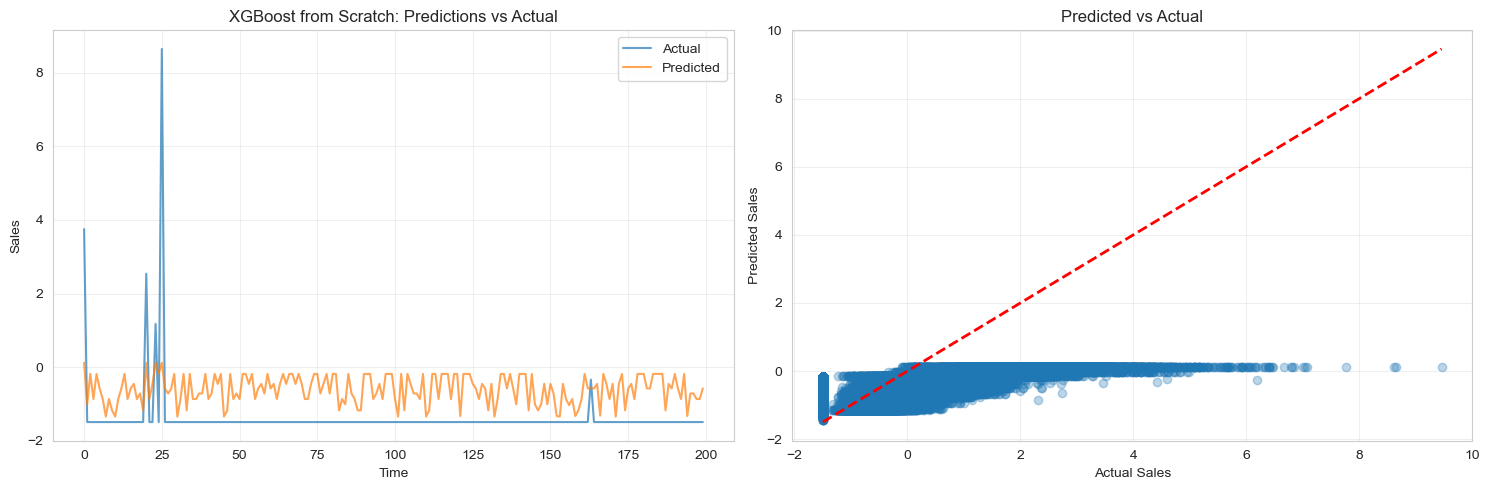

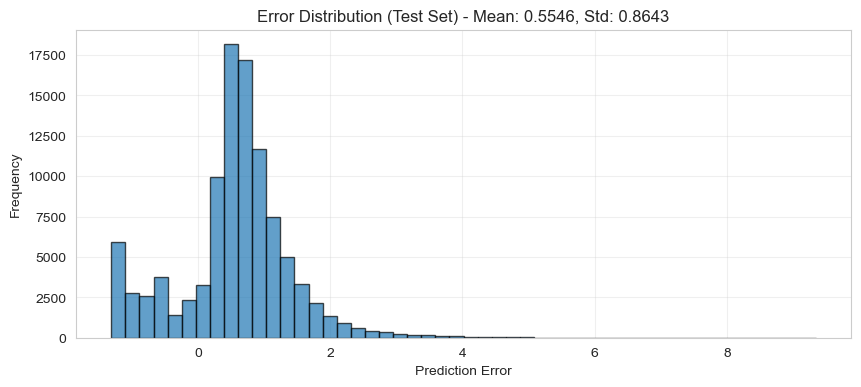

In [53]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(y_test[:200], label='Actual', alpha=0.7)
plt.plot(y_test_pred[:200], label='Predicted', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('XGBoost from Scratch: Predictions vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Predicted vs Actual')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
errors = y_test - y_test_pred
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title(f'Error Distribution (Test Set) - Mean: {errors.mean():.4f}, Std: {errors.std():.4f}')
plt.grid(True, alpha=0.3)
plt.savefig('./pictures/phase3_customXGB_on_1000.png', dpi=300, bbox_inches='tight')
plt.show()

### **3.2.3. Parameter tuning**

In [64]:
def hyperparameter_tuning_timeseries(X, y, param_grid, n_splits=3):
    best_score = np.inf
    best_params = None
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    
    from itertools import product
    for combination in product(*values):
        params = dict(zip(keys, combination))
        cv_scores = []
        
        for train_idx, val_idx in tscv.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = XGBoostRegressor()
            
            # Map parameter names
            fit_params = {
                'boosting_rounds': params.get('n_estimators', 100),
                'learning_rate': params.get('learning_rate', 0.1),
                'depth': params.get('max_depth', 5),
                'min_child_weight': params.get('min_child_weight', 1),
                'subsample_cols': params.get('subsample', 0.8),
                'lambda_': params.get('reg_lambda', 1.5),
                'gamma': params.get('gamma', 1)
            }
            
            model.fit(X_train, y_train, **fit_params)
            
            y_pred = model.predict(X_val)
            rmse = np.sqrt(np.mean((y_val - y_pred)**2))
            cv_scores.append(rmse)
        
        mean_score = np.mean(cv_scores)
        
        if mean_score < best_score:
            best_score = mean_score
            best_params = params
    
    return best_params

In [69]:
param_grid = {
    "n_estimators": [3, 8],
    "depth": [2, 4],
    "learning_rate": [0.1]
}

best_params = hyperparameter_tuning_timeseries(X_train[:100], y_train[:100], param_grid)

C:\Users\mobile-erfan\AppData\Local\Temp\ipykernel_6800\210667259.py:81: RuntimeWarning: invalid value encountered in less_equal
  lhs = x <= x[r]
C:\Users\mobile-erfan\AppData\Local\Temp\ipykernel_6800\210667259.py:82: RuntimeWarning: invalid value encountered in greater
  rhs = x > x[r]
C:\Users\mobile-erfan\AppData\Local\Temp\ipykernel_6800\210667259.py:84: RuntimeWarning: invalid value encountered in less_equal
  lhs_indices = np.nonzero(x <= x[r])[0]
C:\Users\mobile-erfan\AppData\Local\Temp\ipykernel_6800\210667259.py:85: RuntimeWarning: invalid value encountered in greater
  rhs_indices = np.nonzero(x > x[r])[0]


In [70]:
best_params

{'n_estimators': 3, 'depth': 2, 'learning_rate': 0.1}

In [72]:
final_model = XGBoostRegressor()

# Map best_params to fit parameters
fit_params = {
    'boosting_rounds': best_params.get('n_estimators', 100),
    'learning_rate': best_params.get('learning_rate', 0.1),
    'depth': best_params.get('max_depth', 5),
    'min_child_weight': best_params.get('min_child_weight', 1),
    'subsample_cols': best_params.get('subsample', 0.8),
    'lambda_': best_params.get('reg_lambda', 1.5),
    'gamma': best_params.get('gamma', 1)
}

final_model.fit(X_train[:1000], y_train[:1000], **fit_params)
y_pred = final_model.predict(X_val)

mae = np.mean(np.abs(y_val - y_pred))
mse = np.mean((y_val - y_pred) ** 2)
rmse = np.sqrt(mse)

print("\nFinal Evaluation:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")

C:\Users\mobile-erfan\AppData\Local\Temp\ipykernel_6800\210667259.py:81: RuntimeWarning: invalid value encountered in less_equal
  lhs = x <= x[r]
C:\Users\mobile-erfan\AppData\Local\Temp\ipykernel_6800\210667259.py:82: RuntimeWarning: invalid value encountered in greater
  rhs = x > x[r]
C:\Users\mobile-erfan\AppData\Local\Temp\ipykernel_6800\210667259.py:84: RuntimeWarning: invalid value encountered in less_equal
  lhs_indices = np.nonzero(x <= x[r])[0]
C:\Users\mobile-erfan\AppData\Local\Temp\ipykernel_6800\210667259.py:85: RuntimeWarning: invalid value encountered in greater
  rhs_indices = np.nonzero(x > x[r])[0]



Final Evaluation:
MAE  : 1.2685
MSE  : 2.2205
RMSE : 1.4901


### **3.2.4. XGBoost Using package (For comparison with the costum XGBoost)**

In [9]:
model = xgb.XGBRegressor(
    n_estimators=8,
    learning_rate=0.05,
    max_depth=2,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50,
    verbosity=0,
)
model.fit(X_train[:10], y_train[:10], eval_set=[(X_val[:10], y_val[:10])], verbose=1)
def print_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%")

print("\n" + "=" * 50)
print("Results")
print("=" * 50)
print_metrics(y_train, model.predict(X_train), "Train")
print_metrics(y_val, model.predict(X_val), "Val")
print_metrics(y_test, model.predict(X_test), "Test")

[0]	validation_0-rmse:0.00000
[1]	validation_0-rmse:0.00000
[2]	validation_0-rmse:0.00000
[3]	validation_0-rmse:0.00000
[4]	validation_0-rmse:0.00000
[5]	validation_0-rmse:0.00000
[6]	validation_0-rmse:0.00000
[7]	validation_0-rmse:0.00000

Results
Train: MAE=1.50, RMSE=1.80, MAPE=2624.95%
Val: MAE=1.59, RMSE=1.91, MAPE=2537.56%
Test: MAE=1.58, RMSE=1.88, MAPE=2765.25%


### **3.2.5. XGBoost Using package (Fitted on entire dataset)**

In [10]:
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50,
    verbosity=0
)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
def print_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%")

print("\n" + "=" * 50)
print("Results")
print("=" * 50)
print_metrics(y_train, model.predict(X_train), "Train")
print_metrics(y_val, model.predict(X_val), "Val")
print_metrics(y_test, model.predict(X_test), "Test")


imp = pd.DataFrame({'feature': feature_cols, 'importance': model.feature_importances_})
imp = imp.sort_values('importance', ascending=False).head(10)
print("\nTop 10 features:")
print(imp.to_string(index=False))


[0]	validation_0-rmse:1.01013
[100]	validation_0-rmse:0.04691
[200]	validation_0-rmse:0.03564
[300]	validation_0-rmse:0.03251
[400]	validation_0-rmse:0.03100
[500]	validation_0-rmse:0.02990
[600]	validation_0-rmse:0.02911
[700]	validation_0-rmse:0.02861
[800]	validation_0-rmse:0.02821
[900]	validation_0-rmse:0.02786
[999]	validation_0-rmse:0.02753

Results
Train: MAE=0.01, RMSE=0.02, MAPE=17.09%
Val: MAE=0.01, RMSE=0.03, MAPE=18.61%
Test: MAE=0.01, RMSE=0.03, MAPE=19.77%

Top 10 features:
           feature  importance
              open    0.521933
         customers    0.259151
         sales_ma7    0.048031
sales_to_ma7_ratio    0.043178
sales_per_customer    0.031982
        sales_std7    0.029023
        sales_lag1    0.020271
             promo    0.017769
       day_of_week    0.006789
        store_type    0.005667


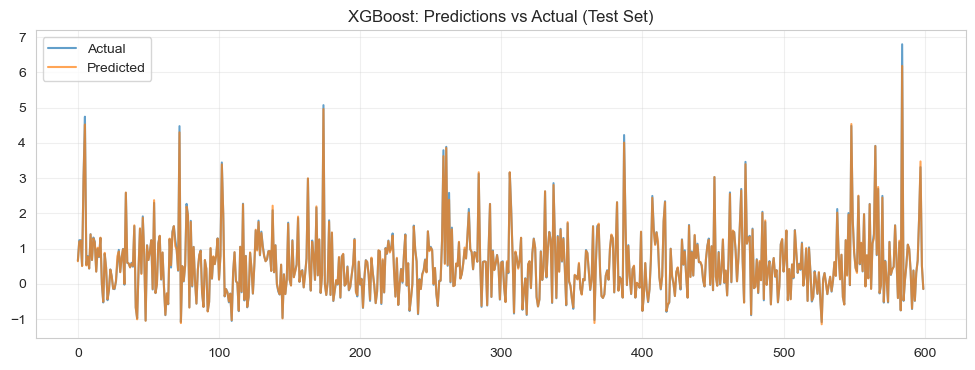

In [87]:
plt.figure(figsize=(12, 4))
plt.plot(y_test[400:1000], label='Actual', alpha=0.7)
plt.plot(model.predict(X_test)[400:1000], label='Predicted', alpha=0.7)
plt.legend()
plt.title('XGBoost: Predictions vs Actual (Test Set)')
plt.grid(True, alpha=0.3)
plt.savefig('./pictures/phase3_XGB_on_entire.png', dpi=300, bbox_inches='tight')
plt.show()

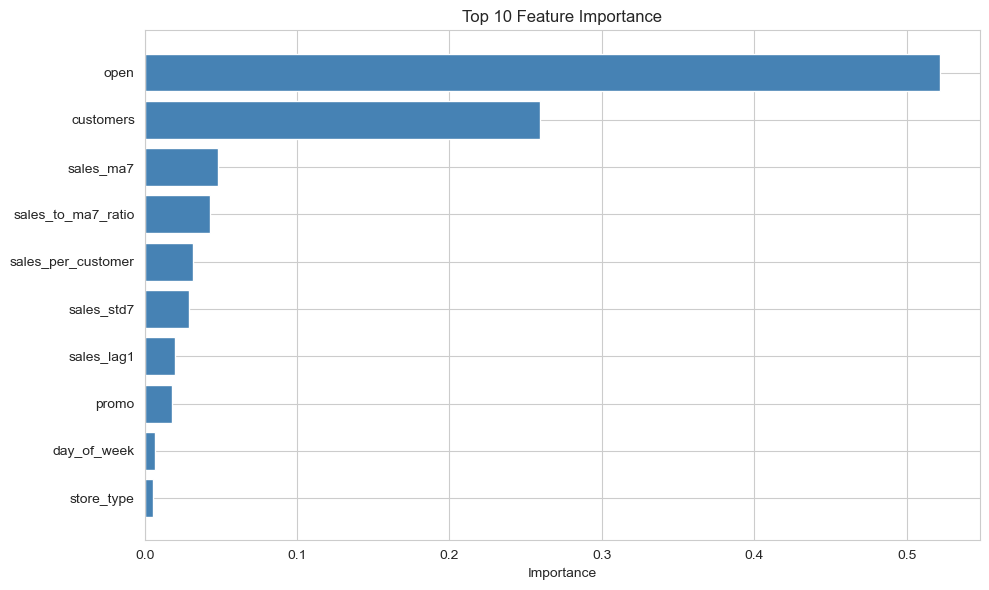

In [89]:
plt.figure(figsize=(10, 6))
plt.barh(imp['feature'], imp['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('./pictures/phase3_XGB_on_entire_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

#### **3.2.6. Error Analysis**


Error Statistics:
Train - Mean: -0.0000, Std: 0.0175
Val   - Mean: -0.0004, Std: 0.0275
Test  - Mean: 0.0003, Std: 0.0271


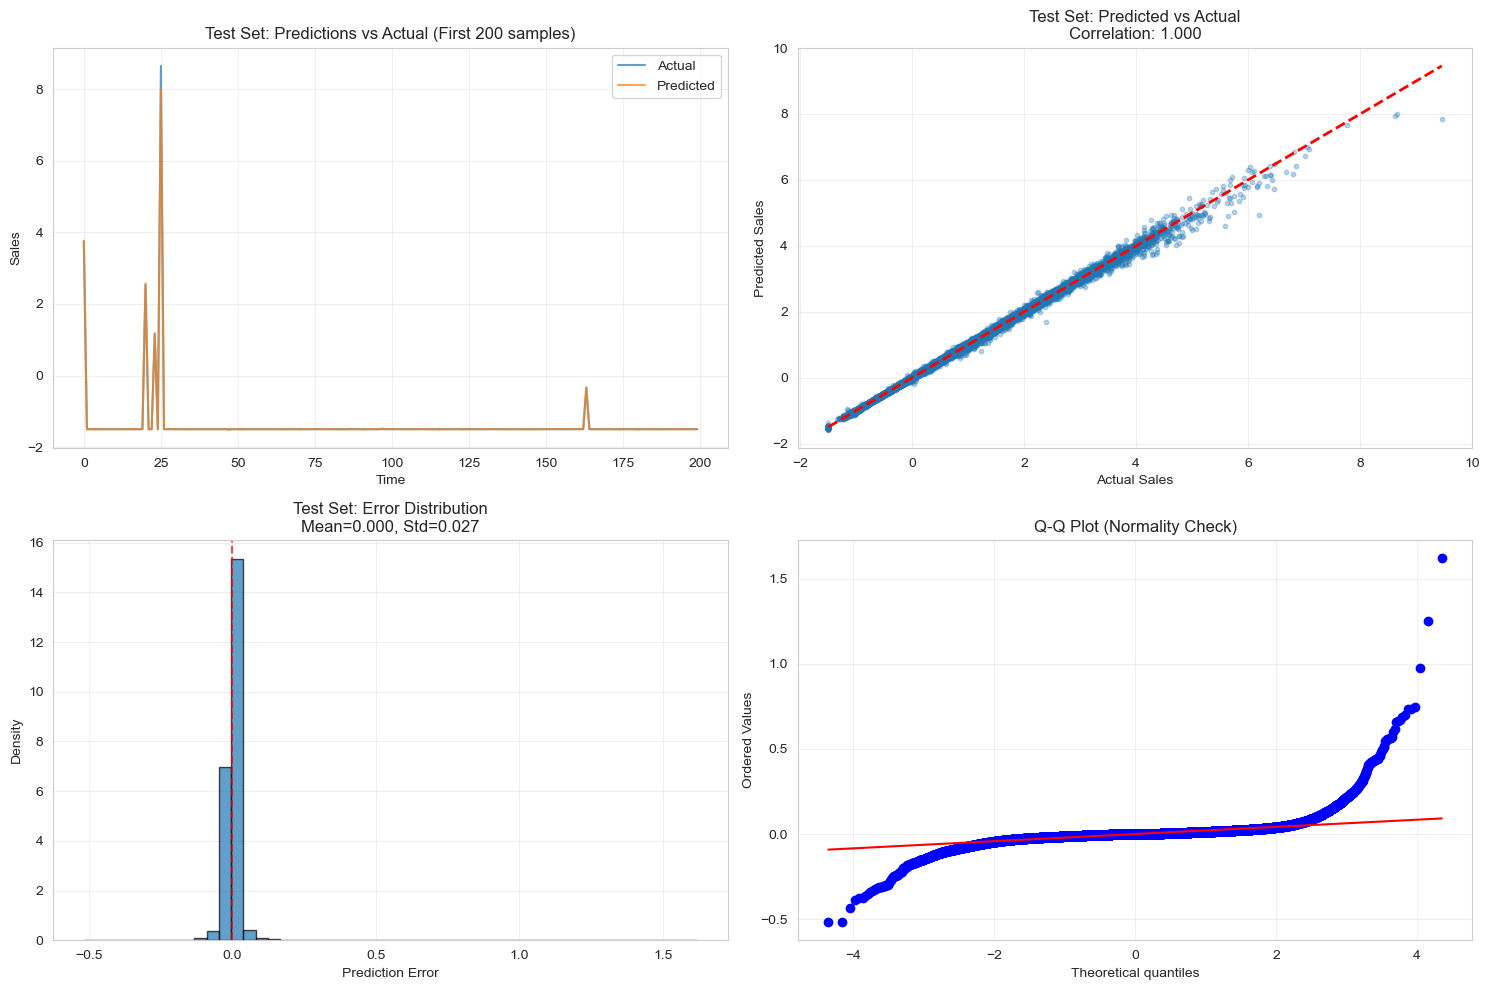

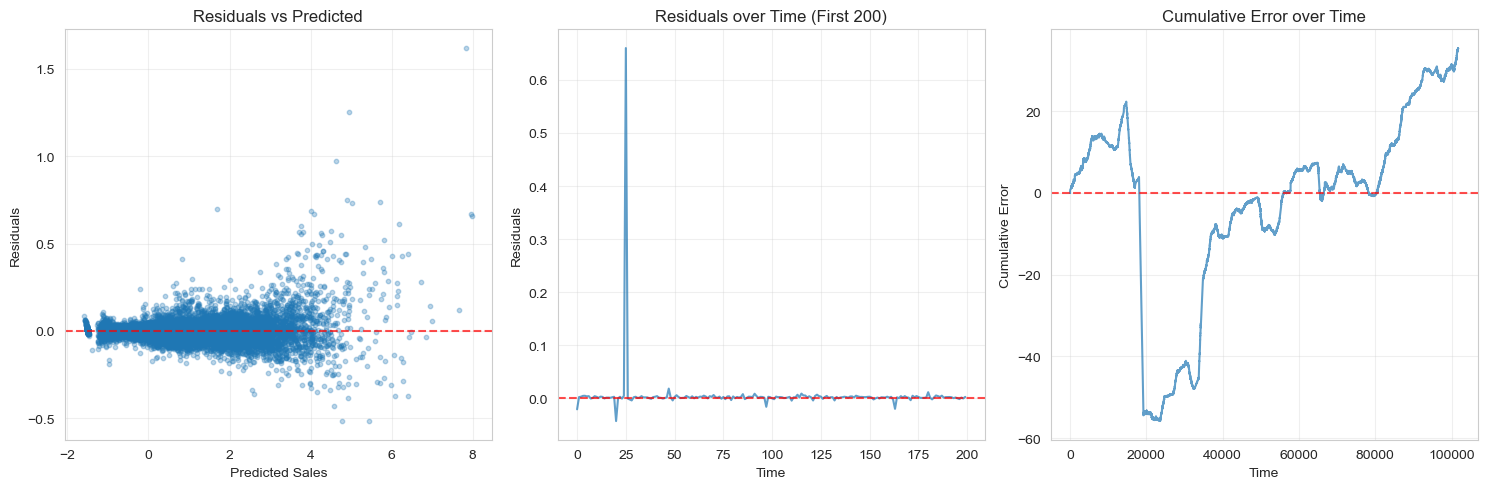

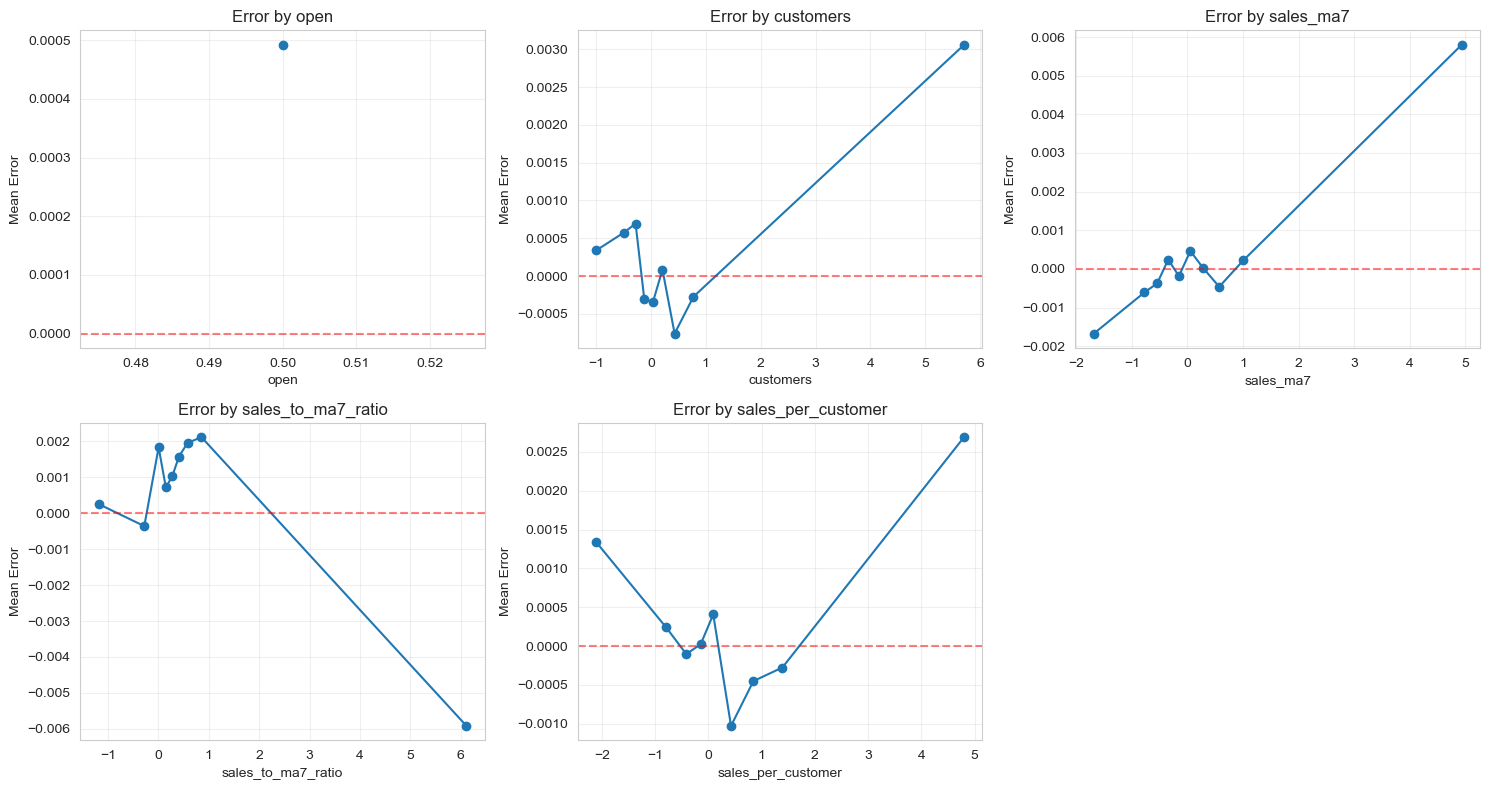


ERROR METRICS BY PREDICTION QUANTILE

Top 100% sales (>-1.50):
  MAE : 0.0131
  RMSE: 0.0271

Top 75% sales (>-0.45):
  MAE : 0.0161
  RMSE: 0.0309

Top 50% sales (>0.09):
  MAE : 0.0192
  RMSE: 0.0367

Top 25% sales (>0.65):
  MAE : 0.0261
  RMSE: 0.0490

Top 10% sales (>1.27):
  MAE : 0.0400
  RMSE: 0.0715

Top 5% sales (>1.73):
  MAE : 0.0563
  RMSE: 0.0954

Top 1% sales (>3.02):
  MAE : 0.1206
  RMSE: 0.1823

Results saved to 'prediction_errors.csv'


In [ ]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)
train_errors = y_train - y_train_pred
val_errors = y_val - y_val_pred
test_errors = y_test - y_test_pred

print(f"\nError Statistics:")
print(f"Train - Mean: {train_errors.mean():.4f}, Std: {train_errors.std():.4f}")
print(f"Val   - Mean: {val_errors.mean():.4f}, Std: {val_errors.std():.4f}")
print(f"Test  - Mean: {test_errors.mean():.4f}, Std: {test_errors.std():.4f}")

# Figure 1: Predictions vs Actual
plt.figure(figsize=(15, 10))

# Test set predictions
plt.subplot(2, 2, 1)
plt.plot(y_test[:200], label='Actual', alpha=0.7, linewidth=1.5)
plt.plot(y_test_pred[:200], label='Predicted', alpha=0.7, linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Test Set: Predictions vs Actual (First 200 samples)')
plt.legend()
plt.grid(True, alpha=0.3)

# Scatter plot
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Test Set: Predicted vs Actual\nCorrelation: {np.corrcoef(y_test, y_test_pred)[0,1]:.3f}')
plt.grid(True, alpha=0.3)

# Figure 2: Error Distribution
# Histogram of errors
plt.subplot(2, 2, 3)
plt.hist(test_errors, bins=50, edgecolor='black', alpha=0.7, density=True)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.title(f'Test Set: Error Distribution\nMean={test_errors.mean():.3f}, Std={test_errors.std():.3f}')
plt.grid(True, alpha=0.3)

# Q-Q plot for normality check
plt.subplot(2, 2, 4)
from scipy import stats
stats.probplot(test_errors, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Check)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./pictures/phase3_XGB_on_entire_Error_Analysis1.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 3: Residuals Analysis
plt.figure(figsize=(15, 5))

# Residuals vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test_pred, test_errors, alpha=0.3, s=10)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.grid(True, alpha=0.3)

# Residuals over time
plt.subplot(1, 3, 2)
plt.plot(test_errors[:200], alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals over Time (First 200)')
plt.grid(True, alpha=0.3)

# Cumulative error
plt.subplot(1, 3, 3)
plt.plot(np.cumsum(test_errors), alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Cumulative Error')
plt.title('Cumulative Error over Time')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./pictures/phase3_XGB_on_entire_Error_Analysis2.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 4: Error by Feature
# Get top features
top_features = imp.head(5)['feature']

plt.figure(figsize=(15, 8))

for i, feature in enumerate(top_features):
    plt.subplot(2, 3, i+1)
    
    # Create bins
    feature_values = X_test[:, feature_cols.index(feature)]
    bins = np.percentile(feature_values, np.linspace(0, 100, 11))
    bins_idx = np.digitize(feature_values, bins)
    
    # Calculate mean error per bin
    mean_errors = []
    bin_centers = []
    for j in range(1, len(bins)):
        mask = bins_idx == j
        if mask.sum() > 0:
            mean_errors.append(np.mean(test_errors[mask]))
            bin_centers.append((bins[j-1] + bins[j]) / 2)
    
    plt.plot(bin_centers, mean_errors, 'o-')
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Mean Error')
    plt.title(f'Error by {feature}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./pictures/phase3_XGB_on_entire_Error_Analysis3.png', dpi=300, bbox_inches='tight')
plt.show()


print("\n" + "=" * 60)
print("ERROR METRICS BY PREDICTION QUANTILE")
print("=" * 60)

quantiles = [0, 25, 50, 75, 90, 95, 99]
for q in quantiles:
    threshold = np.percentile(y_test, q)
    mask = y_test >= threshold if q > 0 else np.ones_like(y_test, dtype=bool)
    
    if mask.sum() > 0:
        mae_q = mean_absolute_error(y_test[mask], y_test_pred[mask])
        rmse_q = np.sqrt(mean_squared_error(y_test[mask], y_test_pred[mask]))
        print(f"\nTop {100-q}% sales (>{threshold:.2f}):")
        print(f"  MAE : {mae_q:.4f}")
        print(f"  RMSE: {rmse_q:.4f}")


results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Error': test_errors,
    'AbsError': np.abs(test_errors)
})
# results_df.to_csv('prediction_errors.csv', index=False)

### **3.2.7 Feature Importance analysis (SHAP)**

Due to the very high time complexity and the large number of features, this section has been run on a very small subset to only show the work process and the output provided is not correct.

  0%|          | 0/10 [00:00<?, ?it/s]

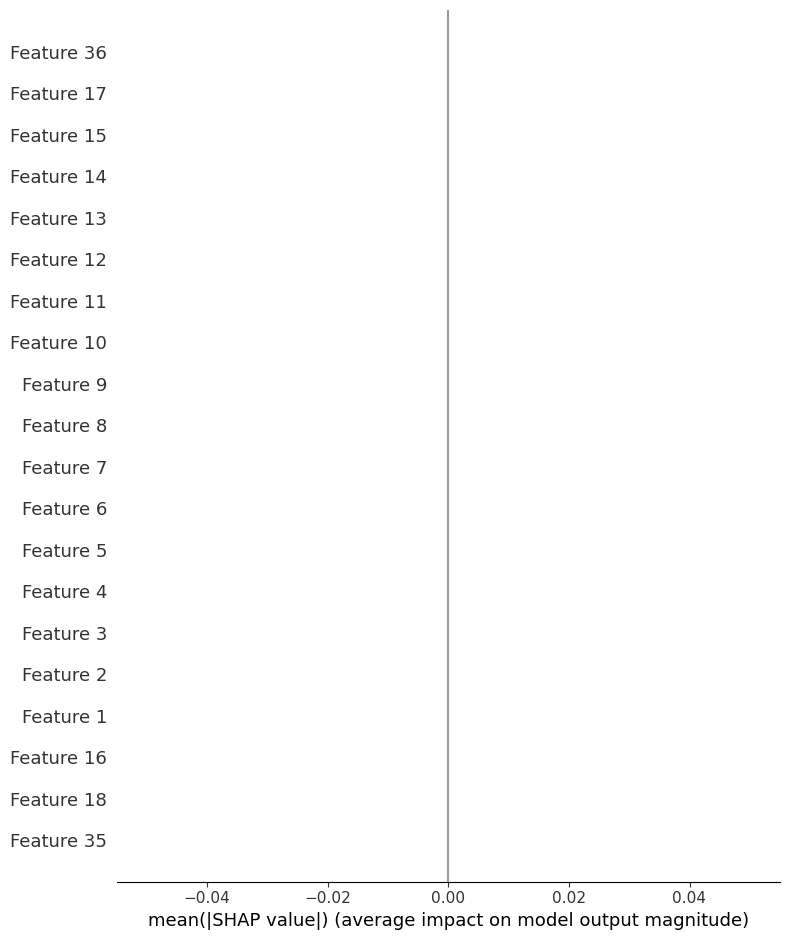

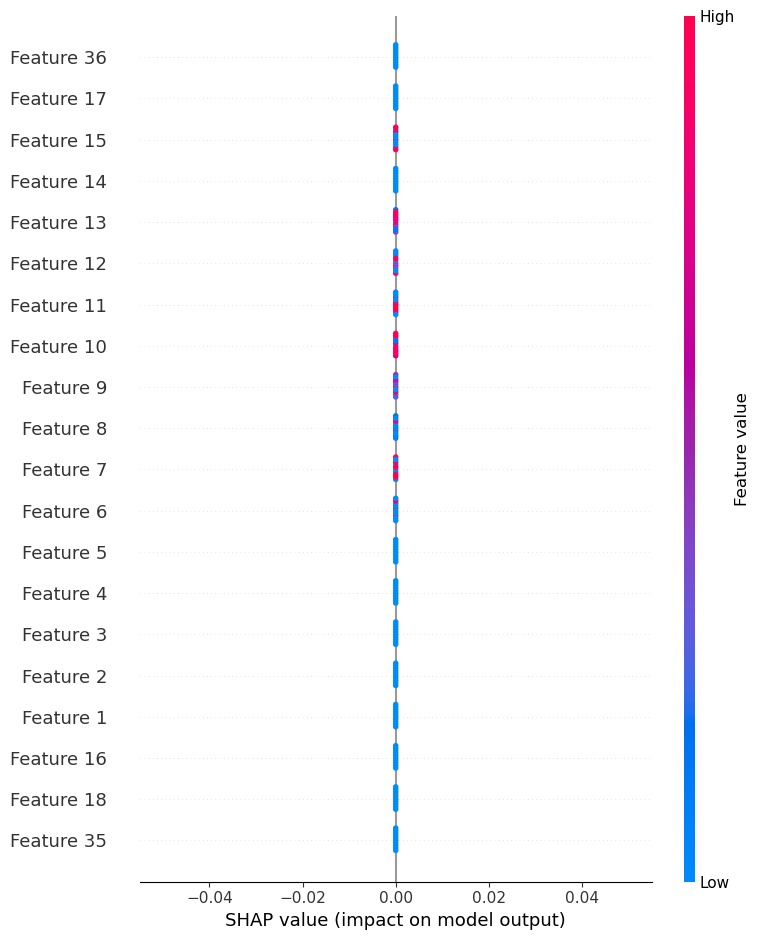

In [ ]:
X_train_sub = X_train[10:200]
y_train_sub = y_train[10:200]

model = xgb.XGBRegressor(
    n_estimators=3,
    max_depth=2,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

model.fit(X_train_sub, y_train_sub)

def model_predict(x):
    return model.predict(x)

explainer = shap.KernelExplainer(model_predict, X_train_sub) 
shap_values = explainer.shap_values(X_train_sub)

shap.summary_plot(shap_values, X_train_sub, plot_type="bar", show=True)
shap.summary_plot(shap_values, X_train_sub, show=True)

# **PHASE 4**

### **4.1 Multi-Step Forcasting(7 Day)**

#### **4.1.1. Recursive Multi-step Forecasting**

In [11]:
class MultiStepForecaster:
    """
    Multi-step time series forecasting with error propagation management
    """
    
    def __init__(self, model, horizon=7):
        """
        Parameters:
        -----------
        model : trained XGBoost model
        horizon : int, number of steps to forecast (default=7)
        """
        self.model = model
        self.horizon = horizon
        
    def predict_recursive(self, X_last, n_steps):
        """
        Recursive prediction (error propagates)
        """
        predictions = []
        current_input = X_last.copy()
        
        for step in range(n_steps):
            # Predict next step
            pred = self.model.predict(current_input.reshape(1, -1))[0]
            predictions.append(pred)
            
            # Update input for next prediction (shift lags)
            current_input = np.roll(current_input, 1)
            current_input[0] = pred
            
        return np.array(predictions)
    
    def predict_with_uncertainty(self, X_last, n_iterations=100):
        """
        Monte Carlo for uncertainty estimation
        """
        predictions = []
        
        for _ in range(n_iterations):
            # Add small noise to simulate uncertainty
            noisy_input = X_last + np.random.normal(0, 0.01 * np.abs(X_last).mean(), X_last.shape)
            pred = self.predict_recursive(noisy_input, self.horizon)
            predictions.append(pred)
        
        predictions = np.array(predictions)
        
        # Calculate statistics
        mean_pred = np.mean(predictions, axis=0)
        std_pred = np.std(predictions, axis=0)
        lower_bound = mean_pred - 1.96 * std_pred
        upper_bound = mean_pred + 1.96 * std_pred
        
        return mean_pred, lower_bound, upper_bound, std_pred
    
    def forecast_next_7_days(self, last_sequence, actual_future=None):
        """
        Forecast next 7 days with error analysis
        """
        print("=" * 60)
        print(" 7-DAY FORECAST WITH ERROR PROPAGATION")
        print("=" * 60)
        
        # Get predictions with uncertainty
        mean_pred, lower, upper, std = self.predict_with_uncertainty(last_sequence)
        
        # Create results DataFrame
        days = [f"Day {i+1}" for i in range(self.horizon)]
        results = pd.DataFrame({
            'Day': days,
            'Forecast': mean_pred,
            'Lower_CI': lower,
            'Upper_CI': upper,
            'Std_Error': std
        })
        
        # If actual values are provided, calculate errors
        if actual_future is not None:
            results['Actual'] = actual_future[:self.horizon]
            results['Error'] = results['Actual'] - results['Forecast']
            results['Abs_Error'] = np.abs(results['Error'])
            results['MAPE'] = np.abs(results['Error'] / (results['Actual'] + 1e-8)) * 100
            
            # Cumulative error
            results['Cumulative_Error'] = results['Error'].cumsum()
            results['Cumulative_MAPE'] = np.cumsum(np.abs(results['Error'])) / np.arange(1, self.horizon+1) / (results['Actual'] + 1e-8) * 100
        
        return results
    
    def plot_forecast(self, results):
        """
        Plot forecast with confidence intervals
        """
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Forecast with confidence intervals
        plt.subplot(2, 2, 1)
        days = np.arange(1, self.horizon + 1)
        
        plt.plot(days, results['Forecast'], 'b-o', label='Forecast', linewidth=2)
        plt.fill_between(days, results['Lower_CI'], results['Upper_CI'], 
                         alpha=0.3, color='blue', label='95% CI')
        
        if 'Actual' in results.columns:
            plt.plot(days, results['Actual'], 'r--s', label='Actual', linewidth=2)
            plt.title('7-Day Forecast with 95% CI')
        else:
            plt.title('7-Day Forecast with 95% Confidence Intervals')
        
        plt.xlabel('Day')
        plt.ylabel('Sales')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Error propagation
        if 'Actual' in results.columns:
            plt.subplot(2, 2, 2)
            plt.plot(days, results['Error'], 'ro-', label='Error')
            plt.plot(days, results['Cumulative_Error'], 'b--s', label='Cumulative Error')
            plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
            plt.xlabel('Day')
            plt.ylabel('Error')
            plt.title('Error Propagation Over 7 Days')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            # Plot 3: MAPE over time
            plt.subplot(2, 2, 3)
            plt.plot(days, results['MAPE'], 'go-', label='Daily MAPE')
            plt.plot(days, results['Cumulative_MAPE'], 'm--s', label='Cumulative MAPE')
            plt.xlabel('Day')
            plt.ylabel('MAPE (%)')
            plt.title('MAPE Propagation')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        # Plot 4: Uncertainty distribution
        plt.subplot(2, 2, 4)
        plt.bar(days, results['Std_Error'], alpha=0.7)
        plt.xlabel('Day')
        plt.ylabel('Standard Error')
        plt.title('Uncertainty Increases with Horizon')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('./pictures/phase4_MultiStepForcasting.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def evaluate_forecast(self, results):
        """
        Comprehensive evaluation of multi-step forecast
        """
        print("\n" + "=" * 60)
        print("📊 MULTI-STEP FORECAST EVALUATION")
        print("=" * 60)
        
        if 'Actual' not in results.columns:
            print("No actual values for evaluation")
            return
        
        # Overall metrics
        mae = results['Abs_Error'].mean()
        rmse = np.sqrt((results['Error'] ** 2).mean())
        mape = results['MAPE'].mean()
        
        print(f"\nOverall Metrics (All 7 days):")
        print(f"  MAE : {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAPE: {mape:.2f}%")
        
        # Step-wise metrics
        print(f"\nStep-wise Metrics:")
        for i in range(self.horizon):
            print(f"  Day {i+1}: MAE={results['Abs_Error'].iloc[i]:.4f}, "
                  f"MAPE={results['MAPE'].iloc[i]:.2f}%, "
                  f"Uncertainty=±{1.96 * results['Std_Error'].iloc[i]:.4f}")
        
        # Error propagation rate
        if results['Error'].iloc[0] != 0:
            error_propagation = results['Cumulative_Error'].iloc[-1] / results['Error'].iloc[0]
            print(f"\nError Propagation Rate: {error_propagation:.2f}x")
        
        # Uncertainty growth
        uncertainty_growth = results['Std_Error'].iloc[-1] / results['Std_Error'].iloc[0]
        print(f"Uncertainty Growth Rate: {uncertainty_growth:.2f}x")


In [12]:
def multi_window_forecast(model, X_test, y_test, n_windows=5):
    """
    Perform 7-day forecast on multiple windows of test data
    
    Parameters:
    -----------
    model : trained XGBoost model
    X_test : numpy array of test features
    y_test : numpy array of test targets
    n_windows : number of windows to forecast (default=5)
    """    
    all_results = []
    
    # Create multiple windows (every 7 days)
    for i in range(min(n_windows, len(X_test) // 7)):
        start_idx = len(X_test) - (7 * (i + 1))
        
        if start_idx < 0:
            break
            
        last_sequence = X_test[start_idx]
        actual_next_7 = y_test[start_idx:start_idx + 7]
        

        if len(actual_next_7) < 7:
            continue
        
        # Make predictions
        predictions = []
        current_input = last_sequence.copy()
        
        for day in range(7):
            pred = model.predict(current_input.reshape(1, -1))[0]
            predictions.append(pred)
            current_input = np.roll(current_input, 1)
            current_input[0] = pred
        
        predictions = np.array(predictions)
        
        # Calculate metrics
        mae = np.mean(np.abs(actual_next_7 - predictions))
        rmse = np.sqrt(np.mean((actual_next_7 - predictions) ** 2))
        mape = np.mean(np.abs((actual_next_7 - predictions) / (actual_next_7 + 1e-8))) * 100
        
        all_results.append({
            'window': i + 1,
            'start_idx': start_idx,
            'predictions': predictions,
            'actual': actual_next_7,
            'mae': mae,
            'rmse': rmse,
            'mape': mape
        })
        
        print(f"\nWindow {i+1} (starting at index {start_idx}):")
        print(f"  Actual values: {actual_next_7}")
        print(f"  Predictions  : {predictions}")
        print(f"  MAE : {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAPE: {mape:.2f}%")
    
    if len(all_results) == 0:
        print("No valid windows found!")
        return all_results
    
    # Average metrics across windows
    avg_mae = np.mean([r['mae'] for r in all_results])
    avg_rmse = np.mean([r['rmse'] for r in all_results])
    avg_mape = np.mean([r['mape'] for r in all_results])
    
    print("\n" + "=" * 60)
    print("AVERAGE ACROSS ALL WINDOWS")
    print("=" * 60)
    print(f"Average MAE : {avg_mae:.4f}")
    print(f"Average RMSE: {avg_rmse:.4f}")
    print(f"Average MAPE: {avg_mape:.2f}%")
    
    return all_results

def plot_multi_window_forecast(all_results):
    """Plot forecasts for multiple windows"""
    if len(all_results) == 0:
        print("No results to plot")
        return
        
    n_windows = len(all_results)
    
    plt.figure(figsize=(15, 5 * n_windows))
    
    for i, result in enumerate(all_results):
        plt.subplot(n_windows, 1, i + 1)
        
        days = np.arange(1, 8)
        plt.plot(days, result['actual'], 'r--s', label='Actual', linewidth=2, markersize=8)
        plt.plot(days, result['predictions'], 'b-o', label='Forecast', linewidth=2, markersize=8)
        
        plt.xlabel('Day')
        plt.ylabel('Sales')
        plt.title(f'Window {result["window"]} (MAE={result["mae"]:.2f}, MAPE={result["mape"]:.1f}%)')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('./pictures/phase4_MultiStepForcasting_5previous_window.png', dpi=300, bbox_inches='tight')
    plt.show()


 7-DAY FORECAST WITH ERROR PROPAGATION

Forecast Results:
  Day  Forecast  Lower_CI  Upper_CI  Std_Error   Actual     Error  Abs_Error       MAPE  Cumulative_Error  Cumulative_MAPE
Day 1  0.704933 -1.942608  3.352474   1.350786  3.74978  3.044847   3.044847  81.200681          3.044847        81.200681
Day 2  2.978391  0.339854  5.616929   1.346193 -1.49604 -4.474432   4.474432 299.084987         -1.429584      -251.306043
Day 3  1.017912 -1.202731  3.238554   1.132981 -1.49604 -2.513952   2.513952 168.040389         -3.943536      -223.550825
Day 4  1.787828 -0.003257  3.578913   0.913819 -1.49604 -3.283868   3.283868 219.503991         -7.227404      -222.539117
Day 5  1.099853 -0.888108  3.087813   1.014266 -1.49604 -2.595893   2.595893 173.517590         -9.823297      -212.734811
Day 6  1.811173 -0.321804  3.944151   1.088254 -1.49604 -3.307214   3.307214 221.064492        -13.130511      -214.123091
Day 7  2.031502 -0.284123  4.347128   1.181441 -1.49604 -3.527543   3.527543 235.

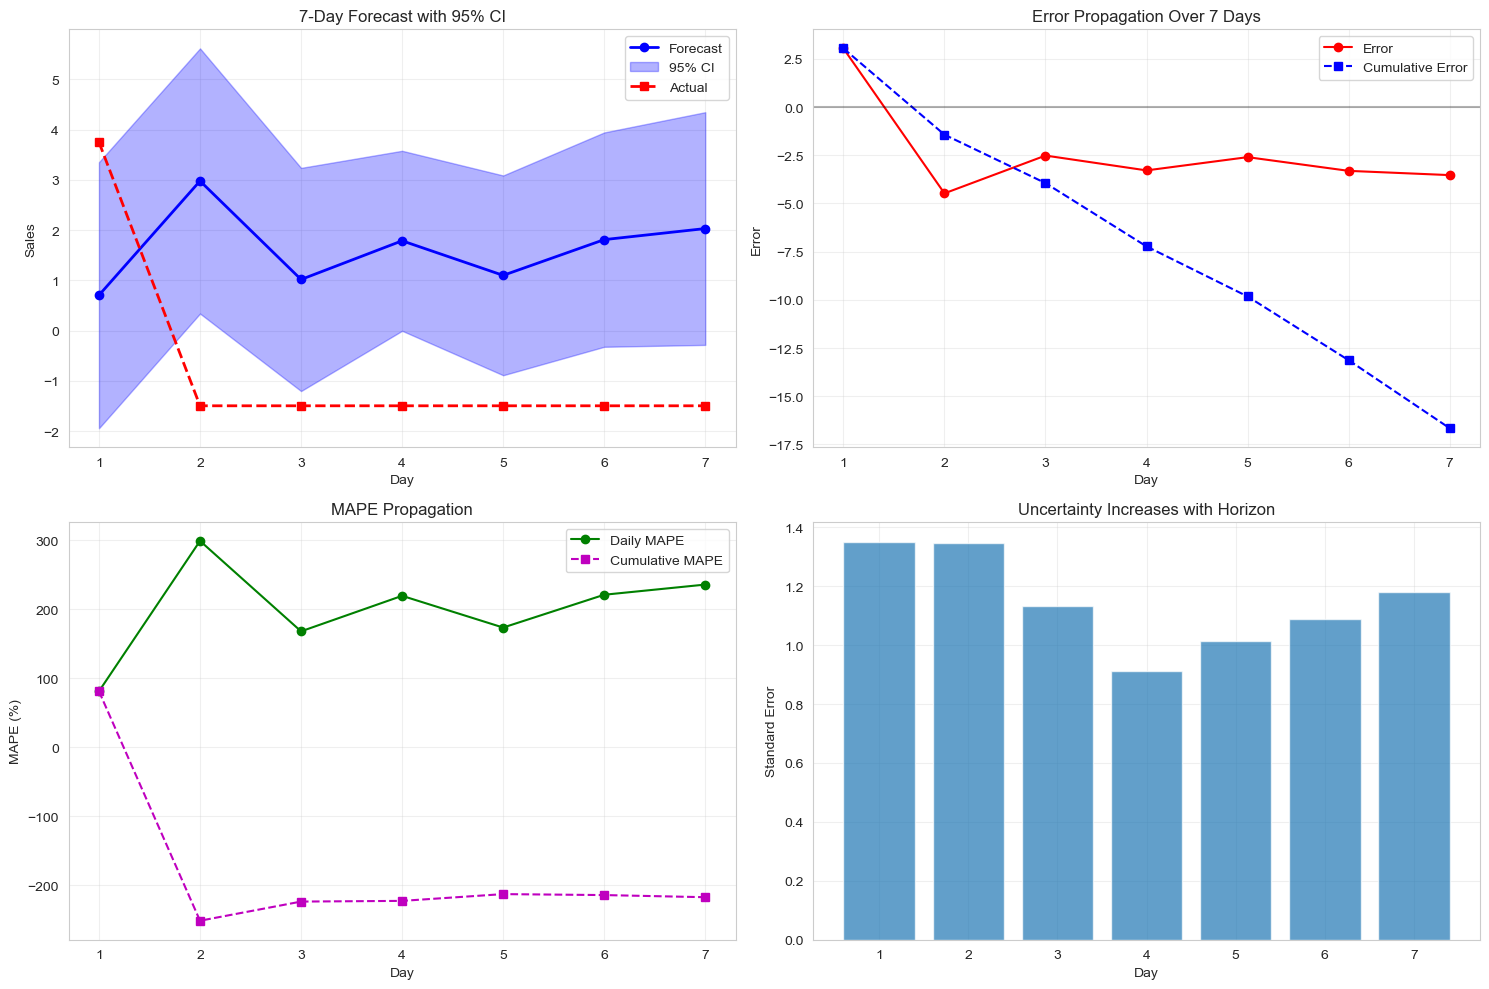


📊 MULTI-STEP FORECAST EVALUATION

Overall Metrics (All 7 days):
  MAE : 3.2497
  RMSE: 3.3062
  MAPE: 199.74%

Step-wise Metrics:
  Day 1: MAE=3.0448, MAPE=81.20%, Uncertainty=±2.6475
  Day 2: MAE=4.4744, MAPE=299.08%, Uncertainty=±2.6385
  Day 3: MAE=2.5140, MAPE=168.04%, Uncertainty=±2.2206
  Day 4: MAE=3.2839, MAPE=219.50%, Uncertainty=±1.7911
  Day 5: MAE=2.5959, MAPE=173.52%, Uncertainty=±1.9880
  Day 6: MAE=3.3072, MAPE=221.06%, Uncertainty=±2.1330
  Day 7: MAE=3.5275, MAPE=235.79%, Uncertainty=±2.3156

Error Propagation Rate: -5.47x
Uncertainty Growth Rate: 0.87x


In [92]:
def last_windows_forecast(model, X_test, y_test):
    """
    Simple 7-day forecast for your data
    """
    # Get last sequence
    last_sequence = X_test[-1]
    
    # Get actual next 7 days
    actual_next_7 = y_test[:7] if len(y_test) >= 7 else None
    
    # Initialize forecaster
    forecaster = MultiStepForecaster(model, horizon=7)
    
    # Generate forecast
    results = forecaster.forecast_next_7_days(last_sequence, actual_next_7)
    
    # Display results
    print("\nForecast Results:")
    print(results.to_string(index=False))
    
    # Plot results
    forecaster.plot_forecast(results)
    
    # Evaluate if actual values available
    if actual_next_7 is not None:
        forecaster.evaluate_forecast(results)
    
    return results
results = last_windows_forecast(model, X_test, y_test)


Window 1 (starting at index 101715):
  Actual values: [ 0.48429068 -0.10095088  0.85916162 -0.18082844  1.86962597  1.79449361
  0.79220155]
  Predictions  : [0.4674845  1.9254574  0.5818284  0.9698724  0.4812552  0.54358083
 1.0253671 ]
  MAE : 0.9062
  RMSE: 1.1373
  MAPE: 407.55%

Window 2 (starting at index 101708):
  Actual values: [0.66671732 1.41303211 0.77190263 0.7231325  0.95063856 1.12911087
 1.15257326]
  Predictions  : [0.6702867  2.2347143  0.78283364 1.4977802  0.78929466 1.3054825
 1.5374775 ]
  MAE : 0.3334
  RMSE: 0.4599
  MAPE: 33.32%

Window 3 (starting at index 101701):
  Actual values: [1.17471753 0.96803763 0.97410095 1.86936235 1.15415499 2.06075216
 0.57365864]
  Predictions  : [1.1884707 3.8896358 1.2515565 3.1668723 1.5713649 3.3909662 2.260569 ]
  MAE : 1.1350
  RMSE: 1.4680
  MAPE: 113.66%

Window 4 (starting at index 101694):
  Actual values: [ 0.92084924 -0.00341062  0.80380093  2.32252912  1.07216845  1.24484107
  0.85705264]
  Predictions  : [0.9035857

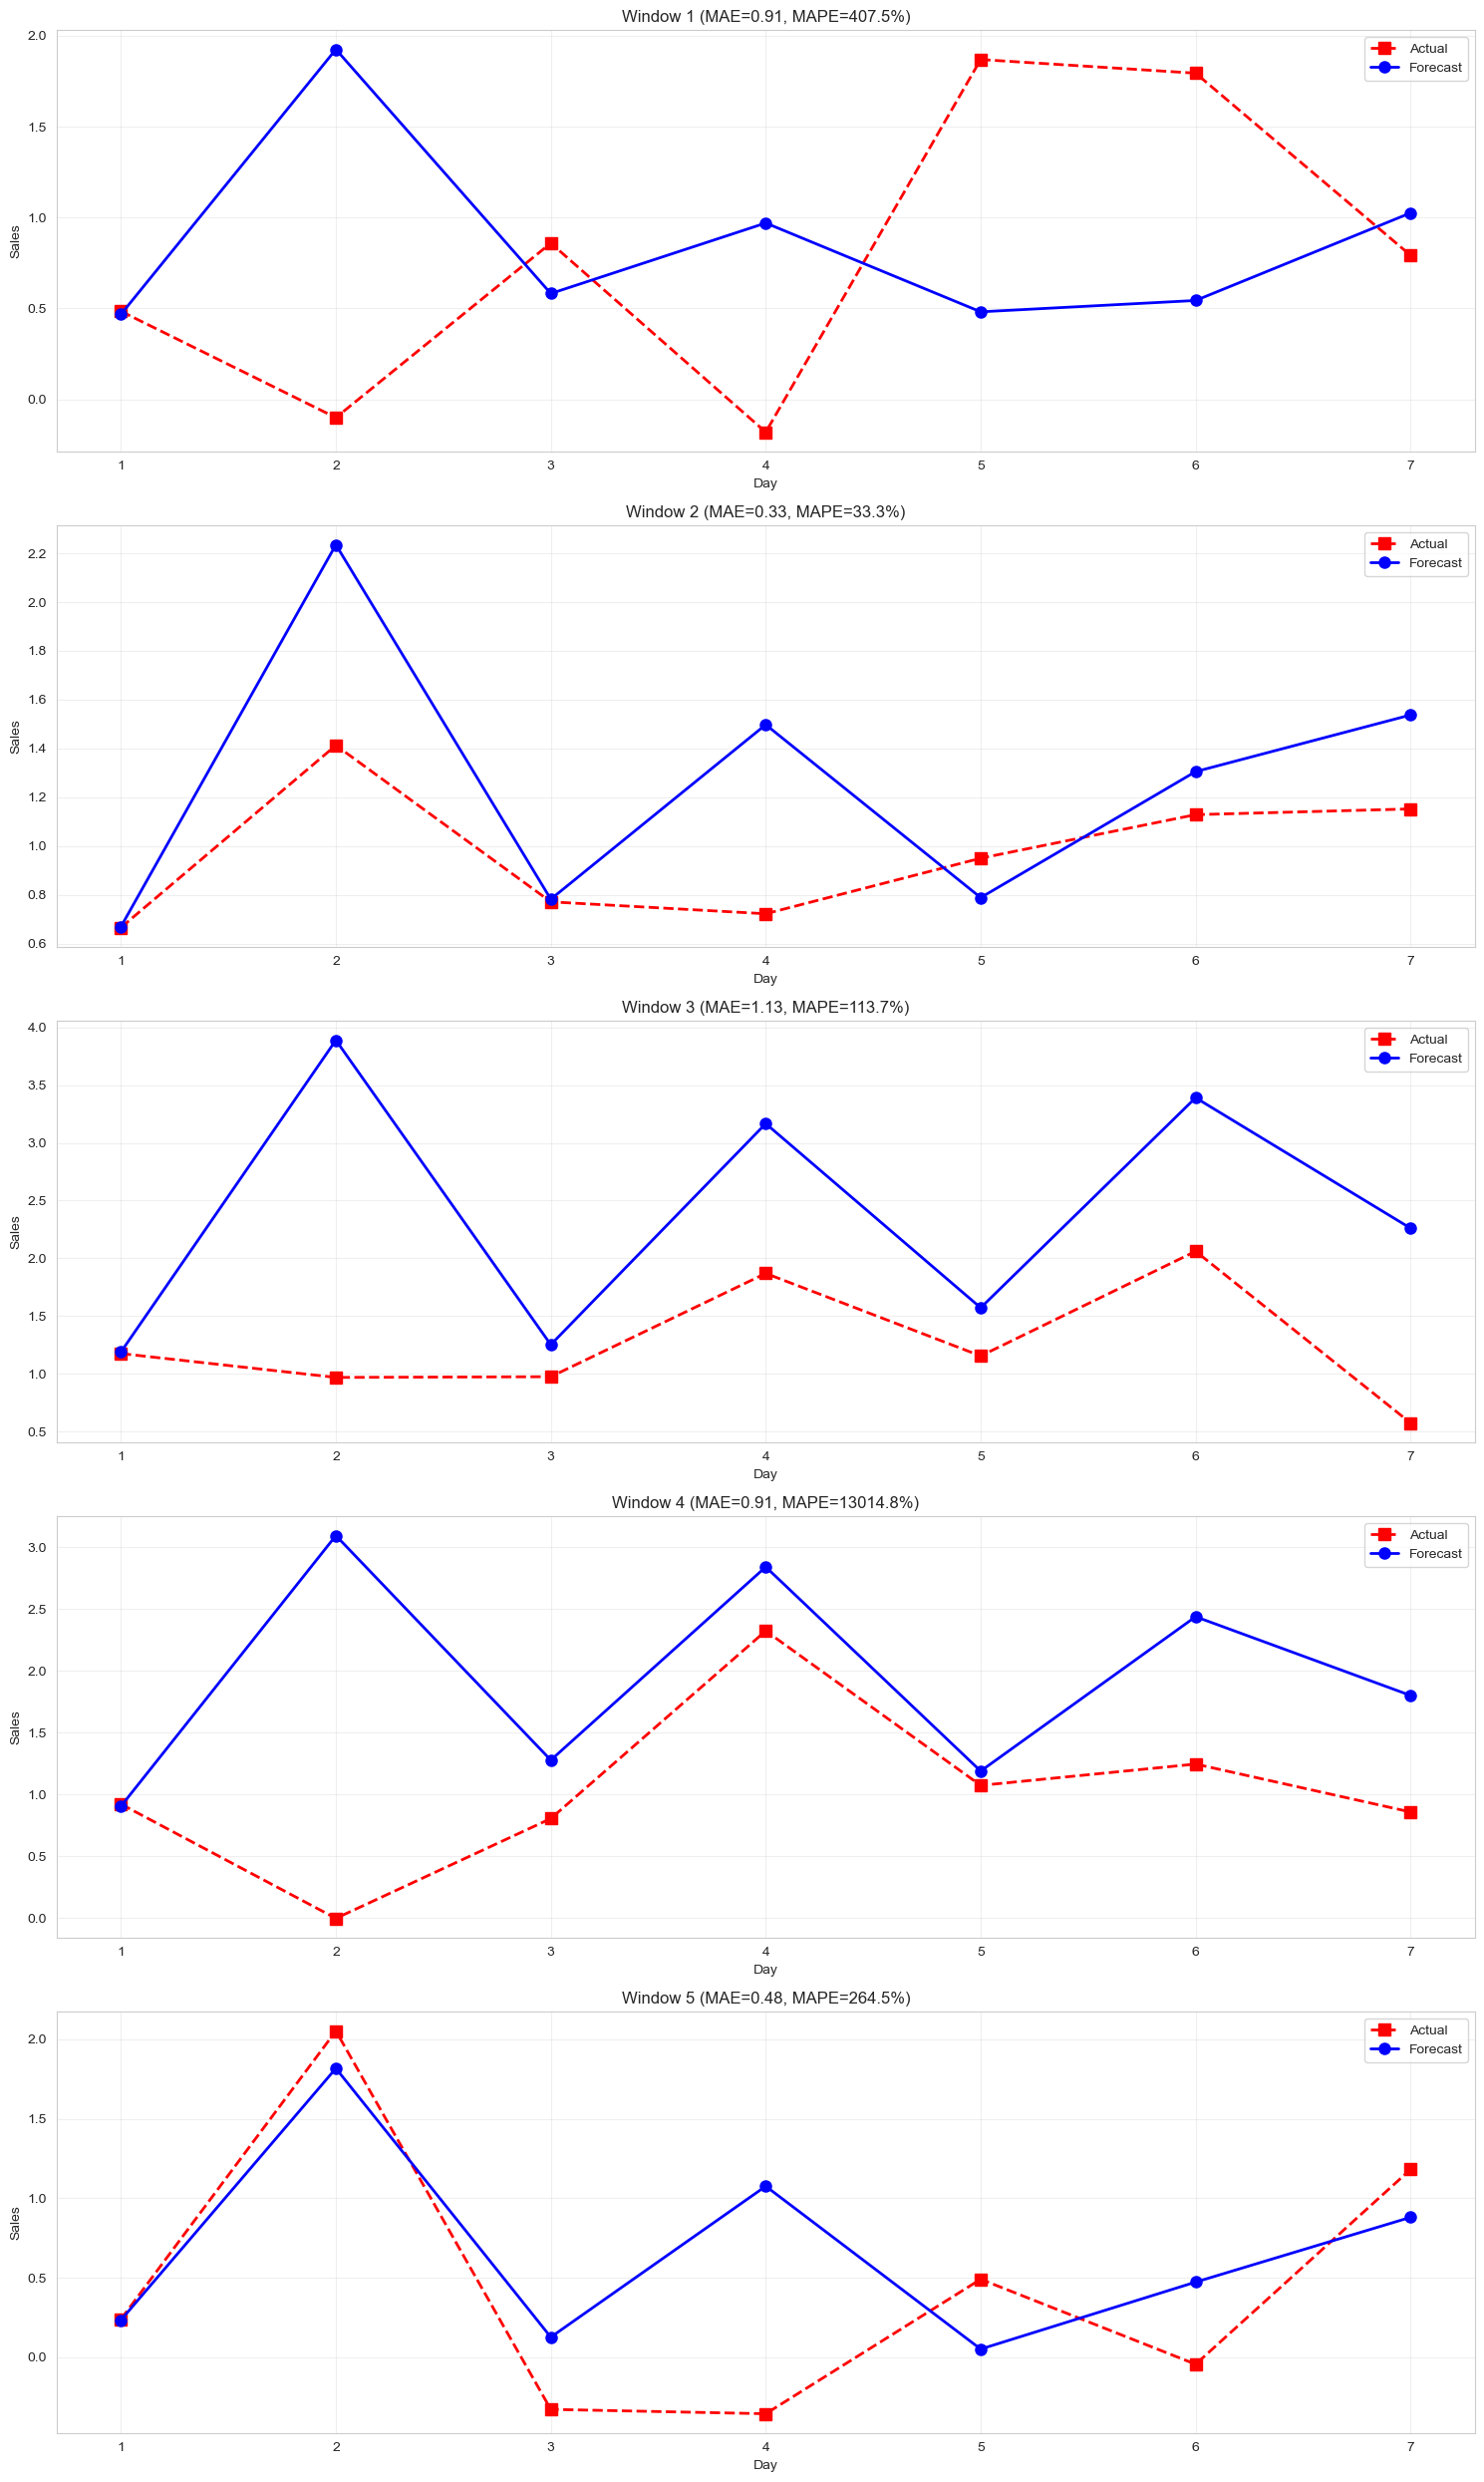

In [96]:
results = multi_window_forecast(model, X_test, y_test, n_windows=5)
plot_multi_window_forecast(results)

#### **4.1.2 Direct MultiStep Forcasting**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np

In [71]:
class DirectForecaster:
    def __init__(self, horizon=7):
        self.horizon = horizon
        self.models = {}
    
    def fit(self, X_train, y_train):
        print(f"Training {self.horizon} models...")
        
        for step in range(1, self.horizon + 1):
            print(f"  Step {step}")
            
            # Shift target for this step
            y_step = y_train[step:]
            X_step = X_train[:-step]
            
            # Train model
            model = xgb.XGBRegressor(
                n_estimators=1000,
                learning_rate=0.05,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                verbosity=0
                )
            model.fit(X_step, y_step)
            self.models[step] = model
    
    def predict(self, X_test):
        preds = []
        for step in range(1, self.horizon + 1):
            pred = self.models[step].predict(X_test)
            preds.append(pred)
        return np.column_stack(preds)
    
    def predict_next(self, last_row):
        preds = []
        for step in range(1, self.horizon + 1):
            pred = self.models[step].predict(last_row.reshape(1, -1))[0]
            preds.append(pred)
        return np.array(preds)

In [72]:
# Train
model = DirectForecaster(horizon=7)
model.fit(X_train, y_train)

Training 7 models...
  Step 1
  Step 2
  Step 3
  Step 4
  Step 5
  Step 6
  Step 7


In [73]:
preds = model.predict(X_test)
last_pred = model.predict_next(X_test[-1])


print("\nResults:")
for step in range(7):
    y_true = y_test[step:step + len(preds)]
    y_pred = preds[:, step]
    min_len = min(len(y_true), len(y_pred))
    rmse = np.sqrt(mean_squared_error(y_true[:min_len], y_pred[:min_len]))
    print(f"Step {step+1}: RMSE={rmse:.4f}")

print(f"\nNext 7 days: {last_pred}")


Results:
Step 1: RMSE=0.6661
Step 2: RMSE=0.7032
Step 3: RMSE=0.7021
Step 4: RMSE=0.7013
Step 5: RMSE=0.7027
Step 6: RMSE=0.7018
Step 7: RMSE=0.7066

Next 7 days: [1.2442933  0.9013019  0.9525255  0.90006083 0.8961613  0.94478136
 1.1075792 ]


In [76]:
# Predict on last 5 windows (7 days each)
def predict_5_windows(model, X_test, y_test):
    """
    Predict on last 5 windows of test data (each 7 days)
    """
    n = len(X_test)
    windows = []
    
    print("=" * 50)
    print("📊 5-WINDOW 7-DAY FORECAST")
    print("=" * 50)
    
    for w in range(5):
        start = n - (7 * (w + 1))
        if start < 0:
            break
            
        # Get last sequence for this window
        last_row = X_test[start]
        
        # Predict next 7 days
        pred = model.predict_next(last_row)
        actual = y_test[start:start+7]
        
        rmse = np.sqrt(mean_squared_error(actual, pred))
        
        windows.append({
            'window': w + 1,
            'start': start,
            'pred': pred,
            'actual': actual,
            'rmse': rmse
        })
        
        print(f"\nWindow {w+1}:")
        print(f"  Actual : {[f'{x:.2f}' for x in actual]}")
        print(f"  Pred   : {[f'{x:.2f}' for x in pred]}")
        print(f"  RMSE   : {rmse:.4f}")
    
    return windows

def plot_windows(windows):
    """
    Plot all 5 prediction windows
    """
    n = len(windows)
    fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n))
    
    if n == 1:
        axes = [axes]
    
    days = np.arange(1, 8)
    
    for i, w in enumerate(windows):
        ax = axes[i]
        
        ax.plot(days, w['actual'], 'ro-', linewidth=2, markersize=8, label='Actual')
        ax.plot(days, w['pred'], 'bs-', linewidth=2, markersize=8, label='Predicted')
        
        ax.set_xlabel('Day')
        ax.set_ylabel('Sales')
        ax.set_title(f'Window {w["window"]} (RMSE={w["rmse"]:.2f})')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xticks(days)
    
    plt.tight_layout()
    plt.show()

def print_summary(windows):
    """
    Print summary statistics
    """
    rmses = [w['rmse'] for w in windows]
    
    print("\n" + "=" * 50)
    print(" SUMMARY")
    print("=" * 50)
    print(f"Average RMSE : {np.mean(rmses):.4f}")
    print(f"Std RMSE     : {np.std(rmses):.4f}")
    print(f"Best Window : Window {np.argmin(rmses)+1} (RMSE={np.min(rmses):.4f})")
    print(f"Worst Window: Window {np.argmax(rmses)+1} (RMSE={np.max(rmses):.4f})")


📊 5-WINDOW 7-DAY FORECAST

Window 1:
  Actual : ['0.48', '-0.10', '0.86', '-0.18', '1.87', '1.79', '0.79']
  Pred   : ['1.00', '0.96', '0.91', '0.80', '0.84', '0.99', '0.82']
  RMSE   : 0.7618

Window 2:
  Actual : ['0.67', '1.41', '0.77', '0.72', '0.95', '1.13', '1.15']
  Pred   : ['0.96', '0.85', '0.91', '0.88', '0.89', '0.90', '0.88']
  RMSE   : 0.2881

Window 3:
  Actual : ['1.17', '0.97', '0.97', '1.87', '1.15', '2.06', '0.57']
  Pred   : ['1.08', '1.02', '0.86', '0.93', '1.08', '1.06', '1.03']
  RMSE   : 0.5511

Window 4:
  Actual : ['0.92', '-0.00', '0.80', '2.32', '1.07', '1.24', '0.86']
  Pred   : ['0.81', '0.84', '0.71', '1.13', '0.75', '0.93', '1.13']
  RMSE   : 0.5901

Window 5:
  Actual : ['0.24', '2.05', '-0.33', '-0.36', '0.49', '-0.04', '1.18']
  Pred   : ['0.95', '0.97', '0.89', '0.88', '0.83', '0.94', '0.84']
  RMSE   : 0.9157


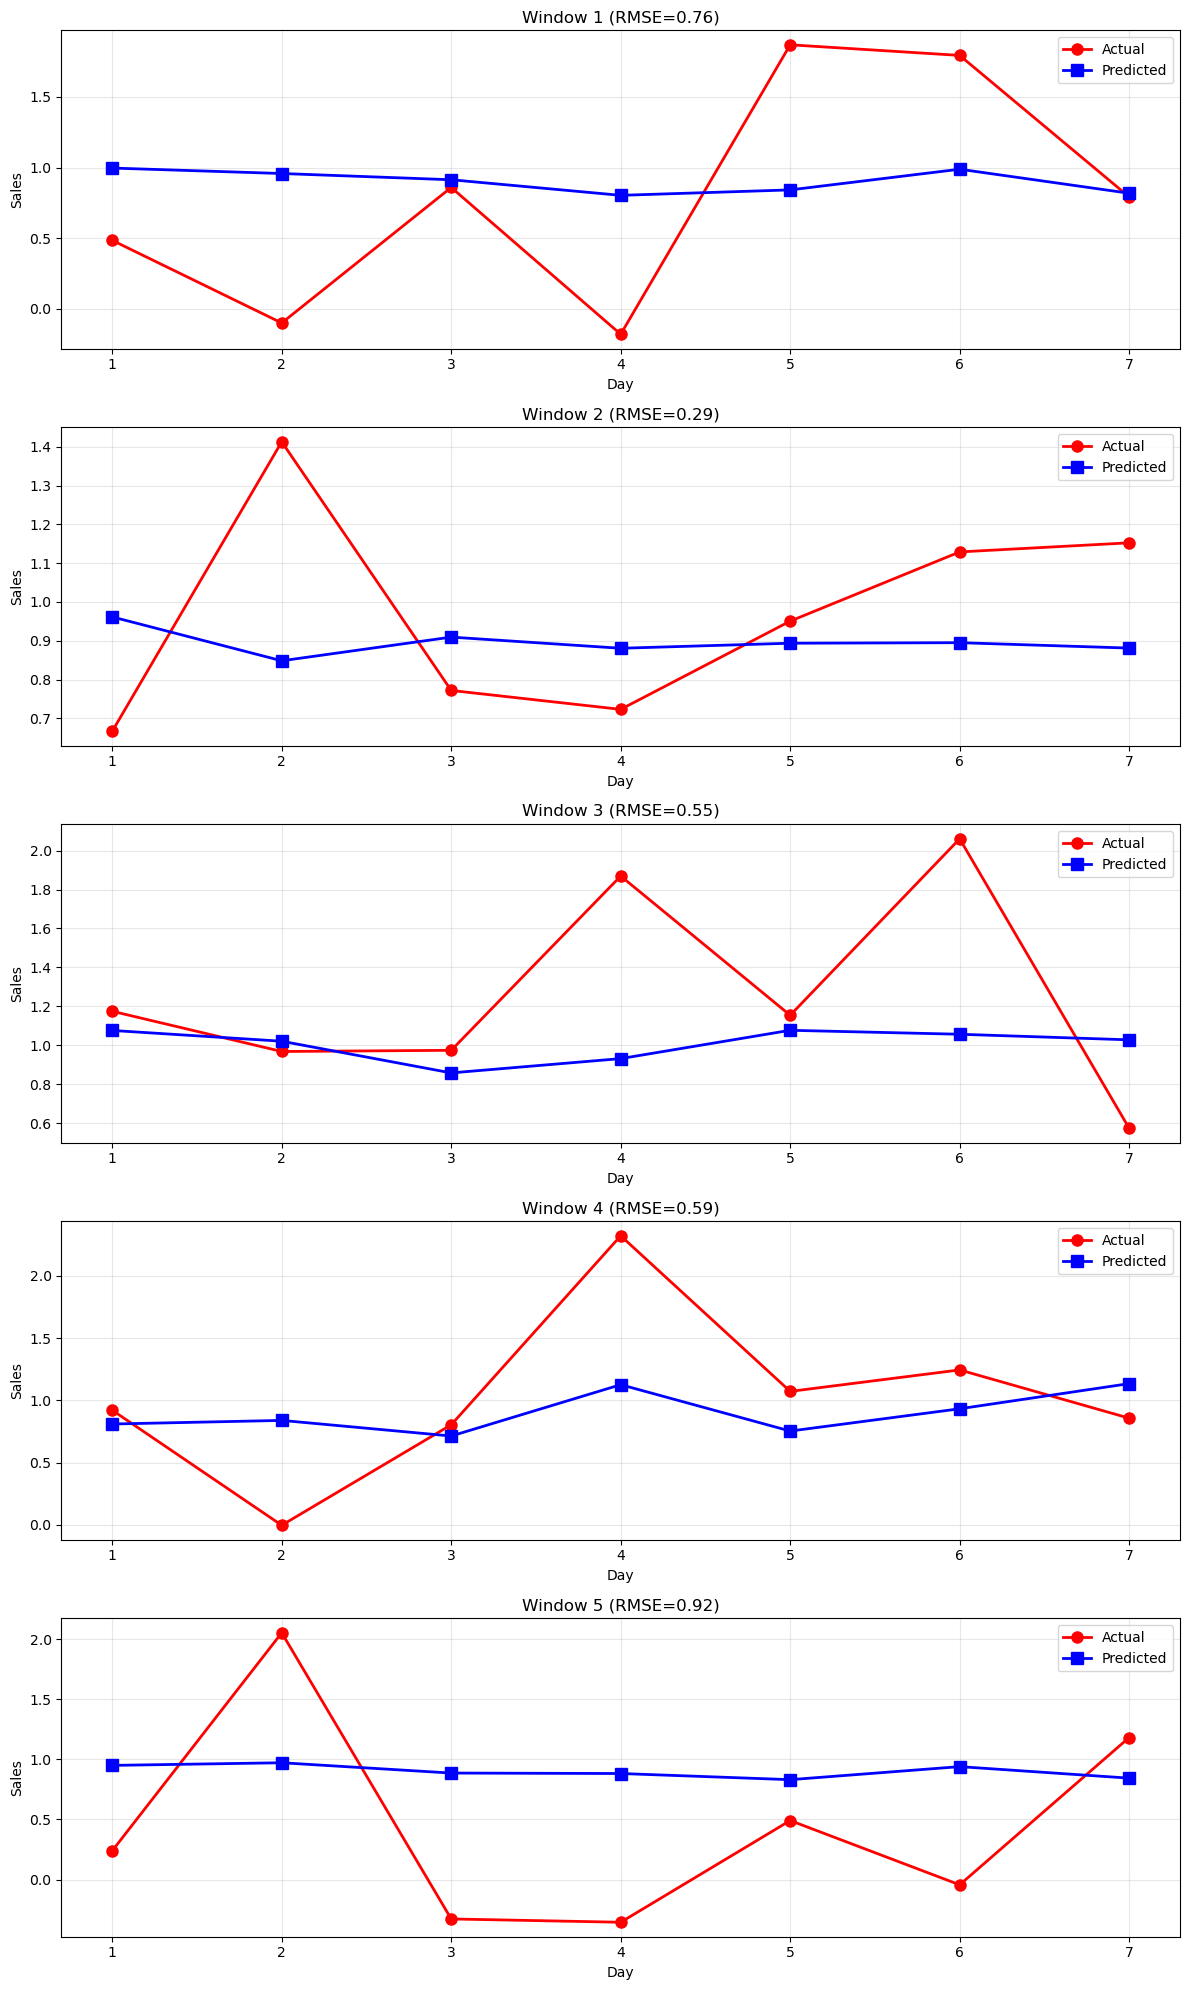


 SUMMARY
Average RMSE : 0.6214
Std RMSE     : 0.2113
Best Window : Window 2 (RMSE=0.2881)
Worst Window: Window 5 (RMSE=0.9157)


In [77]:
windows = predict_5_windows(model, X_test, y_test)
# Plot
plot_windows(windows)
# Summary
print_summary(windows)

### **4.2 Quantile Regression**

In [97]:
def pinball_loss(y_true, y_pred, tau):
    """Simple pinball loss function"""
    error = y_true - y_pred
    loss = np.where(error >= 0, tau * error, (tau - 1) * error)
    return np.mean(loss)

def train_quantile_model(X_train, y_train, X_val, y_val, tau, n_estimators=100):
    """Train a single quantile model"""
    
    # Custom objective for XGBoost
    def quantile_obj(preds, dtrain):
        labels = dtrain.get_label()
        grad = np.where(labels >= preds, -tau, -(tau - 1))
        hess = np.ones_like(preds)
        return grad, hess
    
    # Create DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    # Parameters
    params = {
        'learning_rate': 0.1,
        'max_depth': 5,
        'seed': 42
    }
    
    # Train
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=n_estimators,
        obj=quantile_obj,
        evals=[(dtrain, 'train'), (dval, 'val')],
        verbose_eval=False
    )
    
    return model

def quantile_prediction_interval(X_train, y_train, X_test, y_test, quantiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]):
    """
    Simple quantile regression for prediction intervals
    """
    print("=" * 50)
    print("QUANTILE REGRESSION")
    print("=" * 50)
    
    # Split train/val
    split = int(0.8 * len(X_train))
    X_tr, X_val = X_train[:split], X_train[split:]
    y_tr, y_val = y_train[:split], y_train[split:]
    
    # Train models for each quantile
    models = {}
    predictions = {}
    
    for tau in quantiles:
        print(f"\nTraining quantile {tau}...")
        model = train_quantile_model(X_tr, y_tr, X_val, y_val, tau)
        models[tau] = model
        
        # Predict
        dtest = xgb.DMatrix(X_test)
        predictions[tau] = model.predict(dtest)
    
    # Results
    print("\n" + "=" * 50)
    print("RESULTS")
    print("=" * 50)
    
    # Metrics for each quantile
    for tau in quantiles:
        mae = mean_absolute_error(y_test, predictions[tau])
        rmse = np.sqrt(mean_squared_error(y_test, predictions[tau]))
        pl = pinball_loss(y_test, predictions[tau], tau)
        print(f"\nQuantile {tau}:")
        print(f"  MAE: {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  Pinball: {pl:.4f}")
    
    # Interval coverage (if we have lower and upper)
    if 0.1 in quantiles and 0.9 in quantiles:
        coverage = np.mean((y_test >= predictions[0.1]) & (y_test <= predictions[0.9]))
        width = np.mean(predictions[0.9] - predictions[0.1])
        print(f"\n80% Prediction Interval:")
        print(f"  Coverage: {coverage:.2%}")
        print(f"  Avg Width: {width:.4f}")
    
    return predictions

In [98]:
predictions = quantile_prediction_interval(X_train, y_train, X_test, y_test)

QUANTILE REGRESSION

Training quantile 0.01...

Training quantile 0.05...

Training quantile 0.1...

Training quantile 0.25...

Training quantile 0.5...

Training quantile 0.75...

Training quantile 0.9...

Training quantile 0.95...

Training quantile 0.99...

RESULTS

Quantile 0.01:
  MAE: 0.2527
  RMSE: 0.5558
  Pinball: 0.0026

Quantile 0.05:
  MAE: 0.1741
  RMSE: 0.4408
  Pinball: 0.0091

Quantile 0.1:
  MAE: 0.1186
  RMSE: 0.3352
  Pinball: 0.0128

Quantile 0.25:
  MAE: 0.0480
  RMSE: 0.1459
  Pinball: 0.0143

Quantile 0.5:
  MAE: 0.0262
  RMSE: 0.0642
  Pinball: 0.0131

Quantile 0.75:
  MAE: 0.0287
  RMSE: 0.0573
  Pinball: 0.0100

Quantile 0.9:
  MAE: 0.2221
  RMSE: 0.4229
  Pinball: 0.0237

Quantile 0.95:
  MAE: 0.3922
  RMSE: 0.6609
  Pinball: 0.0203

Quantile 0.99:
  MAE: 0.6221
  RMSE: 0.8990
  Pinball: 0.0064

80% Prediction Interval:
  Coverage: 85.24%
  Avg Width: 0.3345


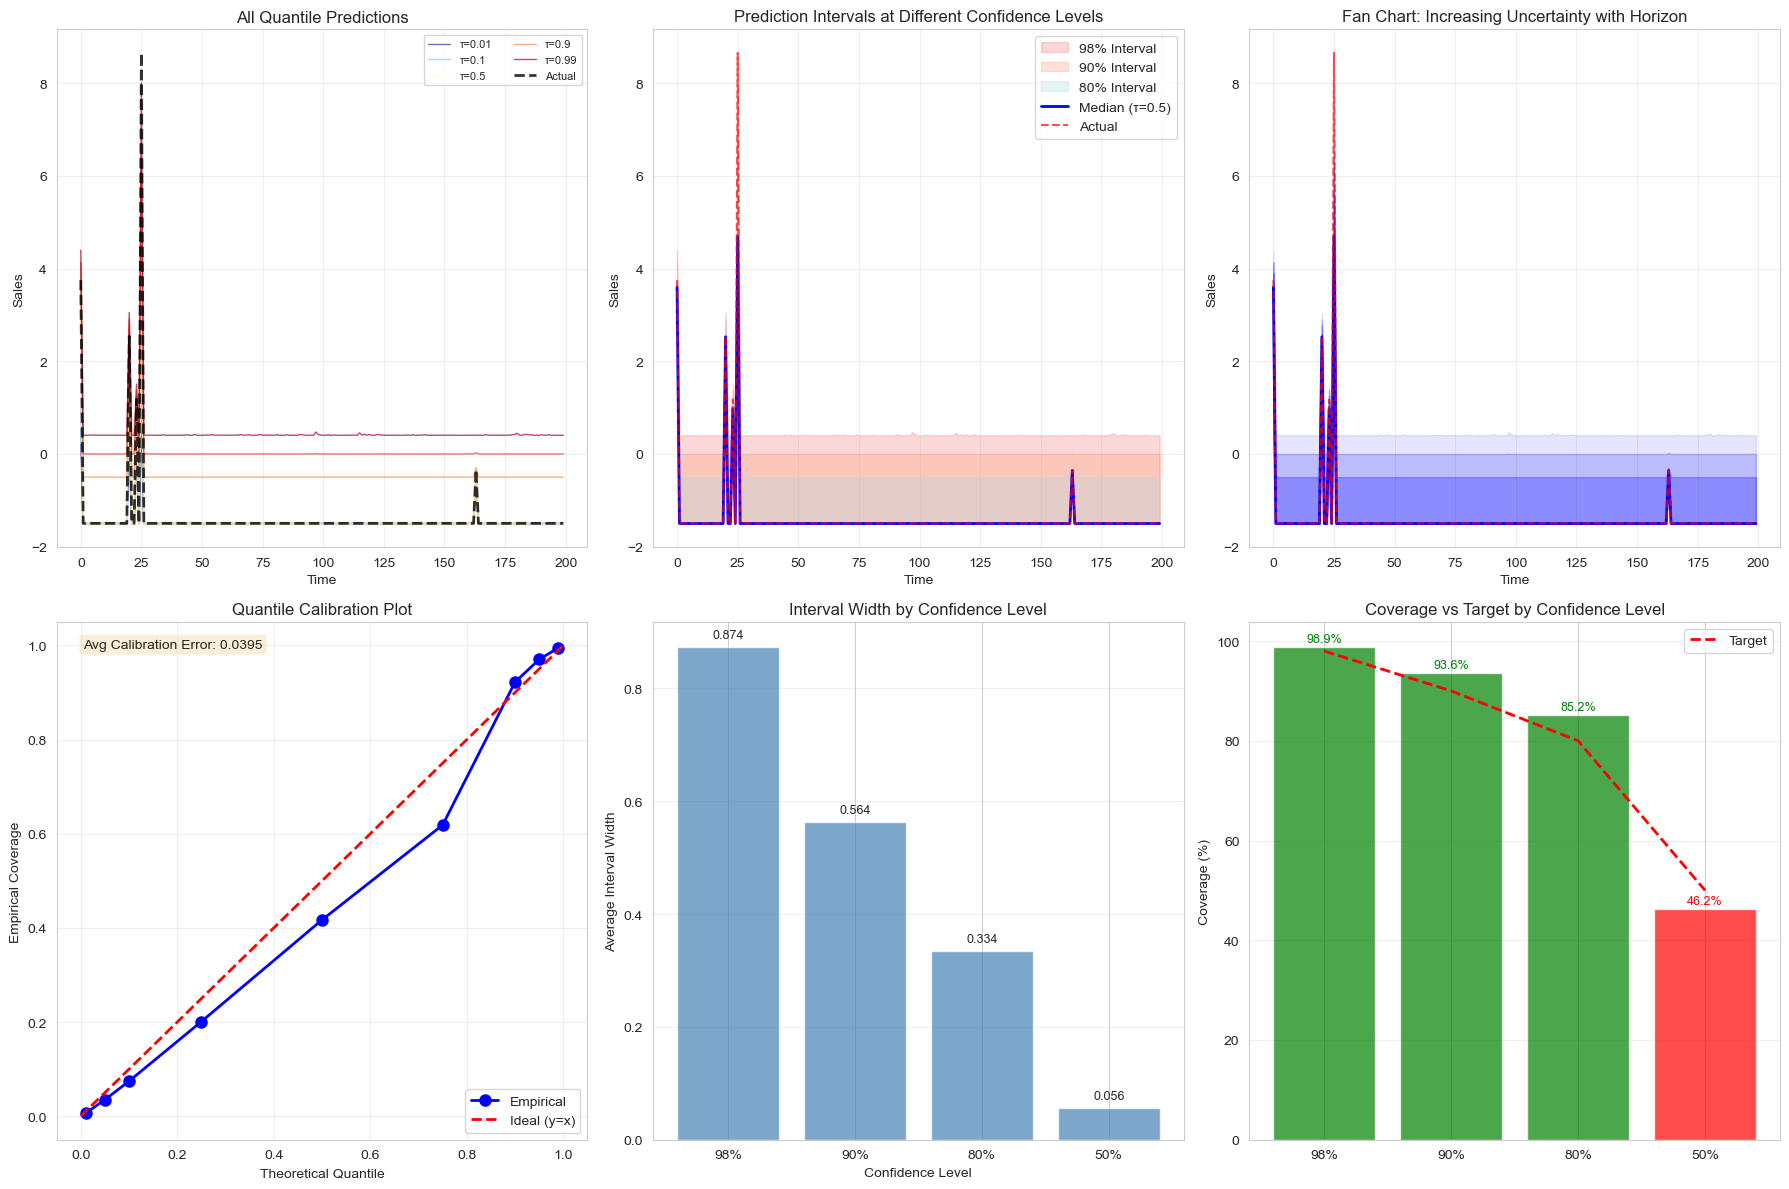


QUANTILE REGRESSION SUMMARY

Calibration Quality:
   Average Calibration Error: 0.0395
   Best Calibrated Quantile: 0.01
   Worst Calibrated Quantile: 0.75

Interval Performance:
   ✓ 98% Interval: 98.9% coverage (Δ=+0.9%)
   ✓ 90% Interval: 93.6% coverage (Δ=+3.6%)
   ✓ 80% Interval: 85.2% coverage (Δ=+5.2%)
   ✗ 50% Interval: 46.2% coverage (Δ=-3.8%)

Average Widths:
   98%: 0.8743
   90%: 0.5637
   80%: 0.3345
   50%: 0.0564


In [100]:
def plot_quantile_results(y_test, predictions, quantiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]):
    """
    Plot comprehensive quantile regression results
    """
    plt.figure(figsize=(18, 12))
    
    plt.subplot(2, 3, 1)
    n = 200
    x_axis = np.arange(n)
    
    # Plot quantile bands (from lowest to highest)
    colors = plt.cm.RdYlBu_r(np.linspace(0, 1, len(quantiles)))
    
    for i, tau in enumerate(sorted(quantiles)):
        if tau in predictions:
            plt.plot(x_axis, predictions[tau][:n], 
                    color=colors[i], linewidth=1, alpha=0.7,
                    label=f'τ={tau}' if i % 2 == 0 else '')
    
    plt.plot(x_axis, y_test[:n], 'k--', linewidth=2, label='Actual', alpha=0.8)
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.title('All Quantile Predictions')
    plt.legend(loc='upper right', ncol=2, fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Prediction intervals (80%, 90%, 98%)
    plt.subplot(2, 3, 2)
    
    intervals = [
        ('98%', 0.01, 0.99, 'lightcoral'),
        ('90%', 0.05, 0.95, 'lightsalmon'),
        ('80%', 0.1, 0.9, 'lightblue')
    ]
    
    for name, low, high, color in intervals:
        if low in predictions and high in predictions:
            plt.fill_between(x_axis, 
                            predictions[low][:n], 
                            predictions[high][:n], 
                            alpha=0.3, color=color, label=f'{name} Interval')
    
    plt.plot(x_axis, predictions[0.5][:n], 'b-', linewidth=2, label='Median (τ=0.5)')
    plt.plot(x_axis, y_test[:n], 'r--', linewidth=1.5, label='Actual', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.title('Prediction Intervals at Different Confidence Levels')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Fan Chart
    plt.subplot(2, 3, 3)
    
    # Create fan chart with increasing opacity
    sorted_taus = sorted(quantiles)
    n_taus = len(sorted_taus)
    
    for i in range(n_taus // 2):
        low_tau = sorted_taus[i]
        high_tau = sorted_taus[-(i+1)]
        if low_tau in predictions and high_tau in predictions:
            alpha = 0.1 + 0.3 * (i / (n_taus // 2))
            plt.fill_between(x_axis,
                            predictions[low_tau][:n],
                            predictions[high_tau][:n],
                            alpha=alpha, color='blue',
                            label=f'{int((1-2*low_tau)*100)}% CI' if i==0 else '')
    
    plt.plot(x_axis, predictions[0.5][:n], 'b-', linewidth=2)
    plt.plot(x_axis, y_test[:n], 'r--', linewidth=1.5, alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.title('Fan Chart: Increasing Uncertainty with Horizon')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Calibration Plot
    plt.subplot(2, 3, 4)
    
    empirical = []
    for tau in quantiles:
        if tau in predictions:
            emp = np.mean(y_test <= predictions[tau])
            empirical.append(emp)
    
    plt.plot(quantiles, empirical, 'bo-', linewidth=2, markersize=8, label='Empirical')
    plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Ideal (y=x)')
    plt.xlabel('Theoretical Quantile')
    plt.ylabel('Empirical Coverage')
    plt.title('Quantile Calibration Plot')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add text for calibration quality
    cal_error = np.mean([abs(empirical[i] - quantiles[i]) for i in range(len(quantiles))])
    plt.text(0.05, 0.95, f'Avg Calibration Error: {cal_error:.4f}', 
             transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 5: Interval Width by Confidence Level
    plt.subplot(2, 3, 5)
    
    conf_levels = []
    widths = []
    
    for i in range(len(quantiles) // 2):
        low = quantiles[i]
        high = quantiles[-(i+1)]
        if low in predictions and high in predictions:
            conf = (1 - 2 * low) * 100
            width = np.mean(predictions[high] - predictions[low])
            conf_levels.append(f'{int(conf)}%')
            widths.append(width)
    
    bars = plt.bar(conf_levels, widths, alpha=0.7, color='steelblue')
    plt.xlabel('Confidence Level')
    plt.ylabel('Average Interval Width')
    plt.title('Interval Width by Confidence Level')
    
    # Add value labels on bars
    for bar, width in zip(bars, widths):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{width:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.grid(True, alpha=0.3, axis='y')
    
    # Plot 6: Coverage vs Target
    plt.subplot(2, 3, 6)
    
    targets = []
    coverages = []
    colors = []
    
    for i in range(len(quantiles) // 2):
        low = quantiles[i]
        high = quantiles[-(i+1)]
        if low in predictions and high in predictions:
            target = (1 - 2 * low) * 100
            coverage = np.mean((y_test >= predictions[low]) & (y_test <= predictions[high])) * 100
            
            targets.append(target)
            coverages.append(coverage)
            
            if coverage >= target:
                colors.append('green')
            else:
                colors.append('red')
    
    plt.bar(range(len(targets)), coverages, alpha=0.7, color=colors)
    plt.plot(range(len(targets)), targets, 'r--', linewidth=2, label='Target')
    plt.xticks(range(len(targets)), [f'{int(t)}%' for t in targets])
    plt.ylabel('Coverage (%)')
    plt.title('Coverage vs Target by Confidence Level')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (cov, target) in enumerate(zip(coverages, targets)):
        color = 'green' if cov >= target else 'red'
        plt.text(i, cov + 1, f'{cov:.1f}%', ha='center', fontsize=9, color=color)
    
    plt.tight_layout()
    plt.savefig('./pictures/phase4_QuantileRegression.png', dpi=300, bbox_inches='tight')
    plt.show()
    

    print("\n" + "=" * 60)
    print("QUANTILE REGRESSION SUMMARY")
    print("=" * 60)
    
    print("\nCalibration Quality:")
    print(f"   Average Calibration Error: {cal_error:.4f}")
    print(f"   Best Calibrated Quantile: {quantiles[np.argmin([abs(empirical[i] - quantiles[i]) for i in range(len(quantiles))])]}")
    print(f"   Worst Calibrated Quantile: {quantiles[np.argmax([abs(empirical[i] - quantiles[i]) for i in range(len(quantiles))])]}")
    
    print("\nInterval Performance:")
    for i, (target, coverage) in enumerate(zip(targets, coverages)):
        status = "✓" if coverage >= target else "✗"
        print(f"   {status} {int(target)}% Interval: {coverage:.1f}% coverage (Δ={coverage-target:+.1f}%)")
    
    print(f"\nAverage Widths:")
    for conf, width in zip(conf_levels, widths):
        print(f"   {conf}: {width:.4f}")
    
    return {
        'calibration_error': cal_error,
        'targets': targets,
        'coverages': coverages,
        'widths': widths
    }

stats = plot_quantile_results(y_test, predictions)

### **4.3 Classification**

#### **4.3.1 Adding "Label" Feature And Droping Closed Days**

In [21]:
df1['label'] = pd.cut(df1['sales'], bins=3, labels=['low', 'medium', 'high'])

In [22]:
df1 = df1[df1['open'] != 0]

#### **4.3.2. Time-Based split data**

In [23]:
df1 = df1.sort_values('date')

train_size = int(0.7 * len(df1))
val_size = int(0.2 * len(df1))

train = df1.iloc[:train_size]
val = df1.iloc[train_size:train_size + val_size]
test = df1.iloc[train_size + val_size:]

print(f"Train: {train.shape} ({train['date'].min()} to {train['date'].max()})")
print(f"Val: {val.shape} ({val['date'].min()} to {val['date'].max()})")
print(f"Test: {test.shape} ({test['date'].min()} to {test['date'].max()})")

Train: (591074, 45) (2013-01-01 to 2014-10-18)
Val: (168878, 45) (2014-10-18 to 2015-05-02)
Test: (84440, 45) (2015-05-02 to 2015-07-31)


#### **4.3.3. Scale and Standardized data**

In [25]:
numerical_cols = [
    'sales', 'customers', 'competition_distance', 
    'days_since_competition', 'days_since_promo2', 'days_from_start',
    'sales_ma7', 'sales_ma30', 'sales_lag1', 'sales_lag7', 
    'sales_std7', 'sales_to_ma7_ratio', 'sales_per_customer'
]
numerical_cols = [col for col in numerical_cols if col in train.columns]


# Fit scaler ONLY on training data
scaler = StandardScaler()
scaler.fit(train[numerical_cols])

# Transform train, val, test
train_scaled = train.copy()
val_scaled = val.copy()
test_scaled = test.copy()

train_scaled[numerical_cols] = scaler.transform(train[numerical_cols])
val_scaled[numerical_cols] = scaler.transform(val[numerical_cols])
test_scaled[numerical_cols] = scaler.transform(test[numerical_cols])

print(f"Train mean (first col): {train_scaled[numerical_cols[0]].mean():.4f}")
print(f"Val mean (first col)  : {val_scaled[numerical_cols[0]].mean():.4f}")
print(f"Test mean (first col) : {test_scaled[numerical_cols[0]].mean():.4f}")

Train mean (first col): -0.0000
Val mean (first col)  : 0.1426
Test mean (first col) : 0.1215


#### **4.3.4. Encoding Data**

In [27]:
categorical_cols = ['store_type', 'assortment', 'state_holiday', 'season', 'day_of_week', 'month_map', 'month_abbr']
categorical_cols = [col for col in categorical_cols if col in df1.columns]

df_xgbclass_train = train_scaled.copy()
df_xgbclass_val = val_scaled.copy()
df_xgbclass_test = test_scaled.copy()

# Fit encoders ONLY on training data
label_encoders = {}

for col in categorical_cols:
    # Fit on training data only
    le = LabelEncoder()
    le.fit(train_scaled[col].astype(str))
    
    # Transform train, val, test
    df_xgbclass_train[col] = le.transform(train_scaled[col].astype(str))
    df_xgbclass_val[col] = le.transform(val_scaled[col].astype(str))
    df_xgbclass_test[col] = le.transform(test_scaled[col].astype(str))
    
    label_encoders[col] = le

In [31]:
exclude = ['sales', 'date', 'store', 'promo_interval', 'month_abbr', 'competition_since', "promo2_start"]
feature_cols = [c for c in df_xgb_train.columns if c not in exclude]

X_train, y_train = df_xgbclass_train[feature_cols].values, df_xgb_train['sales'].values
X_val, y_val = df_xgbclass_val[feature_cols].values, df_xgb_val['sales'].values
X_test, y_test = df_xgbclass_test[feature_cols].values, df_xgb_test['sales'].values

#### **4.3.5. Preparing Data**

In [34]:
df_xgbclass_train['label'] = pd.cut(df_xgbclass_train['sales'], bins=3, labels=[0, 1, 2])
df_xgbclass_val['label'] = pd.cut(df_xgbclass_val['sales'], bins=3, labels=[0, 1, 2])
df_xgbclass_test['label'] = pd.cut(df_xgbclass_test['sales'], bins=3, labels=[0, 1, 2])
exclude = ['sales', 'date', 'store', 'promo_interval', 'month_abbr', 
           'competition_since', 'promo2_start', 'label']
feature_cols = [c for c in df_xgbclass_train.columns if c not in exclude]

X_train = df_xgbclass_train[feature_cols].values
X_val = df_xgbclass_val[feature_cols].values
X_test = df_xgbclass_test[feature_cols].values

y_train = df_xgbclass_train['label'].values
y_val = df_xgbclass_val['label'].values
y_test = df_xgbclass_test['label'].values

### **4.3.2 Classification Model (<ins>Custom</ins> XGBoost Classification)**

In [30]:
class XGBoostClassifier:
    '''

    Inputs
    ------------------------------------------------------------------------------------------------------------------
    x: pandas datframe of the training data
    gradient: negative gradient of the loss function
    hessian: second order derivative of the loss function
    idxs: used to keep track of samples within the tree structure
    subsample_cols: is an implementation of layerwise column subsample randomizing the structure of the trees
    (complexity parameter)
    min_leaf: minimum number of samples for a node to be considered a node (complexity parameter)
    min_child_weight: sum of the heassian inside a node is a meaure of purity (complexity parameter)
    depth: limits the number of layers in the tree
    lambda: L2 regularization term on weights. Increasing this value will make model more conservative.
    gamma: This parameter also prevents over fitting and is present in the the calculation of the gain (structure score). 
    As this is subtracted from the gain it essentially sets a minimum gain amount to make a split in a node.
    eps: This parameter is used in the quantile weighted skecth or 'approx' tree method roughly translates to 
    (1 / sketch_eps) number of bins

    Outputs
    --------------------------------------------------------------------------------------------------------------------
    A single tree object that will be used for gradient boosintg.
    '''
    def __init__(self):
        self.estimators = []
    
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    # first order gradient logLoss
    def grad(self, preds, labels):
        preds = self.sigmoid(preds)
        return(preds - labels)
    
    # second order gradient logLoss
    def hess(self, preds, labels):
        preds = self.sigmoid(preds)
        return(preds * (1 - preds))
    
    @staticmethod
    def log_odds(column):
        binary_yes = np.count_nonzero(column == 1)
        binary_no  = np.count_nonzero(column == 0)
        return(np.log(binary_yes/binary_no))
    
    
    def fit(self, X, y, subsample_cols = 0.8 , min_child_weight = 1, depth = 5, min_leaf = 5, learning_rate = 0.4, boosting_rounds = 5, lambda_ = 1.5, gamma = 1, eps = 0.1):
        self.X, self.y = X, y
        self.depth = depth
        self.subsample_cols = subsample_cols
        self.eps = eps
        self.min_child_weight = min_child_weight 
        self.min_leaf = min_leaf
        self.learning_rate = learning_rate
        self.boosting_rounds = boosting_rounds 
        self.lambda_ = lambda_
        self.gamma  = gamma
    
        self.base_pred = np.full((X.shape[0], 1), 1).flatten().astype('float64')
    
        for booster in range(self.boosting_rounds):
            Grad = self.grad(self.base_pred, self.y)
            Hess = self.hess(self.base_pred, self.y)
            boosting_tree = XGBoostTree().fit(self.X, Grad, Hess, depth = self.depth, min_leaf = self.min_leaf, lambda_ = self.lambda_, gamma = self.gamma, eps = self.eps, min_child_weight = self.min_child_weight, subsample_cols = self.subsample_cols)
            self.base_pred += self.learning_rate * boosting_tree.predict(self.X)
            self.estimators.append(boosting_tree)
          
    def predict_proba(self, X):
        pred = np.zeros(X.shape[0])
        
        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(X) 
          
        return(self.sigmoid(np.full((X.shape[0], 1), 1).flatten().astype('float64') + pred))
    
    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(X) 
        
        predicted_probas = self.sigmoid(np.full((X.shape[0], 1), 1).flatten().astype('float64') + pred)
        preds = np.where(predicted_probas > np.mean(predicted_probas), 1, 0)
        return(preds)

In [138]:
models = {}
for class_i in range(3):
    print(f"\nTraining model for class {class_i} vs rest...")
    
    # Create binary labels
    y_train_binary = (y_train == class_i).astype(int)
    
    # Train model
    model = XGBoostClassifier()
    model.fit(X_train[:10000], y_train_binary[:10000], 
              boosting_rounds=1,
              learning_rate=0.1,
              depth=5)
    
    models[class_i] = model


Training model for class 0 vs rest...

Training model for class 1 vs rest...

Training model for class 2 vs rest...


#### **4.3.3. Predictions and Metrics (F1-score and ROC_AUC)**

In [139]:
n_samples = len(X_test)
proba = np.zeros((n_samples, 3))

for class_i in range(3):
    proba[:, class_i] = models[class_i].predict_proba(X_test)

y_pred = np.argmax(proba, axis=1)

In [140]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("\n" + "=" * 60)
print("📊 MODEL EVALUATION")
print("=" * 60)

print(f"\nAccuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score (macro)   : {f1_macro:.4f}")
print(f"F1-Score (weighted) : {f1_weighted:.4f}")


📊 MODEL EVALUATION

Accuracy : 0.9835
Precision: 0.9849
Recall   : 0.9835
F1-Score (macro)   : 0.5755
F1-Score (weighted) : 0.9841



Confusion Matrix:
[[97752  1005    31]
 [  593  2287    18]
 [    0    36     0]]

PER-CLASS PERFORMANCE
              precision    recall  f1-score   support

         Low       0.99      0.99      0.99     98788
      Medium       0.69      0.79      0.73      2898
        High       0.00      0.00      0.00        36

    accuracy                           0.98    101722
   macro avg       0.56      0.59      0.58    101722
weighted avg       0.98      0.98      0.98    101722



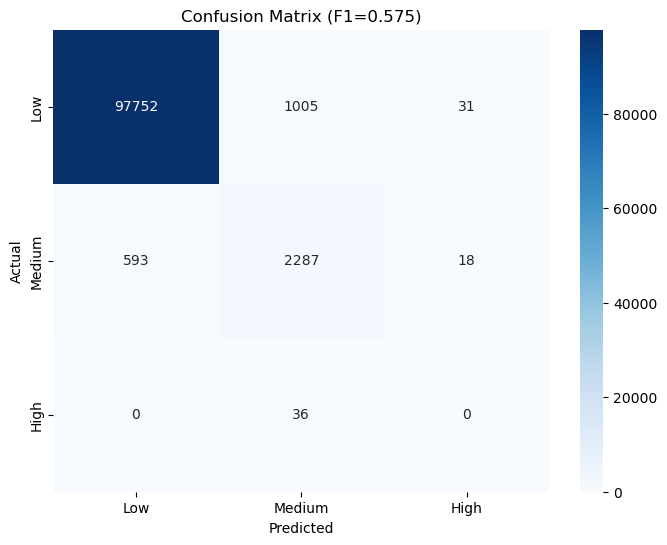

In [141]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Per-class F1-Score
print("\n" + "=" * 60)
print("PER-CLASS PERFORMANCE")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (F1={f1_macro:.3f})')
plt.show()

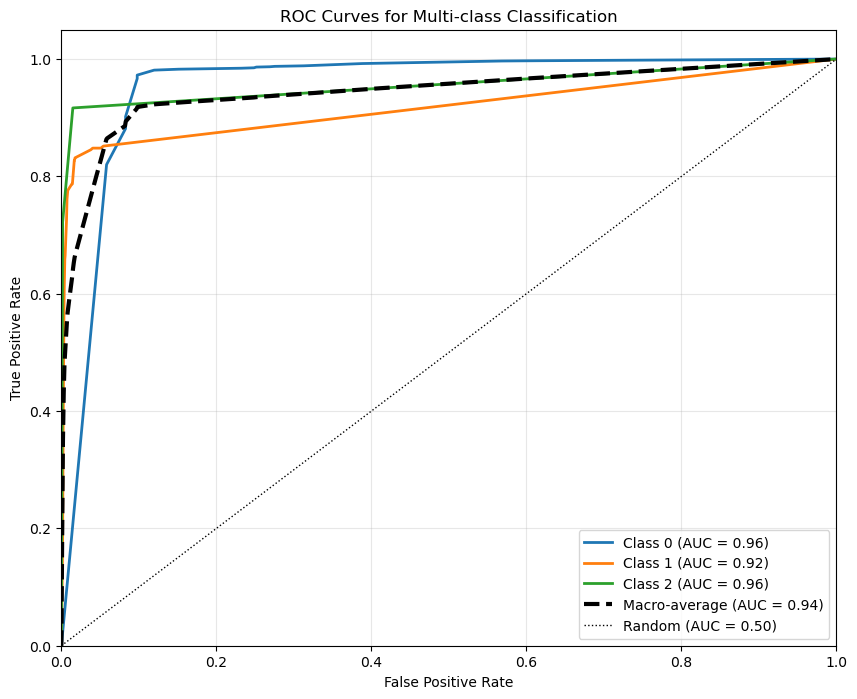


ROC-AUC Scores:
  Low: 0.9551
  Medium: 0.9182
  High: 0.9556
  Macro-average: 0.9429


In [ ]:
# Binarize the labels for ROC-AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = 3

# Calculate ROC-AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Macro-average ROC-AUC
fpr_grid = np.linspace(0.0, 1.0, 1000)
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

mean_tpr /= n_classes
roc_auc_macro = auc(fpr_grid, mean_tpr)

plt.plot(fpr_grid, mean_tpr, 'k--', lw=3, label=f'Macro-average (AUC = {roc_auc_macro:.2f})')
plt.plot([0, 1], [0, 1], 'k:', lw=1, label='Random (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Classification')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# Print scores
print("\nROC-AUC Scores:")
for i, name in enumerate(['Low', 'Medium', 'High']):
    print(f"  {name}: {roc_auc[i]:.4f}")
print(f"  Macro-average: {roc_auc_macro:.4f}")

### **4.3.4. Classification Using Package(XgboostClassifier)**

In [32]:
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

In [35]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

Accuracy: 0.9823

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     81508
           1       0.66      0.99      0.79      2896
           2       0.60      0.97      0.74        36

    accuracy                           0.98     84440
   macro avg       0.75      0.98      0.84     84440
weighted avg       0.99      0.98      0.98     84440



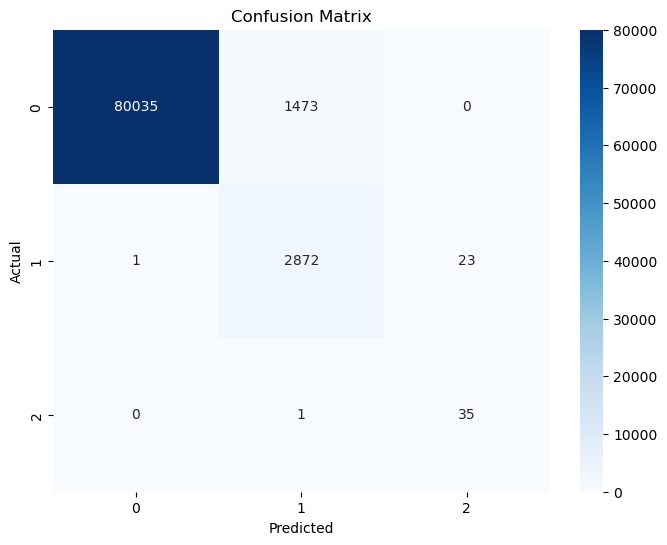

In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### **4.3.5 Hyperparameter Tuning**

In [41]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
}

# Create base model
xgb_model = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

# Grid search with F1-score
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_macro',  # Optimize for F1-score
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit grid search
print("🔍 Starting hyperparameter tuning...")
grid_search.fit(X_train, y_train)

# Best parameters
print("\n✅ Best Parameters:", grid_search.best_params_)
print(f"Best F1-Score: {grid_search.best_score_:.4f}")

🔍 Starting hyperparameter tuning...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


c:\Users\mobile-erfan\anaconda3\Lib\site-packages\xgboost\training.py:200: UserWarning: [01:35:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Best Parameters: {'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}
Best F1-Score: 0.8551


In [42]:
final_model = xgb.XGBClassifier(
    **grid_search.best_params_,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

final_model.fit(X_train, y_train)

c:\Users\mobile-erfan\anaconda3\Lib\site-packages\xgboost\training.py:200: UserWarning: [01:40:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)


FINAL MODEL EVALUATION

Accuracy: 0.9825
 F1-Score (macro): 0.7998
 F1-Score (weighted): 0.9842

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     81508
           1       0.66      0.99      0.79      2896
           2       0.48      0.86      0.61        36

    accuracy                           0.98     84440
   macro avg       0.71      0.94      0.80     84440
weighted avg       0.99      0.98      0.98     84440



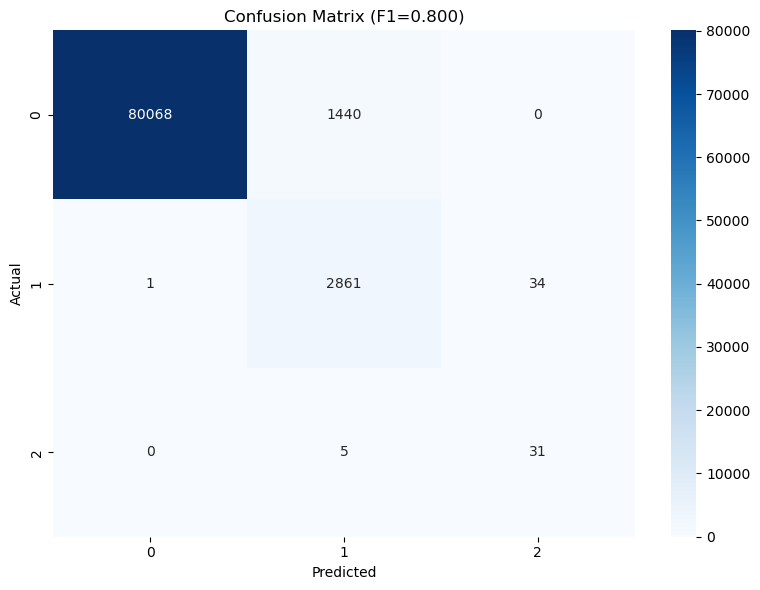

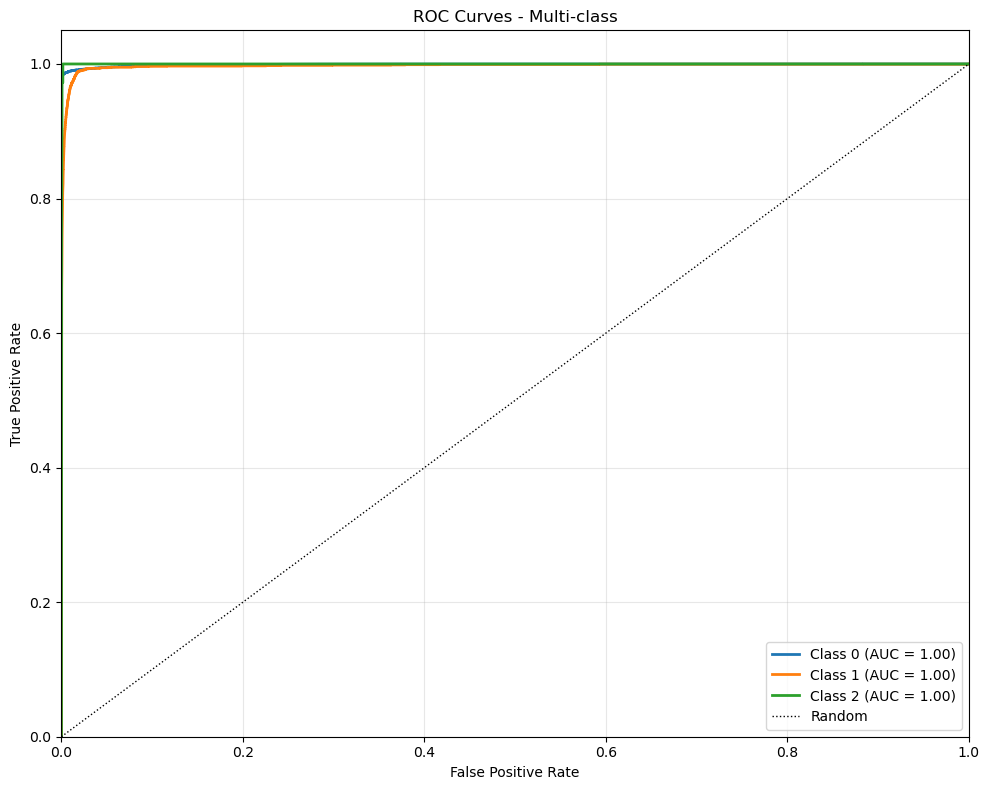

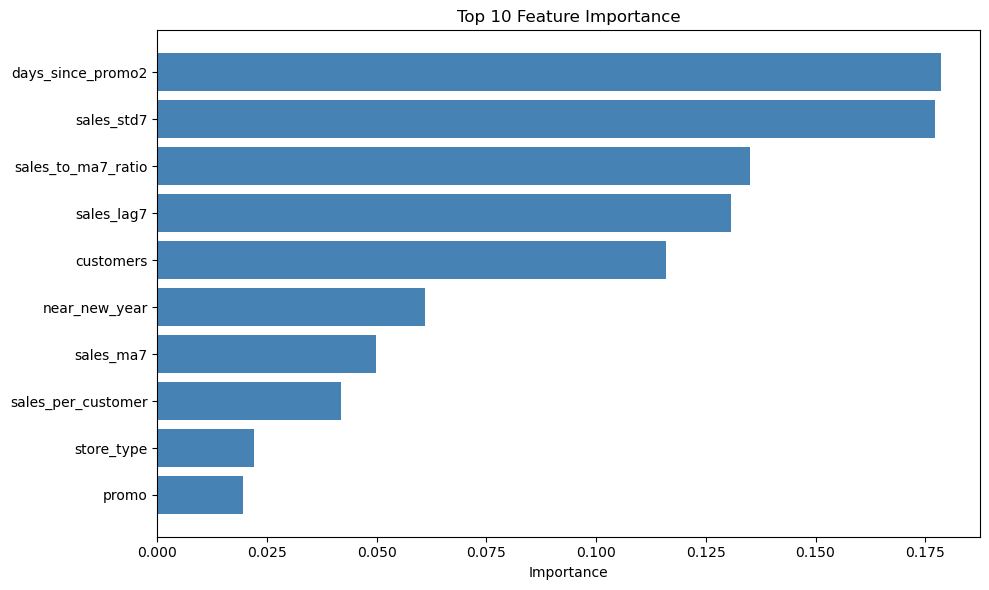

In [44]:
# Step 3: Predictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)

# Step 4: Evaluation Metrics
print("\n" + "="*50)
print("FINAL MODEL EVALUATION")
print("="*50)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# F1-Score (macro and weighted)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f" F1-Score (macro): {f1_macro:.4f}")
print(f" F1-Score (weighted): {f1_weighted:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 5: Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), 
            yticklabels=np.unique(y_test))
plt.title(f'Confusion Matrix (F1={f1_macro:.3f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Step 6: ROC-AUC Curve (for multi-class)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')


# Diagonal line
plt.plot([0, 1], [0, 1], 'k:', lw=1, label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Multi-class')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Step 7: Feature Importance
importance = pd.DataFrame({
    'feature': feature_cols if 'feature_cols' in dir() else [f'Feature {i}' for i in range(X_train.shape[1])],
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# **PHASE 5**